# Beta Band Regressions
Created: 04/08/24 \
Updated: 06/15/2024 \
*running analyses for BRAIN Initiative Conf - updating mixed effects regressions to be across roi only*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

06152024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



subj_id  bdi
0    MS002   14
1    MS003    8
2    MS009   16
3    MS011   13
4    MS015   26
5    MS016   10
6    MS017   26
7    MS019   12
8    MS022   10
9    MS024   16
10   MS025   10
11   MS026    9
12   MS027   22
13   MS028   13
14   MS029   32
15   MS030   19
16   MS033   39
17   MS035   15
18   MS041   10
19   MS043   23
20   MS048   19
21   MS050    9
22     DA8   13
23   DA023   14
24   DA026   19
25   DA037    4

In [7]:
#### set theme for all plots
# %matplotlib inline
from matplotlib import rc
rc('text', usetex=False)

sns.set_theme(style='ticks') 
sns.set_context("poster")



In [8]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm


# saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# 671351
saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
saez_hex_cmap  = ListedColormap(saez_colors)
saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
#plot_palette = saez_linear_cmap.resampled(lutsize=30)
expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


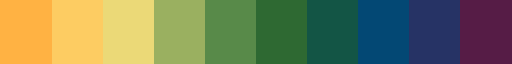

In [9]:
saez_full_cmap

# Load beta power data 

In [11]:
# #### Try Beta Power 
# all_subj_beta_power = {}
# all_subj_metadata   = {}

# beta_range = [13,30]

# # load pow epochs data 
# for subj_id in subj_ids: 
#     # load power epochs for single subject 
#     power_epochs = mne.time_frequency.read_tfrs(f'{neural_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
#     all_subj_metadata[subj_id] = power_epochs.metadata.copy()
    
#     # extract power df with mean beta power for each epoch for each elec 
#     power_df = power_epochs.to_data_frame()
#     del power_epochs 
#     beta_power_df = power_df[(power_df.freq >= beta_range[0])&(power_df.freq <= beta_range[1])].groupby(['epoch']).agg('mean').reset_index()
#     del power_df 
#     all_subj_beta_power[subj_id] = beta_power_df
#     del beta_power_df
    
    
# # create a binary pickle file 
# pickle.dump(all_subj_beta_power,open(f'{save_dir}all_subj_beta_power_nocrop.pkl',"wb"))
# pickle.dump(all_subj_metadata,open(f'{save_dir}all_subj_metadata.pkl',"wb"))

    

# Make Beta Regression DF

1. Update metadata vars - add t+1 vars, normalize vecs by 2std
2. Aggregate metadata, power data, ROI info, bdi info into one master df 

In [10]:
all_subj_beta_power = pickle.load(open(f'{save_dir}all_subj_beta_power_nocrop.pkl',"rb"))

all_subj_metadata = pickle.load(open(f'{save_dir}all_subj_metadata.pkl',"rb"))

In [11]:
### update metadata - zscore continuous regressors + add RT info
for subj_id in subj_ids:
    subj_df         = all_subj_metadata[subj_id]
    rounds_t1       = subj_df.Round.tolist()[1:]
    logRT_list      = np.log(subj_df['RT']).tolist() # take log of RT
    logRT_t1_list   = logRT_list[1:] # get logRT_t1
    GambleChoice_t1 = subj_df.GambleChoice.tolist()[1:]
    GambleEV_t1     = subj_df.GambleEV.tolist()[1:]
    TrialType_t1    = subj_df.TrialType.tolist()[1:]
    TrialEV         = subj_df.GambleEV - subj_df.SafeBet
    TrialEV_t1      = TrialEV[1:].tolist()
    rounds_t1.append(np.nan)
    logRT_t1_list.append(np.nan) # add nan to logRT_t1 (no t1 for last round)
    GambleChoice_t1.append(np.nan)
    GambleEV_t1.append(np.nan)
    TrialType_t1.append(np.nan) 
    TrialEV_t1.append(np.nan)
    subj_df['logRT']           = logRT_list
    subj_df['logRT_t1']        = logRT_t1_list
    subj_df['Round_t1']        = rounds_t1
    subj_df['GambleChoice_t1'] = GambleChoice_t1
    subj_df['GambleEV_t1']     = GambleEV_t1
    subj_df['TrialType_t1']    = TrialType_t1
    subj_df['TrialEV']         = TrialEV
    subj_df['TrialEV_t1']      = TrialEV_t1
    subj_df['bdi']             = subj_info_df.bdi[subj_info_df.subj_id==subj_id].values[0]
    subj_df['subj_id']         = subj_id
    
    # update metadata
    all_subj_metadata[subj_id] = subj_df
    
    
# pickle.dump(all_subj_metadata,open(f'{save_dir}all_subj_metadata_t1.pkl',"wb"))
    
### debugging/testing 

# round_test = [list(zip(all_subj_metadata[key].Round.tolist(),all_subj_metadata[key].RT.tolist(),all_subj_metadata[key].logRT.tolist(),all_subj_metadata[key].logRT_t1.tolist())) for key in all_subj_metadata.keys()]
# is_consecutive = [all([all_subj_metadata[subj_id].Round[i] == all_subj_metadata[subj_id].Round_t1[i-1] for i in range(1, len(all_subj_metadata[subj_id].Round))]) for subj_id in all_subj_metadata.keys()]


    

In [12]:
# ### load ROI reref master 


# # # load newest file
# # paths = glob(f'{save_dir}roi_reref_labels_master_*.csv')
# # load_date = str(np.max([int(path.split('_')[-1][:-4]) # find most recent saved df to load 
# #                         for path in paths]))
# # roi_reref_labels_master_df = pd.read_csv(glob(f'{save_dir}roi_reref_labels_master_0{load_date}.csv')[0])


roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [13]:
continuous_regressors = ['TrialEV','TrialEV_t1','GambleEV','GambleEV_t1','SafeBet',
                         'TotalProfit','CR', 'choiceEV', 'RPE','Profit',
                         'decisionCPE', 'decisionRegret','decisionRelief']

In [14]:
#### add roi info to master df 
beta_master_df = []


for subj_id,pow_df in zip(all_subj_beta_power.keys(),all_subj_beta_power.values()):
    
     # reshape pow_df 
        pow_reg_df = pow_df.melt(id_vars=['epoch','freq'],
                                    value_vars=pow_df.columns.drop(['epoch','time','freq']).tolist().copy(),
                                    var_name='reref_ch_names', value_name='band_pow',
                                    ignore_index = False)

        pow_reg_df['subj_id'] = subj_id # add subj_id to df values
        # reshape metadata df 
        metadata_df = all_subj_metadata[subj_id].reset_index()
        metadata_df = metadata_df.rename(columns={'index':'epoch'})

        # merge pow and metadata dfs keeping epoch as index 
        subj_regression_df = pd.merge(pow_reg_df, metadata_df,left_on=['epoch','subj_id'],
                                    right_on=['epoch','subj_id']).reset_index(drop=True).set_index('epoch')
        
        subj_regression_df['epoch_num'] = subj_regression_df.index # keep epoch as a column

        # add roi info 
        subj_epochs = pow_reg_df.epoch.unique()
        # extract roi_reref_labels_df for each subj 
        subj_roi_reref_labels = roi_reref_labels_master_df[roi_reref_labels_master_df['subj_id']==subj_id]
        # add epochs to df - repeat each elec id for every epoch to join with master df 
        subj_roi_reref_labels = roi_reref_labels_master_df[roi_reref_labels_master_df['subj_id']==subj_id]
        subj_roi_reref_labels = (pd.concat([subj_roi_reref_labels]*len(subj_epochs),
                                keys = subj_epochs,
                                names = ['epoch',None])).reset_index(level=1,drop=True) #make sure epochs are the index
        subj_roi_reref_labels['epoch_num'] = subj_roi_reref_labels.index

        # create unique reref ch id for regression
        subj_roi_reref_labels['unique_reref_ch'] = subj_roi_reref_labels[['subj_id', 'reref_ch_names']].agg('_'.join, axis=1)

        # merge regression df with roi reref info df  
        subj_regression_df = pd.merge(subj_regression_df, subj_roi_reref_labels,left_on=['subj_id','reref_ch_names','epoch_num'],
                                    right_on=['subj_id','reref_ch_names','epoch_num']).reset_index(drop=True).set_index('epoch_num')
        
        subj_regression_df['epoch'] = subj_regression_df.index
        
        ### cleaning within subject BEFORE zscoring regressors! 
        
        # remove trials where RT is too fast (random choice)
        subj_regression_df = subj_regression_df[subj_regression_df.RT>0.3]
        # remove trials where there is no choice at trial t
        subj_regression_df = subj_regression_df[(subj_regression_df.GambleChoice=='gamble') | 
                                                (subj_regression_df.GambleChoice == 'safe')].reset_index(drop=True)
        # remove trials where there is no choice for trial t1 (RT_t1 is nonsense)
        subj_regression_df = subj_regression_df[(subj_regression_df.GambleChoice_t1=='gamble') | 
                                                (subj_regression_df.GambleChoice_t1 == 'safe')].reset_index(drop=True)
        # remove trials where there is no outcome
        subj_regression_df = subj_regression_df[(subj_regression_df.Outcome=='good') | 
                                                (subj_regression_df.Outcome == 'bad')].reset_index(drop=True)
        # remove epoch 76 bc photodiode times are not correct at breakpoint 
        subj_regression_df = subj_regression_df[subj_regression_df.Round != 76]
        # remove trials where logRT_t1 is inf or -inf (means RT = 0)
        subj_regression_df = subj_regression_df[~np.isinf(subj_regression_df.logRT_t1)]
        # format GambleChoice + TrialType vars as categories 
        subj_regression_df['GambleChoice']    = subj_regression_df['GambleChoice'].astype('category')
        subj_regression_df['GambleChoice_t1'] = subj_regression_df['GambleChoice_t1'].astype('category')
        subj_regression_df['TrialType']       = subj_regression_df['TrialType'].astype('category')
        subj_regression_df['TrialType_t1']    = subj_regression_df['TrialType_t1'].astype('category')
        # make sure Round_t1 is an integer
        subj_regression_df['Round_t1']        = subj_regression_df['Round_t1'].astype('Int64')
        subj_regression_df['TrialEV']         = subj_regression_df.GambleEV - subj_regression_df.SafeBet
        
        # zscore continuous regressors AFTER removing bad trials!! 
        for reg in continuous_regressors:
            subj_regression_df[reg] = norm_zscore(subj_regression_df[reg].values) # zscore is /2std

        beta_master_df.append(subj_regression_df)


    
    
beta_master_df = pd.concat(beta_master_df)   
# reorder columns 
beta_master_df = beta_master_df[['subj_id','bdi','epoch','freq','reref_ch_names','band_pow','unique_reref_ch',
                                 'roi','hemi','ch_label4roi','ch_type4roi','loc4roi','Round', 'Round_t1',
                                 'logRT_t1','logRT','RT','TrialType','TrialType_t1','GambleChoice',
                                 'GambleChoice_t1','GambleEV', 'GambleEV_t1','SafeBet','TrialEV','TrialEV_t1',
                                 'Profit','TotalProfit','RPE','decisionCPE', 'decisionRegret','decisionRelief']]



In [15]:
# # beta_master_df.to_csv(f'{save_dir}beta_master_data.csv')
beta_master_df.to_csv(f'{save_dir}beta_master_data_BRAINconf_interactionnocrop.csv')

# beta_master_df

In [16]:
beta_master_df

subj_id  bdi  epoch       freq reref_ch_names  band_pow  \
0      MS002   14      0  20.743342  lacas1-lacas2 -0.123971   
1      MS002   14      0  20.743342  lacas2-lacas3 -0.186139   
2      MS002   14      0  20.743342  lacas3-lacas4 -0.235353   
3      MS002   14      0  20.743342  lacas4-lacas5 -0.086471   
4      MS002   14      0  20.743342  lacas5-lacas6 -0.145393   
...      ...  ...    ...        ...            ...       ...   
3748   DA037    4    148  20.743342  rpins1-rpins2 -0.832139   
3749   DA037    4    148  20.743342  rpins2-rpins3 -0.831343   
3750   DA037    4    148  20.743342  rpins3-rpins4 -0.251848   
3751   DA037    4    148  20.743342  rpins4-rpins5  0.022261   
3752   DA037    4    148  20.743342      rmc7-rmc8 -0.044171   

          unique_reref_ch    roi hemi ch_label4roi  ... GambleEV_t1   SafeBet  \
0     MS002_lacas1-lacas2    acc    l       lacas1  ...   -0.406880 -0.007878   
1     MS002_lacas2-lacas3    acc    l       lacas2  ...   -0.406880 -0.007878   
2     MS002_lacas3-lacas4    acc    l       lacas3  ...   -0.406880 -0.007878   
3     MS002_lacas4-lacas5    acc    l       lacas4  ...   -0.406880 -0.007878   
4     MS002_lacas5-lacas6    acc    l       lacas5  ...   -0.406880 -0.007878   
...                   ...    ...  ...          ...  ...         ...       ...   
3748  DA037_rpins1-rpins2   pins    r       rpins1  ...    0.012054  0.863812   
3749  DA037_rpins2-rpins3   pins    r       rpins2  ...    0.012054  0.863812   
3750  DA037_rpins3-rpins4   pins    r       rpins3  ...    0.012054  0.863812   
3751  DA037_rpins4-rpins5   pins    r       rpins4  ...    0.012054  0.863812   
3752      DA037_rmc7-rmc8  dlpfc    r         rmc8  ...    0.012054  0.863812   

       TrialEV  TrialEV_t1    Profit  TotalProfit       RPE decisionCPE  \
0    -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   -0.395746   
1    -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   -0.395746   
2    -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   -0.395746   
3    -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   -0.395746   
4    -0.437011   -0.277154 -0.032900    -1.028523 -0.008746   -0.395746   
...        ...         ...       ...          ...       ...         ...   
3748  0.150135    0.036023  0.012982    -0.523591 -0.481120   -0.353760   
3749  0.150135    0.036023  0.012982    -0.523591 -0.481120   -0.353760   
3750  0.150135    0.036023  0.012982    -0.523591 -0.481120   -0.353760   
3751  0.150135    0.036023  0.012982    -0.523591 -0.481120   -0.353760   
3752  0.150135    0.036023  0.012982    -0.523591 -0.481120   -0.353760   

     decisionRegret decisionRelief  
0         -0.287638      -0.392122  
1         -0.287638      -0.392122  
2         -0.287638      -0.392122  
3         -0.287638      -0.392122  
4         -0.287638      -0.392122  
...             ...            ...  
3748      -0.291207      -0.317739  
3749      -0.291207      -0.317739  
3750      -0.291207      -0.317739  
3751      -0.291207      -0.317739  
3752      -0.291207      -0.317739  

[250433 rows x 32 columns]

In [23]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
acc              193
ofc              192
sts              151
hpc              135
amy              109
dlpfc            102
stg              100
vlpfc             76
smg               66
ains              64
thalamus          58
pins              57
mtg               54
mcc               28
phg               25
parietal          24
temporal pole     24
motor             19
fusiform          19
occipital         19
vmpfc             18
angular           14
itg               13
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [18]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=50].tolist()

# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
# keep_rois


In [19]:
####### NEW DATA FRAME 
beta_reg_df = beta_master_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
len(beta_reg_df)

216975

In [20]:
np.max(beta_reg_df.band_pow)

6.0325839720499905

In [21]:
beta_reg_df.roi.unique().tolist()

['acc',
 'dmpfc',
 'amy',
 'sts',
 'ains',
 'vlpfc',
 'hpc',
 'mtg',
 'ofc',
 'pins',
 'dlpfc',
 'smg',
 'stg',
 'thalamus']

In [22]:
beta_reg_df.columns

Index(['subj_id', 'bdi', 'epoch', 'freq', 'reref_ch_names', 'band_pow',
       'unique_reref_ch', 'roi', 'hemi', 'ch_label4roi', 'ch_type4roi',
       'loc4roi', 'Round', 'Round_t1', 'logRT_t1', 'logRT', 'RT', 'TrialType',
       'TrialType_t1', 'GambleChoice', 'GambleChoice_t1', 'GambleEV',
       'GambleEV_t1', 'SafeBet', 'TrialEV', 'TrialEV_t1', 'Profit',
       'TotalProfit', 'RPE', 'decisionCPE', 'decisionRegret',
       'decisionRelief'],
      dtype='object')

# INTERACTION FEATURE SELECTION

In [42]:
######## make all possible variable combinations for regressions 
main_var  = ['decisionCPE','band_pow','decisionCPE:band_pow']

### iter vars for RT prediction dfs > 
iter_vars = ['C(GambleChoice)','TrialEV','TotalProfit',
             'C(GambleChoice_t1)','TrialEV_t1']


In [45]:
iter_vars

['C(GambleChoice)',
 'TrialEV',
 'TotalProfit',
 'C(GambleChoice_t1)',
 'TrialEV_t1']

In [46]:
var_combos = [[v]+main_var for v in iter_vars]

for i in range(1,len(iter_vars)-1):
    iter_list = [list(tup)+main_var for tup in list(itertools.combinations(iter_vars,i+1))]
    var_combos.extend(iter_list)

# remove var combos that contain Choice + Trial Type for the *same trial* only bc they are collinear
var_combos = [combo for combo in var_combos if ('C(GambleChoice_t1)' in combo and 'C(TrialType_t1)' not in combo)|
              ('C(GambleChoice_t1)' not in combo and 'C(TrialType_t1)' in combo)|('C(GambleChoice_t1)'not in combo and 'C(TrialType_t1)' not in combo)]

var_combos = [combo for combo in var_combos if ('C(GambleChoice)' in combo and 'C(TrialType)' not in combo)|
              ('C(GambleChoice)' not in combo and 'C(TrialType)' in combo)|('C(GambleChoice)'not in combo and 'C(TrialType)' not in combo)]


var_combos = [combo for combo in var_combos if ('C(GambleChoice)' in combo and 'TrialEV' not in combo)|
              ('C(GambleChoice)' not in combo and 'TrialEV' in combo)|('C(GambleChoice)'not in combo and 'TrialEV' not in combo)]


var_combos = [combo for combo in var_combos if ('TrialEV' in combo and 'C(TrialType)' not in combo)|
              ('TrialEV' not in combo and 'C(TrialType)' in combo)|('TrialEV'not in combo and 'C(TrialType)' not in combo)]

var_combos = [combo for combo in var_combos if ('C(GambleChoice_t1)' in combo and 'TrialEV_t1' not in combo)|
              ('C(GambleChoice_t1)' not in combo and 'TrialEV_t1' in combo)|('C(GambleChoice_t1)'not in combo and 'TrialEV_t1' not in combo)]

var_combos = [combo for combo in var_combos if ('TrialEV_t1' in combo and 'C(TrialType_t1)' not in combo)|
              ('TrialEV_t1' not in combo and 'C(TrialType_t1)' in combo)|('TrialEV_t1'not in combo and 'C(TrialType_t1)' not in combo)]
var_combos

[['C(GambleChoice)', 'decisionCPE', 'band_pow', 'decisionCPE:band_pow'],
 ['TrialEV', 'decisionCPE', 'band_pow', 'decisionCPE:band_pow'],
 ['TotalProfit', 'decisionCPE', 'band_pow', 'decisionCPE:band_pow'],
 ['C(GambleChoice_t1)', 'decisionCPE', 'band_pow', 'decisionCPE:band_pow'],
 ['TrialEV_t1', 'decisionCPE', 'band_pow', 'decisionCPE:band_pow'],
 ['C(GambleChoice)',
  'TotalProfit',
  'decisionCPE',
  'band_pow',
  'decisionCPE:band_pow'],
 ['C(GambleChoice)',
  'C(GambleChoice_t1)',
  'decisionCPE',
  'band_pow',
  'decisionCPE:band_pow'],
 ['C(GambleChoice)',
  'TrialEV_t1',
  'decisionCPE',
  'band_pow',
  'decisionCPE:band_pow'],
 ['TrialEV', 'TotalProfit', 'decisionCPE', 'band_pow', 'decisionCPE:band_pow'],
 ['TrialEV',
  'C(GambleChoice_t1)',
  'decisionCPE',
  'band_pow',
  'decisionCPE:band_pow'],
 ['TrialEV', 'TrialEV_t1', 'decisionCPE', 'band_pow', 'decisionCPE:band_pow'],
 ['TotalProfit',
  'C(GambleChoice_t1)',
  'decisionCPE',
  'band_pow',
  'decisionCPE:band_pow'],
 [

In [48]:
len(var_combos)

17

In [49]:
# import time 
start = time.time() # start timer

all_models = {}
all_rsq    = {}
all_stats  = {}
all_keys   = {}
no_conv    = []

for test_vars in var_combos:
    model_key = ''.join(test_vars[:-1]) ### make string of covariate var names to use as dict key
    model_fit = fit_mixed_model(beta_reg_df,test_vars,outcome_var,rand_eff_var,reml=False)
    # check if model converged
    if model_fit.converged:
        
        print(model_key,' converged!')
        
        all_models[model_key] = model_fit
        all_rsq[model_key]    = compute_marginal_rsq(model_fit)
        all_stats[model_key]  = mixed_effects_ftest_ttest(model_fit)
        all_keys[model_key]   = test_vars
        
    else:
        print(model_key,' did not converge :(')
        no_conv.append(model_key)
    del model_fit

end = time.time()
print('{:.4f} s'.format(end-start)) # print time elapsed for computation (approx 20 seconds per channel)    

C(GambleChoice)decisionCPEband_pow  did not converge :(
TrialEVdecisionCPEband_pow  converged!
TotalProfitdecisionCPEband_pow  did not converge :(
C(GambleChoice_t1)decisionCPEband_pow  did not converge :(
TrialEV_t1decisionCPEband_pow  converged!
C(GambleChoice)TotalProfitdecisionCPEband_pow  did not converge :(
C(GambleChoice)C(GambleChoice_t1)decisionCPEband_pow  did not converge :(
C(GambleChoice)TrialEV_t1decisionCPEband_pow  did not converge :(
TrialEVTotalProfitdecisionCPEband_pow  converged!
TrialEVC(GambleChoice_t1)decisionCPEband_pow  converged!
TrialEVTrialEV_t1decisionCPEband_pow  did not converge :(
TotalProfitC(GambleChoice_t1)decisionCPEband_pow  did not converge :(
TotalProfitTrialEV_t1decisionCPEband_pow  converged!
C(GambleChoice)TotalProfitC(GambleChoice_t1)decisionCPEband_pow  did not converge :(
C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow  converged!
TrialEVTotalProfitC(GambleChoice_t1)decisionCPEband_pow  did not converge :(
TrialEVTotalProfitTrialEV_t

In [50]:
no_conv

['C(GambleChoice)decisionCPEband_pow',
 'TotalProfitdecisionCPEband_pow',
 'C(GambleChoice_t1)decisionCPEband_pow',
 'C(GambleChoice)TotalProfitdecisionCPEband_pow',
 'C(GambleChoice)C(GambleChoice_t1)decisionCPEband_pow',
 'C(GambleChoice)TrialEV_t1decisionCPEband_pow',
 'TrialEVTrialEV_t1decisionCPEband_pow',
 'TotalProfitC(GambleChoice_t1)decisionCPEband_pow',
 'C(GambleChoice)TotalProfitC(GambleChoice_t1)decisionCPEband_pow',
 'TrialEVTotalProfitC(GambleChoice_t1)decisionCPEband_pow',
 'TrialEVTotalProfitTrialEV_t1decisionCPEband_pow']

In [52]:
list(all_models.keys())

['TrialEVdecisionCPEband_pow',
 'TrialEV_t1decisionCPEband_pow',
 'TrialEVTotalProfitdecisionCPEband_pow',
 'TrialEVC(GambleChoice_t1)decisionCPEband_pow',
 'TotalProfitTrialEV_t1decisionCPEband_pow',
 'C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow']

In [56]:
all_models['TrialEVdecisionCPEband_pow'].bic

183960.32843674498

In [57]:
model_summary = {key:all_models[key].bic for key in all_models.keys()}
model_summary

{'TrialEVdecisionCPEband_pow': 183960.32843674498,
 'TrialEV_t1decisionCPEband_pow': 177047.20314724895,
 'TrialEVTotalProfitdecisionCPEband_pow': 181848.56973486487,
 'TrialEVC(GambleChoice_t1)decisionCPEband_pow': 178843.57402138785,
 'TotalProfitTrialEV_t1decisionCPEband_pow': 174523.89745551348,
 'C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow': 174589.04489067727}

In [58]:
bic_list = [model_summary[key] for key in model_summary.keys()]
bic_list.sort()

ordered_list = [list(model_summary.keys())[np.where(list(model_summary.values()) == bic)[0][0]] for bic in bic_list]
list(zip(ordered_list,bic_list))


[('TotalProfitTrialEV_t1decisionCPEband_pow', 174523.89745551348),
 ('C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow',
  174589.04489067727),
 ('TrialEV_t1decisionCPEband_pow', 177047.20314724895),
 ('TrialEVC(GambleChoice_t1)decisionCPEband_pow', 178843.57402138785),
 ('TrialEVTotalProfitdecisionCPEband_pow', 181848.56973486487),
 ('TrialEVdecisionCPEband_pow', 183960.32843674498)]

In [62]:
all_models['TotalProfitTrialEV_t1decisionCPEband_pow'].pvalues

Intercept                                  0.000000e+00
TotalProfit                                1.893103e-07
TrialEV_t1                                 0.000000e+00
decisionCPE                                2.935387e-99
band_pow                                   1.073929e-10
decisionCPE:band_pow                       1.865379e-02
Group Var                                 1.011985e-147
Group x TotalProfit Cov                    1.800256e-19
TotalProfit Var                            1.193473e-97
Group x TrialEV_t1 Cov                     1.977951e-02
TotalProfit x TrialEV_t1 Cov               4.426827e-12
TrialEV_t1 Var                             3.104860e-53
Group x decisionCPE Cov                    8.119241e-03
TotalProfit x decisionCPE Cov              1.465580e-02
TrialEV_t1 x decisionCPE Cov               2.393227e-17
decisionCPE Var                            5.024039e-10
Group x band_pow Cov                       6.965103e-03
TotalProfit x band_pow Cov                 3.174

In [64]:
[(key,bic,all_models[key].pvalues['decisionCPE:band_pow']) for key,bic in list(zip(ordered_list,bic_list))]  


[('TotalProfitTrialEV_t1decisionCPEband_pow',
  174523.89745551348,
  0.018653794369974223),
 ('C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow',
  174589.04489067727,
  0.02154959997825902),
 ('TrialEV_t1decisionCPEband_pow', 177047.20314724895, 0.015797303687821063),
 ('TrialEVC(GambleChoice_t1)decisionCPEband_pow',
  178843.57402138785,
  0.07301748594880124),
 ('TrialEVTotalProfitdecisionCPEband_pow',
  181848.56973486487,
  0.0010226999898479768),
 ('TrialEVdecisionCPEband_pow', 183960.32843674498, 0.0012102286032343937)]

In [65]:
print('worst bic model: ',list(model_summary.keys())[np.where(list(model_summary.values())==np.max(list(model_summary.values())))[0][0]])


worst bic model:  TrialEVdecisionCPEband_pow


In [66]:
print('best bic model: ',list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]])


best bic model:  TotalProfitTrialEV_t1decisionCPEband_pow


In [67]:
print(list(model_summary.keys())[np.where(list(model_summary.values())==np.min(list(model_summary.values())))[0][0]])
print(np.min(list(model_summary.values())))
      
      

TotalProfitTrialEV_t1decisionCPEband_pow
174523.89745551348


In [69]:
[(key,all_models[key].pvalues['decisionCPE:band_pow']) for key in ordered_list if all_models[key].pvalues['decisionCPE:band_pow'] < 0.05]  



[('TotalProfitTrialEV_t1decisionCPEband_pow', 0.018653794369974223),
 ('C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow',
  0.02154959997825902),
 ('TrialEV_t1decisionCPEband_pow', 0.015797303687821063),
 ('TrialEVTotalProfitdecisionCPEband_pow', 0.0010226999898479768),
 ('TrialEVdecisionCPEband_pow', 0.0012102286032343937)]

In [75]:
[(key,all_models[key].pvalues['decisionCPE:band_pow']) for key in ordered_list if all_models[key].pvalues['decisionCPE:band_pow'] > 0.05]  


[('TrialEVC(GambleChoice_t1)decisionCPEband_pow', 0.07301748594880124)]

In [71]:
all_models['TrialEVTotalProfitdecisionCPEband_pow'].pvalues

Intercept                                  0.000000e+00
TrialEV                                    3.909820e-20
TotalProfit                                6.336659e-02
decisionCPE                               2.955712e-110
band_pow                                   1.834651e-09
decisionCPE:band_pow                       1.022700e-03
Group Var                                 1.935438e-160
Group x TrialEV Cov                        2.265357e-08
TrialEV Var                                5.102233e-04
Group x TotalProfit Cov                    3.248977e-16
TrialEV x TotalProfit Cov                  1.304485e-11
TotalProfit Var                            5.449796e-84
Group x decisionCPE Cov                    3.357817e-02
TrialEV x decisionCPE Cov                  1.484978e-01
TotalProfit x decisionCPE Cov              8.743473e-02
decisionCPE Var                            7.681942e-05
Group x band_pow Cov                       6.561763e-02
TrialEV x band_pow Cov                     2.162

In [72]:
all_models['TrialEVTotalProfitdecisionCPEband_pow'].params

Intercept                                 1.022525
TrialEV                                   0.015454
TotalProfit                              -0.005596
decisionCPE                               0.038693
band_pow                                 -0.026977
decisionCPE:band_pow                      0.024549
Group Var                                 0.439386
Group x TrialEV Cov                      -0.018434
TrialEV Var                               0.004406
Group x TotalProfit Cov                  -0.048494
TrialEV x TotalProfit Cov                 0.011126
TotalProfit Var                           0.080235
Group x decisionCPE Cov                  -0.007018
TrialEV x decisionCPE Cov                 0.001238
TotalProfit x decisionCPE Cov            -0.002818
decisionCPE Var                           0.005126
Group x band_pow Cov                     -0.017539
TrialEV x band_pow Cov                    0.005916
TotalProfit x band_pow Cov                0.022438
decisionCPE x band_pow Cov     

In [74]:
all_models['TotalProfitTrialEV_t1decisionCPEband_pow'].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
==================================================================================
Model:                     MixedLM         Dependent Variable:         logRT_t1   
No. Observations:          216952          Method:                     ML         
No. Groups:                1573            Scale:                      0.1243     
Min. group size:           65              Log-Likelihood:             -87089.9247
Max. group size:           148             Converged:                  Yes        
Mean group size:           137.9                                                  
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               1.023    0.006 164.659 0.000  1.010  1.035
TotalProfit                            -0.016    0.003  -5.210 0.000 -0.021 -0.010
TrialEV_t1                             -0.125    0.002 -54.077 0.000 -0.129 -0.120
decisionCPE                             0.040    0.002  21.147 0.000  0.036  0.043
band_pow                               -0.027    0.004  -6.456 0.000 -0.035 -0.019
decisionCPE:band_pow                    0.021    0.009   2.352 0.019  0.004  0.039
Group Var                               0.060    0.007                            
Group x TotalProfit Cov                -0.007    0.002                            
TotalProfit Var                         0.010    0.001                            
Group x TrialEV_t1 Cov                  0.001    0.002                            
TotalProfit x TrialEV_t1 Cov            0.002    0.001                            
TrialEV_t1 Var                          0.005    0.001                            
Group x decisionCPE Cov                -0.001    0.002                            
TotalProfit x decisionCPE Cov           0.001    0.001                            
TrialEV_t1 x decisionCPE Cov            0.002    0.001                            
decisionCPE Var                         0.002    0.001                            
Group x band_pow Cov                   -0.003    0.003                            
TotalProfit x band_pow Cov              0.002    0.001                            
TrialEV_t1 x band_pow Cov              -0.002    0.001                            
decisionCPE x band_pow Cov             -0.001    0.001                            
band_pow Var                            0.002    0.002                            
Group x decisionCPE:band_pow Cov       -0.003    0.009                            
TotalProfit x decisionCPE:band_pow Cov  0.002    0.004                            
TrialEV_t1 x decisionCPE:band_pow Cov   0.002    0.003                            
decisionCPE x decisionCPE:band_pow Cov  0.000    0.003                            
band_pow x decisionCPE:band_pow Cov    -0.000    0.005                            
decisionCPE:band_pow Var                0.029    0.040                            
==================================================================================

"""

In [76]:
all_rsq

{'TrialEVdecisionCPEband_pow': 0.7194197277838732,
 'TrialEV_t1decisionCPEband_pow': 0.5738936503288381,
 'TrialEVTotalProfitdecisionCPEband_pow': 0.6150712309861368,
 'TrialEVC(GambleChoice_t1)decisionCPEband_pow': 0.5354902252756801,
 'TotalProfitTrialEV_t1decisionCPEband_pow': 0.48849659429234227,
 'C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow': 0.45361704201149616}

In [77]:
all_models

{'TrialEVdecisionCPEband_pow': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x2b6e05f56710>,
 'TrialEV_t1decisionCPEband_pow': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x2b6e06b2c6a0>,
 'TrialEVTotalProfitdecisionCPEband_pow': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x2b6e074523b0>,
 'TrialEVC(GambleChoice_t1)decisionCPEband_pow': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x2b6e11777fd0>,
 'TotalProfitTrialEV_t1decisionCPEband_pow': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x2b6e125270a0>,
 'C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow': <statsmodels.regression.mixed_linear_model.MixedLMResultsWrapper at 0x2b6e12e04a00>}

In [79]:
all_stats['TrialEVdecisionCPEband_pow']

(        coef   std err          t          P>|t|  Conf. Int. Low  \
 c0  0.017897  0.001708  10.480936   1.071991e-25        0.014551   
 c1  0.039148  0.001747  22.405796  4.623460e-111        0.035723   
 c2 -0.033505  0.004265  -7.855862   3.988340e-15       -0.041865   
 c3  0.024006  0.007417   3.236458   1.210410e-03        0.009468   
 
     Conf. Int. Upp.  
 c0         0.021244  
 c1         0.042572  
 c2        -0.025146  
 c3         0.038544  ,
 <class 'statsmodels.stats.contrast.ContrastResults'>
 <F test: F=75.9441910206052, p=8.055879481302701e-294, df_denom=2.17e+05, df_num=19>)

In [ ]:
all_stats

In [82]:
#### FOR NOW JUST SAVE CPE STATS!
t_test_results_summary = [pd.DataFrame({'ttest_fe_tval':stats[0].t.tolist()[-1],
                                        'ttest_fe_coef' :stats[0].coef.tolist()[-1],
                                        'ttest_fe_pval':stats[0]['P>|t|'].tolist()[-1],
                                        'model_id':idx},index=[0]) 
                          for idx,stats in all_stats.items()]


t_test_results_summary = pd.concat(t_test_results_summary).reset_index(drop=True)
t_test_results_summary



ttest_fe_tval  ttest_fe_coef  ttest_fe_pval  \
0       3.236458       0.024006       0.001210   
1       2.413565       0.020452       0.015798   
2       3.284206       0.024549       0.001023   
3       1.792721       0.015233       0.073019   
4       2.352378       0.021076       0.018655   
5       2.298214       0.022107       0.021551   

                                            model_id  
0                         TrialEVdecisionCPEband_pow  
1                      TrialEV_t1decisionCPEband_pow  
2              TrialEVTotalProfitdecisionCPEband_pow  
3       TrialEVC(GambleChoice_t1)decisionCPEband_pow  
4           TotalProfitTrialEV_t1decisionCPEband_pow  
5  C(GambleChoice)TotalProfitTrialEV_t1decisionCP...

In [83]:
f_test_results_summary = [pd.DataFrame({'ftest_fvalue':stats[1].fvalue,
                                        'ftest_re_df':stats[1].df_num,
                                        'ftest_f_pval':stats[1].pvalue,
                                        'model_id':idx},index=[0]) 
                          for idx,stats in all_stats.items()]

f_test_results_summary = pd.concat(f_test_results_summary).reset_index(drop=True)
f_test_results_summary

ftest_fvalue  ftest_re_df   ftest_f_pval  \
0     75.944191         19.0  8.055879e-294   
1    279.468389         19.0   0.000000e+00   
2     68.162436         26.0   0.000000e+00   
3    124.975459         26.0   0.000000e+00   
4    223.032760         26.0   0.000000e+00   
5    167.126151         34.0   0.000000e+00   

                                            model_id  
0                         TrialEVdecisionCPEband_pow  
1                      TrialEV_t1decisionCPEband_pow  
2              TrialEVTotalProfitdecisionCPEband_pow  
3       TrialEVC(GambleChoice_t1)decisionCPEband_pow  
4           TotalProfitTrialEV_t1decisionCPEband_pow  
5  C(GambleChoice)TotalProfitTrialEV_t1decisionCP...

In [84]:
tstat_fstat_df = pd.merge(t_test_results_summary,f_test_results_summary,left_on=['model_id'],
                          right_on=['model_id']).reset_index(drop=True)

tstat_fstat_df = tstat_fstat_df[['model_id','ttest_fe_tval', 'ttest_fe_coef', 'ttest_fe_pval',
                                 'ftest_fvalue', 'ftest_re_df', 'ftest_f_pval']]
tstat_fstat_df



model_id  ttest_fe_tval  \
0                         TrialEVdecisionCPEband_pow       3.236458   
1                      TrialEV_t1decisionCPEband_pow       2.413565   
2              TrialEVTotalProfitdecisionCPEband_pow       3.284206   
3       TrialEVC(GambleChoice_t1)decisionCPEband_pow       1.792721   
4           TotalProfitTrialEV_t1decisionCPEband_pow       2.352378   
5  C(GambleChoice)TotalProfitTrialEV_t1decisionCP...       2.298214   

   ttest_fe_coef  ttest_fe_pval  ftest_fvalue  ftest_re_df   ftest_f_pval  
0       0.024006       0.001210     75.944191         19.0  8.055879e-294  
1       0.020452       0.015798    279.468389         19.0   0.000000e+00  
2       0.024549       0.001023     68.162436         26.0   0.000000e+00  
3       0.015233       0.073019    124.975459         26.0   0.000000e+00  
4       0.021076       0.018655    223.032760         26.0   0.000000e+00  
5       0.022107       0.021551    167.126151         34.0   0.000000e+00

In [86]:
tstat_fstat_df['rsq'] = [val for key,val in all_rsq.items()]

In [87]:
tstat_fstat_df

model_id  ttest_fe_tval  \
0                         TrialEVdecisionCPEband_pow       3.236458   
1                      TrialEV_t1decisionCPEband_pow       2.413565   
2              TrialEVTotalProfitdecisionCPEband_pow       3.284206   
3       TrialEVC(GambleChoice_t1)decisionCPEband_pow       1.792721   
4           TotalProfitTrialEV_t1decisionCPEband_pow       2.352378   
5  C(GambleChoice)TotalProfitTrialEV_t1decisionCP...       2.298214   

   ttest_fe_coef  ttest_fe_pval  ftest_fvalue  ftest_re_df   ftest_f_pval  \
0       0.024006       0.001210     75.944191         19.0  8.055879e-294   
1       0.020452       0.015798    279.468389         19.0   0.000000e+00   
2       0.024549       0.001023     68.162436         26.0   0.000000e+00   
3       0.015233       0.073019    124.975459         26.0   0.000000e+00   
4       0.021076       0.018655    223.032760         26.0   0.000000e+00   
5       0.022107       0.021551    167.126151         34.0   0.000000e+00   

        rsq  
0  0.719420  
1  0.573894  
2  0.615071  
3  0.535490  
4  0.488497  
5  0.453617

In [85]:
all_rsq

{'TrialEVdecisionCPEband_pow': 0.7194197277838732,
 'TrialEV_t1decisionCPEband_pow': 0.5738936503288381,
 'TrialEVTotalProfitdecisionCPEband_pow': 0.6150712309861368,
 'TrialEVC(GambleChoice_t1)decisionCPEband_pow': 0.5354902252756801,
 'TotalProfitTrialEV_t1decisionCPEband_pow': 0.48849659429234227,
 'C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow': 0.45361704201149616}

In [88]:

tstat_fstat_df['bic']         = [all_models[key].bic for key in all_models.keys()]


In [89]:
tstat_fstat_df

model_id  ttest_fe_tval  \
0                         TrialEVdecisionCPEband_pow       3.236458   
1                      TrialEV_t1decisionCPEband_pow       2.413565   
2              TrialEVTotalProfitdecisionCPEband_pow       3.284206   
3       TrialEVC(GambleChoice_t1)decisionCPEband_pow       1.792721   
4           TotalProfitTrialEV_t1decisionCPEband_pow       2.352378   
5  C(GambleChoice)TotalProfitTrialEV_t1decisionCP...       2.298214   

   ttest_fe_coef  ttest_fe_pval  ftest_fvalue  ftest_re_df   ftest_f_pval  \
0       0.024006       0.001210     75.944191         19.0  8.055879e-294   
1       0.020452       0.015798    279.468389         19.0   0.000000e+00   
2       0.024549       0.001023     68.162436         26.0   0.000000e+00   
3       0.015233       0.073019    124.975459         26.0   0.000000e+00   
4       0.021076       0.018655    223.032760         26.0   0.000000e+00   
5       0.022107       0.021551    167.126151         34.0   0.000000e+00   

        rsq            bic  
0  0.719420  183960.328437  
1  0.573894  177047.203147  
2  0.615071  181848.569735  
3  0.535490  178843.574021  
4  0.488497  174523.897456  
5  0.453617  174589.044891

In [91]:
tstat_fstat_df['fe_cpe_est'] = [all_models[key].params['decisionCPE:band_pow'] for key in all_models.keys()]

In [93]:
tstat_fstat_df['fe_cpe_pval'] = [all_models[key].pvalues['decisionCPE:band_pow'] for key in all_models.keys()]

In [94]:
tstat_fstat_df



model_id  ttest_fe_tval  \
0                         TrialEVdecisionCPEband_pow       3.236458   
1                      TrialEV_t1decisionCPEband_pow       2.413565   
2              TrialEVTotalProfitdecisionCPEband_pow       3.284206   
3       TrialEVC(GambleChoice_t1)decisionCPEband_pow       1.792721   
4           TotalProfitTrialEV_t1decisionCPEband_pow       2.352378   
5  C(GambleChoice)TotalProfitTrialEV_t1decisionCP...       2.298214   

   ttest_fe_coef  ttest_fe_pval  ftest_fvalue  ftest_re_df   ftest_f_pval  \
0       0.024006       0.001210     75.944191         19.0  8.055879e-294   
1       0.020452       0.015798    279.468389         19.0   0.000000e+00   
2       0.024549       0.001023     68.162436         26.0   0.000000e+00   
3       0.015233       0.073019    124.975459         26.0   0.000000e+00   
4       0.021076       0.018655    223.032760         26.0   0.000000e+00   
5       0.022107       0.021551    167.126151         34.0   0.000000e+00   

        rsq            bic  fe_cpe_est  fe_cpe_pval  
0  0.719420  183960.328437    0.024006     0.001210  
1  0.573894  177047.203147    0.020452     0.015797  
2  0.615071  181848.569735    0.024549     0.001023  
3  0.535490  178843.574021    0.015233     0.073017  
4  0.488497  174523.897456    0.021076     0.018654  
5  0.453617  174589.044891    0.022107     0.021550

In [95]:
#### multiple comparisons correction!!!!
bonferr_alpha = 0.05/len(tstat_fstat_df)
bonferr_alpha

0.008333333333333333

In [96]:

tstat_fstat_df.sort_values(by='fe_cpe_pval')

model_id  ttest_fe_tval  \
2              TrialEVTotalProfitdecisionCPEband_pow       3.284206   
0                         TrialEVdecisionCPEband_pow       3.236458   
1                      TrialEV_t1decisionCPEband_pow       2.413565   
4           TotalProfitTrialEV_t1decisionCPEband_pow       2.352378   
5  C(GambleChoice)TotalProfitTrialEV_t1decisionCP...       2.298214   
3       TrialEVC(GambleChoice_t1)decisionCPEband_pow       1.792721   

   ttest_fe_coef  ttest_fe_pval  ftest_fvalue  ftest_re_df   ftest_f_pval  \
2       0.024549       0.001023     68.162436         26.0   0.000000e+00   
0       0.024006       0.001210     75.944191         19.0  8.055879e-294   
1       0.020452       0.015798    279.468389         19.0   0.000000e+00   
4       0.021076       0.018655    223.032760         26.0   0.000000e+00   
5       0.022107       0.021551    167.126151         34.0   0.000000e+00   
3       0.015233       0.073019    124.975459         26.0   0.000000e+00   

        rsq            bic  fe_cpe_est  fe_cpe_pval  
2  0.615071  181848.569735    0.024549     0.001023  
0  0.719420  183960.328437    0.024006     0.001210  
1  0.573894  177047.203147    0.020452     0.015797  
4  0.488497  174523.897456    0.021076     0.018654  
5  0.453617  174589.044891    0.022107     0.021550  
3  0.535490  178843.574021    0.015233     0.073017

In [97]:
# tstat_fstat_df = tstat_fstat_df[tstat_fstat_df.fe_cpe_pval < bonferr_alpha]
tstat_fstat_df.sort_values(by='ttest_fe_pval')

model_id  ttest_fe_tval  \
2              TrialEVTotalProfitdecisionCPEband_pow       3.284206   
0                         TrialEVdecisionCPEband_pow       3.236458   
1                      TrialEV_t1decisionCPEband_pow       2.413565   
4           TotalProfitTrialEV_t1decisionCPEband_pow       2.352378   
5  C(GambleChoice)TotalProfitTrialEV_t1decisionCP...       2.298214   
3       TrialEVC(GambleChoice_t1)decisionCPEband_pow       1.792721   

   ttest_fe_coef  ttest_fe_pval  ftest_fvalue  ftest_re_df   ftest_f_pval  \
2       0.024549       0.001023     68.162436         26.0   0.000000e+00   
0       0.024006       0.001210     75.944191         19.0  8.055879e-294   
1       0.020452       0.015798    279.468389         19.0   0.000000e+00   
4       0.021076       0.018655    223.032760         26.0   0.000000e+00   
5       0.022107       0.021551    167.126151         34.0   0.000000e+00   
3       0.015233       0.073019    124.975459         26.0   0.000000e+00   

        rsq            bic  fe_cpe_est  fe_cpe_pval  
2  0.615071  181848.569735    0.024549     0.001023  
0  0.719420  183960.328437    0.024006     0.001210  
1  0.573894  177047.203147    0.020452     0.015797  
4  0.488497  174523.897456    0.021076     0.018654  
5  0.453617  174589.044891    0.022107     0.021550  
3  0.535490  178843.574021    0.015233     0.073017

In [98]:
save_df = tstat_fstat_df.copy()

In [99]:
tstat_fstat_df.sort_values(by='ttest_fe_pval')

model_id  ttest_fe_tval  \
2              TrialEVTotalProfitdecisionCPEband_pow       3.284206   
0                         TrialEVdecisionCPEband_pow       3.236458   
1                      TrialEV_t1decisionCPEband_pow       2.413565   
4           TotalProfitTrialEV_t1decisionCPEband_pow       2.352378   
5  C(GambleChoice)TotalProfitTrialEV_t1decisionCP...       2.298214   
3       TrialEVC(GambleChoice_t1)decisionCPEband_pow       1.792721   

   ttest_fe_coef  ttest_fe_pval  ftest_fvalue  ftest_re_df   ftest_f_pval  \
2       0.024549       0.001023     68.162436         26.0   0.000000e+00   
0       0.024006       0.001210     75.944191         19.0  8.055879e-294   
1       0.020452       0.015798    279.468389         19.0   0.000000e+00   
4       0.021076       0.018655    223.032760         26.0   0.000000e+00   
5       0.022107       0.021551    167.126151         34.0   0.000000e+00   
3       0.015233       0.073019    124.975459         26.0   0.000000e+00   

        rsq            bic  fe_cpe_est  fe_cpe_pval  
2  0.615071  181848.569735    0.024549     0.001023  
0  0.719420  183960.328437    0.024006     0.001210  
1  0.573894  177047.203147    0.020452     0.015797  
4  0.488497  174523.897456    0.021076     0.018654  
5  0.453617  174589.044891    0.022107     0.021550  
3  0.535490  178843.574021    0.015233     0.073017

In [100]:
tstat_fstat_df.ttest_fe_pval

0    0.001210
1    0.015798
2    0.001023
3    0.073019
4    0.018655
5    0.021551
Name: ttest_fe_pval, dtype: float64

In [101]:
print('Best BIC model: ',tstat_fstat_df.model_id[tstat_fstat_df.bic == np.min(tstat_fstat_df.bic)].values[0])


Best BIC model:  TotalProfitTrialEV_t1decisionCPEband_pow


In [102]:
print('Best fe_cpe_pval model: ',tstat_fstat_df.model_id[tstat_fstat_df.fe_cpe_pval == np.min(tstat_fstat_df.fe_cpe_pval)].values[0])


Best fe_cpe_pval model:  TrialEVTotalProfitdecisionCPEband_pow


In [103]:
print('Best rsq model: ',tstat_fstat_df.model_id[tstat_fstat_df.rsq == np.max(tstat_fstat_df.rsq)].values[0])


Best rsq model:  TrialEVdecisionCPEband_pow


In [104]:
print('Best ttest pval: ',tstat_fstat_df.model_id[tstat_fstat_df.ttest_fe_pval == 
                                                  np.min(tstat_fstat_df.ttest_fe_pval)].values[0])


Best ttest pval:  TrialEVTotalProfitdecisionCPEband_pow


In [105]:
print('Best tstat: ',tstat_fstat_df.model_id[tstat_fstat_df.ttest_fe_tval == 
                                                  np.max(tstat_fstat_df.ttest_fe_tval)].values[0])


Best tstat:  TrialEVTotalProfitdecisionCPEband_pow


In [106]:
print('Best ftest pval: ',tstat_fstat_df.model_id[tstat_fstat_df.ftest_f_pval == 
                                                  np.min(tstat_fstat_df.ftest_f_pval)].values[0])

Best ftest pval:  TrialEV_t1decisionCPEband_pow


In [107]:
print('Best Fstat model: ',tstat_fstat_df.model_id[tstat_fstat_df.ftest_fvalue == 
                                                  np.max(tstat_fstat_df.ftest_fvalue)].values[0])

Best Fstat model:  TrialEV_t1decisionCPEband_pow


In [129]:
all_models_fe_data   = {}

for key in all_models.keys():
#     model_unique_elecs = all_models[key].random_effects.keys()
    model_fe_params = {f'{param}':all_models[key].fe_params[param] for param in all_models[key].fe_params.index}
    model_fe_params['model_id'] = key
    all_models_fe_data[key] = model_fe_params



In [130]:
all_models_fe_data

{'TrialEVdecisionCPEband_pow': {'Intercept': 1.0222907271659145,
  'TrialEV': 0.017897435632809947,
  'decisionCPE': 0.03914778029187052,
  'band_pow': -0.03350545157877548,
  'decisionCPE:band_pow': 0.02400622260152413,
  'model_id': 'TrialEVdecisionCPEband_pow'},
 'TrialEV_t1decisionCPEband_pow': {'Intercept': 1.022050959437075,
  'TrialEV_t1': -0.12169714004986187,
  'decisionCPE': 0.03923198829821148,
  'band_pow': -0.035721883860415464,
  'decisionCPE:band_pow': 0.020452035727687896,
  'model_id': 'TrialEV_t1decisionCPEband_pow'},
 'TrialEVTotalProfitdecisionCPEband_pow': {'Intercept': 1.0225247222740346,
  'TrialEV': 0.015454180142902662,
  'TotalProfit': -0.005595730204409386,
  'decisionCPE': 0.03869335110910139,
  'band_pow': -0.02697675764917416,
  'decisionCPE:band_pow': 0.024548931800987075,
  'model_id': 'TrialEVTotalProfitdecisionCPEband_pow'},
 'TrialEVC(GambleChoice_t1)decisionCPEband_pow': {'Intercept': 0.9811796421848855,
  'C(GambleChoice_t1)[T.safe]': 0.096879939215

In [143]:
model_plot_data = {}

for key in all_models.keys():
    fe_param_names = list(all_models[key].fe_params.index)
    
    plot_data = pd.concat([pd.DataFrame(
    {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
     **{f'raw_{param}':all_models[key].random_effects[elec_id][param] for param in list(
            all_models[key].random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
    for elec_id in all_models[key].random_effects.keys()]).reset_index(drop=True)
    
    plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
                                for idx,row in plot_data.iterrows()]

    plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
                                for subj_id in plot_data.subj_id]
    model_plot_data[key] = plot_data



In [145]:
plot_data

subj_id reref_ch_names      unique_reref_ch  raw_Group  \
0      DA023      lac1-lac2      DA023_lac1-lac2  -0.119553   
1      DA023    lac10-lac11    DA023_lac10-lac11  -0.117902   
2      DA023      lac2-lac3      DA023_lac2-lac3  -0.118224   
3      DA023      lac3-lac4      DA023_lac3-lac4  -0.118352   
4      DA023      lac4-lac5      DA023_lac4-lac5  -0.118422   
...      ...            ...                  ...        ...   
1568   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.248091   
1569   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.248889   
1570   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.248843   
1571   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.253625   
1572   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.249213   

      raw_C(GambleChoice)[T.safe]  raw_TotalProfit  raw_TrialEV_t1  \
0                       -0.008195        -0.029546       -0.088075   
1                       -0.008080        -0.031574       -0.081996   
2                       -0.008142        -0.033378       -0.086074   
3                       -0.008232        -0.034513       -0.084816   
4                       -0.008291        -0.032645       -0.087950   
...                           ...              ...             ...   
1568                     0.007041        -0.100902       -0.027964   
1569                     0.007089        -0.101899       -0.027819   
1570                     0.007093        -0.101230       -0.029288   
1571                     0.006629        -0.102500       -0.030504   
1572                     0.006897        -0.103073       -0.027907   

      raw_decisionCPE  raw_band_pow  raw_decisionCPE:band_pow    roi  bdi  
0           -0.030447      0.033140                  0.071630    acc   14  
1           -0.028654     -0.001303                  0.120604  dmpfc   14  
2           -0.029627      0.012383                  0.078818    acc   14  
3           -0.028286     -0.002203                 -0.015358    acc   14  
4           -0.029540      0.017401                 -0.010217  dmpfc   14  
...               ...           ...                       ...    ...  ...  
1568        -0.009032      0.010475                  0.016908    ofc    9  
1569        -0.007793      0.008571                 -0.068738    ofc    9  
1570        -0.007838      0.018726                 -0.082870    ofc    9  
1571        -0.005560      0.015136                 -0.144591    ofc    9  
1572        -0.007694     -0.000160                 -0.055992  vlpfc    9  

[1573 rows x 12 columns]

In [ ]:
# plot_data = pd.concat([pd.DataFrame(
#     {**{'subj_id':elec_id.split('_')[0],'reref_ch_names':elec_id.split('_')[1]},'unique_reref_ch':elec_id,
#      **{f'raw_{param}':interaction_fit.random_effects[elec_id][param] for param in list(
#             interaction_fit.random_effects[elec_id].index)}},index=[range(len(fe_param_names))])
        
#     for elec_id in interaction_fit.random_effects.keys()]).reset_index(drop=True)

# plot_data['roi'] = [beta_reg_df.roi[beta_reg_df.unique_reref_ch == row.unique_reref_ch].values[0]
#                                 for idx,row in plot_data.iterrows()]

# plot_data['bdi'] = [subj_info_df.bdi[subj_info_df.subj_id == subj_id].values[0]
#                                 for subj_id in plot_data.subj_id]

In [148]:
all_models_fe_data

{'TrialEVdecisionCPEband_pow': {'Intercept': 1.0222907271659145,
  'TrialEV': 0.017897435632809947,
  'decisionCPE': 0.03914778029187052,
  'band_pow': -0.03350545157877548,
  'decisionCPE:band_pow': 0.02400622260152413,
  'model_id': 'TrialEVdecisionCPEband_pow'},
 'TrialEV_t1decisionCPEband_pow': {'Intercept': 1.022050959437075,
  'TrialEV_t1': -0.12169714004986187,
  'decisionCPE': 0.03923198829821148,
  'band_pow': -0.035721883860415464,
  'decisionCPE:band_pow': 0.020452035727687896,
  'model_id': 'TrialEV_t1decisionCPEband_pow'},
 'TrialEVTotalProfitdecisionCPEband_pow': {'Intercept': 1.0225247222740346,
  'TrialEV': 0.015454180142902662,
  'TotalProfit': -0.005595730204409386,
  'decisionCPE': 0.03869335110910139,
  'band_pow': -0.02697675764917416,
  'decisionCPE:band_pow': 0.024548931800987075,
  'model_id': 'TrialEVTotalProfitdecisionCPEband_pow'},
 'TrialEVC(GambleChoice_t1)decisionCPEband_pow': {'Intercept': 0.9811796421848855,
  'C(GambleChoice_t1)[T.safe]': 0.096879939215

In [149]:
all_models_fe_data[key]

{'Intercept': 1.0158883848759581,
 'C(GambleChoice)[T.safe]': 0.013588121952033617,
 'TotalProfit': -0.01575941200522582,
 'TrialEV_t1': -0.12516211174122177,
 'decisionCPE': 0.0395385439806472,
 'band_pow': -0.025914371176547667,
 'decisionCPE:band_pow': 0.02210720843757896,
 'model_id': 'C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow'}

In [150]:
plot_data

subj_id reref_ch_names      unique_reref_ch  raw_Group  \
0      DA023      lac1-lac2      DA023_lac1-lac2  -0.119553   
1      DA023    lac10-lac11    DA023_lac10-lac11  -0.117902   
2      DA023      lac2-lac3      DA023_lac2-lac3  -0.118224   
3      DA023      lac3-lac4      DA023_lac3-lac4  -0.118352   
4      DA023      lac4-lac5      DA023_lac4-lac5  -0.118422   
...      ...            ...                  ...        ...   
1568   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.248091   
1569   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.248889   
1570   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.248843   
1571   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.253625   
1572   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.249213   

      raw_C(GambleChoice)[T.safe]  raw_TotalProfit  raw_TrialEV_t1  \
0                       -0.008195        -0.029546       -0.088075   
1                       -0.008080        -0.031574       -0.081996   
2                       -0.008142        -0.033378       -0.086074   
3                       -0.008232        -0.034513       -0.084816   
4                       -0.008291        -0.032645       -0.087950   
...                           ...              ...             ...   
1568                     0.007041        -0.100902       -0.027964   
1569                     0.007089        -0.101899       -0.027819   
1570                     0.007093        -0.101230       -0.029288   
1571                     0.006629        -0.102500       -0.030504   
1572                     0.006897        -0.103073       -0.027907   

      raw_decisionCPE  raw_band_pow  raw_decisionCPE:band_pow    roi  bdi  
0           -0.030447      0.033140                  0.071630    acc   14  
1           -0.028654     -0.001303                  0.120604  dmpfc   14  
2           -0.029627      0.012383                  0.078818    acc   14  
3           -0.028286     -0.002203                 -0.015358    acc   14  
4           -0.029540      0.017401                 -0.010217  dmpfc   14  
...               ...           ...                       ...    ...  ...  
1568        -0.009032      0.010475                  0.016908    ofc    9  
1569        -0.007793      0.008571                 -0.068738    ofc    9  
1570        -0.007838      0.018726                 -0.082870    ofc    9  
1571        -0.005560      0.015136                 -0.144591    ofc    9  
1572        -0.007694     -0.000160                 -0.055992  vlpfc    9  

[1573 rows x 12 columns]

In [151]:

for key in model_plot_data.keys():
    plot_data = model_plot_data[key]
    fe_params = all_models_fe_data[key]
    fe_intercept = fe_params['Intercept']
    fe_cpe_beta  = fe_params['decisionCPE:band_pow']
    elec_b0      =  np.add(plot_data.raw_Group,fe_intercept)
    elec_bCPE    =  np.add(plot_data['raw_decisionCPE:band_pow'],fe_cpe_beta)
    plot_data['elec_b0']   = elec_b0
    plot_data['elec_bCPE'] = elec_bCPE
    plot_data = plot_data.reset_index(drop=True)
    model_plot_data[key] = plot_data
    
    
    

In [153]:
model_plot_data['TrialEVdecisionCPEband_pow']

subj_id reref_ch_names      unique_reref_ch  raw_Group  raw_TrialEV  \
0      DA023      lac1-lac2      DA023_lac1-lac2  -0.122865     0.016991   
1      DA023    lac10-lac11    DA023_lac10-lac11  -0.122298     0.010300   
2      DA023      lac2-lac3      DA023_lac2-lac3  -0.122216     0.013408   
3      DA023      lac3-lac4      DA023_lac3-lac4  -0.122195     0.008440   
4      DA023      lac4-lac5      DA023_lac4-lac5  -0.122260     0.013602   
...      ...            ...                  ...        ...          ...   
1568   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.250736    -0.003551   
1569   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.250860    -0.003312   
1570   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.250836    -0.001055   
1571   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.250071    -0.001913   
1572   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.251108    -0.003842   

      raw_decisionCPE  raw_band_pow  raw_decisionCPE:band_pow    roi  bdi  \
0            0.009954      0.027410                  0.008661    acc   14   
1            0.012194      0.001426                  0.010463  dmpfc   14   
2            0.010237      0.015650                  0.008691    acc   14   
3            0.010127      0.000503                  0.008189    acc   14   
4            0.009143      0.018809                  0.007573  dmpfc   14   
...               ...           ...                       ...    ...  ...   
1568        -0.004946      0.003796                  0.000049    ofc    9   
1569        -0.006836      0.008972                 -0.001873    ofc    9   
1570        -0.007413      0.017325                 -0.002287    ofc    9   
1571        -0.008782      0.017860                 -0.003784    ofc    9   
1572        -0.005302      0.003735                 -0.000330  vlpfc    9   

       elec_b0  elec_bCPE  
0     0.899426   0.032667  
1     0.899993   0.034470  
2     0.900074   0.032697  
3     0.900096   0.032196  
4     0.900030   0.031579  
...        ...        ...  
1568  1.273027   0.024055  
1569  1.273151   0.022133  
1570  1.273126   0.021719  
1571  1.272361   0.020222  
1572  1.273399   0.023677  

[1573 rows x 12 columns]

In [170]:
ttest_1samp(model_plot_data[key][model_plot_data[key].roi == 'ains']['raw_decisionCPE:band_pow'].to_numpy(),popmean=0)

TtestResult(statistic=1.733401004251271, pvalue=0.08791649362609855, df=63)

In [166]:
RAW_model_roi_stats_data = {f'{key}':{f'{roi}':ttest_1samp(model_plot_data[key][model_plot_data[key].roi == roi]['raw_decisionCPE:band_pow'].to_numpy(),
                                     popmean=0).pvalue for roi in model_plot_data[key].roi.unique().tolist()
                                  } for key in model_plot_data.keys()}

In [167]:
RAW_model_roi_stats_data

{'TrialEVdecisionCPEband_pow': {'acc': 0.1780823945462609,
  'dmpfc': 0.04355652929355679,
  'hpc': 0.721351649353003,
  'sts': 0.1147570490311079,
  'amy': 0.3865430218342555,
  'stg': 0.2354122445266029,
  'mtg': 0.6583216441963546,
  'smg': 9.103247192514305e-09,
  'dlpfc': 0.8150078754085746,
  'pins': 0.49789967811902325,
  'ofc': 0.9944261181322275,
  'ains': 0.0764404033842938,
  'vlpfc': 0.31988751125053194,
  'thalamus': 0.49328398607788515},
 'TrialEV_t1decisionCPEband_pow': {'acc': 0.7272566242070989,
  'dmpfc': 0.7089276188046587,
  'hpc': 0.05640882644428377,
  'sts': 0.638519428701779,
  'amy': 0.16137614683459878,
  'stg': 0.3460332438374072,
  'mtg': 0.16006565211639145,
  'smg': 0.007371703758409864,
  'dlpfc': 0.783854236271415,
  'pins': 0.13390707445703826,
  'ofc': 0.5928028951760134,
  'ains': 0.056135245525252696,
  'vlpfc': 0.019495275788904042,
  'thalamus': 0.007362709500237348},
 'TrialEVTotalProfitdecisionCPEband_pow': {'acc': 0.03476301362813405,
  'dmpfc':

In [163]:
model_roi_stats_data = {f'{key}':{f'{roi}':ttest_1samp(model_plot_data[key][model_plot_data[key].roi == roi].elec_bCPE.to_numpy(),
                                     popmean=0).pvalue for roi in model_plot_data[key].roi.unique().tolist()
                                  } for key in model_plot_data.keys()}


In [175]:
model_roi_stats_data

{'TrialEVdecisionCPEband_pow': {'acc': 4.204672419422979e-59,
  'dmpfc': 2.0292773926234623e-78,
  'hpc': 9.752790222063421e-48,
  'sts': 9.063367279857208e-53,
  'amy': 3.1642856333815156e-40,
  'stg': 2.070513227440246e-32,
  'mtg': 5.428660812002466e-22,
  'smg': 4.8828744869897825e-27,
  'dlpfc': 1.0751506929562472e-32,
  'pins': 3.752674417062916e-20,
  'ofc': 1.7617937871790423e-62,
  'ains': 3.971751342581429e-23,
  'vlpfc': 6.543568084420892e-26,
  'thalamus': 4.013225594237369e-27},
 'TrialEV_t1decisionCPEband_pow': {'acc': 3.378971713168166e-08,
  'dmpfc': 3.489995415469818e-06,
  'hpc': 2.9899996747629653e-09,
  'sts': 4.446870094730077e-07,
  'amy': 4.434353758785438e-07,
  'stg': 1.5052341636089688e-06,
  'mtg': 0.05534813925440484,
  'smg': 4.9120035526006135e-09,
  'dlpfc': 0.0011779821381187436,
  'pins': 0.1776266099280425,
  'ofc': 5.34444231108064e-06,
  'ains': 4.855068917071628e-06,
  'vlpfc': 0.36107476542466577,
  'thalamus': 0.9391983324677109},
 'TrialEVTotalPr

In [183]:
bonferr_alpha = 0.05/len(np.unique(plot_data.roi))
# bonferr_alpha = 0.05/len(bdi_plot_data.roi.unique().tolist())
bonferr_alpha

0.0035714285714285718

In [192]:
roi = 'ains'

In [195]:
roi in roi_order

True

In [197]:
print([[(roi,RAW_model_roi_stats_data[model][roi]) for 
                                                    roi in RAW_model_roi_stats_data[model].keys()
                                                    if roi in roi_order]
                                                   for model in RAW_model_roi_stats_data.keys()
                                                   ])

[[('acc', 0.1780823945462609), ('dmpfc', 0.04355652929355679), ('hpc', 0.721351649353003), ('amy', 0.3865430218342555), ('dlpfc', 0.8150078754085746), ('pins', 0.49789967811902325), ('ofc', 0.9944261181322275), ('ains', 0.0764404033842938), ('vlpfc', 0.31988751125053194)], [('acc', 0.7272566242070989), ('dmpfc', 0.7089276188046587), ('hpc', 0.05640882644428377), ('amy', 0.16137614683459878), ('dlpfc', 0.783854236271415), ('pins', 0.13390707445703826), ('ofc', 0.5928028951760134), ('ains', 0.056135245525252696), ('vlpfc', 0.019495275788904042)], [('acc', 0.03476301362813405), ('dmpfc', 0.525785763094539), ('hpc', 0.22772531877999), ('amy', 0.6652580749462389), ('dlpfc', 0.16644844492098212), ('pins', 0.8975554629863823), ('ofc', 0.9302630443697752), ('ains', 0.9301308876292486), ('vlpfc', 0.09912612190655126)], [('acc', 0.6338577583733623), ('dmpfc', 0.16447433491358113), ('hpc', 0.2921789541333265), ('amy', 0.07508174334601012), ('dlpfc', 0.37989866137240424), ('pins', 0.18737553328933

In [190]:
print('sig ROIs after multiple comp correction: ',[[(roi,RAW_model_roi_stats_data[model][roi]) for 
                                                    roi in RAW_model_roi_stats_data[model].keys()
                                                    if RAW_model_roi_stats_data[model][roi]< bonferr_alpha]
                                                   for model in RAW_model_roi_stats_data.keys()
                                                   ])


sig ROIs after multiple comp correction:  [[('smg', 9.103247192514305e-09)], [], [('sts', 0.0004080941855372919)], [('smg', 9.840967984631535e-05)], [('smg', 0.002360367147724027)], [('smg', 0.0008043791087669317)]]


In [189]:
print('sig ROIs after multiple comp correction: ',[[(roi,model_roi_stats_data[model][roi]) for 
                                                    roi in model_roi_stats_data[model].keys()
                                                    if model_roi_stats_data[model][roi]< bonferr_alpha]
                                                   for model in model_roi_stats_data.keys()
                                                   ])




sig ROIs after multiple comp correction:  [[('acc', 4.204672419422979e-59), ('dmpfc', 2.0292773926234623e-78), ('hpc', 9.752790222063421e-48), ('sts', 9.063367279857208e-53), ('amy', 3.1642856333815156e-40), ('stg', 2.070513227440246e-32), ('mtg', 5.428660812002466e-22), ('smg', 4.8828744869897825e-27), ('dlpfc', 1.0751506929562472e-32), ('pins', 3.752674417062916e-20), ('ofc', 1.7617937871790423e-62), ('ains', 3.971751342581429e-23), ('vlpfc', 6.543568084420892e-26), ('thalamus', 4.013225594237369e-27)], [('acc', 3.378971713168166e-08), ('dmpfc', 3.489995415469818e-06), ('hpc', 2.9899996747629653e-09), ('sts', 4.446870094730077e-07), ('amy', 4.434353758785438e-07), ('stg', 1.5052341636089688e-06), ('smg', 4.9120035526006135e-09), ('dlpfc', 0.0011779821381187436), ('ofc', 5.34444231108064e-06), ('ains', 4.855068917071628e-06)], [('acc', 7.765130788133052e-13), ('dmpfc', 4.089817705357889e-18), ('hpc', 1.8786933164288943e-17), ('sts', 3.923293214588816e-09), ('amy', 3.926437119132261e-0

In [200]:
model_roi_stats_data.keys()

dict_keys(['TrialEVdecisionCPEband_pow', 'TrialEV_t1decisionCPEband_pow', 'TrialEVTotalProfitdecisionCPEband_pow', 'TrialEVC(GambleChoice_t1)decisionCPEband_pow', 'TotalProfitTrialEV_t1decisionCPEband_pow', 'C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow'])

In [193]:
roi_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy']

In [204]:
print([[(model,RAW_model_roi_stats_data[model][roi]) for  roi in RAW_model_roi_stats_data[model].keys()
                                                    if roi =='ains']
                                                   for model in RAW_model_roi_stats_data.keys()
                                                   ])

[[('TrialEVdecisionCPEband_pow', 0.0764404033842938)], [('TrialEV_t1decisionCPEband_pow', 0.056135245525252696)], [('TrialEVTotalProfitdecisionCPEband_pow', 0.9301308876292486)], [('TrialEVC(GambleChoice_t1)decisionCPEband_pow', 0.08284555742530013)], [('TotalProfitTrialEV_t1decisionCPEband_pow', 0.09239608326971843)], [('C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow', 0.08791649362609855)]]


In [210]:
print([[(model,model_roi_stats_data[model][roi]) for roi in model_roi_stats_data[model].keys()
                                                    if roi =='ains']
                                                   for model in model_roi_stats_data.keys()
                                                   ])

[[('TrialEVdecisionCPEband_pow', 3.971751342581429e-23)], [('TrialEV_t1decisionCPEband_pow', 4.855068917071628e-06)], [('TrialEVTotalProfitdecisionCPEband_pow', 1.6455324335852494e-05)], [('TrialEVC(GambleChoice_t1)decisionCPEband_pow', 1.5979153432312825e-05)], [('TotalProfitTrialEV_t1decisionCPEband_pow', 7.798160665432836e-05)], [('C(GambleChoice)TotalProfitTrialEV_t1decisionCPEband_pow', 0.0002766287346726355)]]


In [435]:
test_model = 'TrialEVdecisionCPEband_pow'
# 'TrialEVTotalProfitdecisionCPEband_pow'


In [329]:
roi_bdi_plot_data = model_plot_data[test_model]
roi_bdi_plot_data = roi_bdi_plot_data[roi_bdi_plot_data.roi.isin(roi_order)]

roi_bdi_plot_data

subj_id reref_ch_names      unique_reref_ch  raw_Group  raw_TrialEV  \
0      DA023      lac1-lac2      DA023_lac1-lac2  -0.122865     0.016991   
1      DA023    lac10-lac11    DA023_lac10-lac11  -0.122298     0.010300   
2      DA023      lac2-lac3      DA023_lac2-lac3  -0.122216     0.013408   
3      DA023      lac3-lac4      DA023_lac3-lac4  -0.122195     0.008440   
4      DA023      lac4-lac5      DA023_lac4-lac5  -0.122260     0.013602   
...      ...            ...                  ...        ...          ...   
1568   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.250736    -0.003551   
1569   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.250860    -0.003312   
1570   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.250836    -0.001055   
1571   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.250071    -0.001913   
1572   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.251108    -0.003842   

      raw_decisionCPE  raw_band_pow  raw_decisionCPE:band_pow    roi  bdi  \
0            0.009954      0.027410                  0.008661    acc   14   
1            0.012194      0.001426                  0.010463  dmpfc   14   
2            0.010237      0.015650                  0.008691    acc   14   
3            0.010127      0.000503                  0.008189    acc   14   
4            0.009143      0.018809                  0.007573  dmpfc   14   
...               ...           ...                       ...    ...  ...   
1568        -0.004946      0.003796                  0.000049    ofc    9   
1569        -0.006836      0.008972                 -0.001873    ofc    9   
1570        -0.007413      0.017325                 -0.002287    ofc    9   
1571        -0.008782      0.017860                 -0.003784    ofc    9   
1572        -0.005302      0.003735                 -0.000330  vlpfc    9   

       elec_b0  elec_bCPE  
0     0.899426   0.032667  
1     0.899993   0.034470  
2     0.900074   0.032697  
3     0.900096   0.032196  
4     0.900030   0.031579  
...        ...        ...  
1568  1.273027   0.024055  
1569  1.273151   0.022133  
1570  1.273126   0.021719  
1571  1.272361   0.020222  
1572  1.273399   0.023677  

[1144 rows x 12 columns]

In [436]:
roi_bdi_plot_data

subj_id reref_ch_names      unique_reref_ch  raw_Group  raw_TrialEV  \
0      DA023      lac1-lac2      DA023_lac1-lac2  -0.122865     0.016991   
1      DA023    lac10-lac11    DA023_lac10-lac11  -0.122298     0.010300   
2      DA023      lac2-lac3      DA023_lac2-lac3  -0.122216     0.013408   
3      DA023      lac3-lac4      DA023_lac3-lac4  -0.122195     0.008440   
4      DA023      lac4-lac5      DA023_lac4-lac5  -0.122260     0.013602   
...      ...            ...                  ...        ...          ...   
1568   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.250736    -0.003551   
1569   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.250860    -0.003312   
1570   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.250836    -0.001055   
1571   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.250071    -0.001913   
1572   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.251108    -0.003842   

      raw_decisionCPE  raw_band_pow  raw_decisionCPE:band_pow    roi  bdi  \
0            0.009954      0.027410                  0.008661    acc   14   
1            0.012194      0.001426                  0.010463  dmpfc   14   
2            0.010237      0.015650                  0.008691    acc   14   
3            0.010127      0.000503                  0.008189    acc   14   
4            0.009143      0.018809                  0.007573  dmpfc   14   
...               ...           ...                       ...    ...  ...   
1568        -0.004946      0.003796                  0.000049    ofc    9   
1569        -0.006836      0.008972                 -0.001873    ofc    9   
1570        -0.007413      0.017325                 -0.002287    ofc    9   
1571        -0.008782      0.017860                 -0.003784    ofc    9   
1572        -0.005302      0.003735                 -0.000330  vlpfc    9   

       elec_b0  elec_bCPE  
0     0.899426   0.032667  
1     0.899993   0.034470  
2     0.900074   0.032697  
3     0.900096   0.032196  
4     0.900030   0.031579  
...        ...        ...  
1568  1.273027   0.024055  
1569  1.273151   0.022133  
1570  1.273126   0.021719  
1571  1.272361   0.020222  
1572  1.273399   0.023677  

[1144 rows x 12 columns]

In [447]:
[roi_bdi_plot_data]

[     subj_id reref_ch_names      unique_reref_ch  raw_Group  raw_TrialEV  \
 0      DA023      lac1-lac2      DA023_lac1-lac2  -0.122865     0.016991   
 1      DA023    lac10-lac11    DA023_lac10-lac11  -0.122298     0.010300   
 2      DA023      lac2-lac3      DA023_lac2-lac3  -0.122216     0.013408   
 3      DA023      lac3-lac4      DA023_lac3-lac4  -0.122195     0.008440   
 4      DA023      lac4-lac5      DA023_lac4-lac5  -0.122260     0.013602   
 ...      ...            ...                  ...        ...          ...   
 1568   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.250736    -0.003551   
 1569   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.250860    -0.003312   
 1570   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.250836    -0.001055   
 1571   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.250071    -0.001913   
 1572   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.251108    -0.003842   
 
       raw_decisionCPE  raw_band_pow  raw_decisionCPE:band_pow    roi  bdi

In [448]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:band_pow'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['raw_decisionCPE:band_pow'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




sig ROIs after multiple comp correction:  []


In [449]:
print('sig ROIs after multiple comp correction: ',[(roi,ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['elec_bCPE'].to_numpy(),
                                     popmean=0).pvalue) for roi in roi_bdi_plot_data.roi.unique().tolist()
                                                  if ttest_1samp(roi_bdi_plot_data[
    roi_bdi_plot_data.roi == roi]['elec_bCPE'].to_numpy(),
                                     popmean=0).pvalue < bonferr_alpha])




sig ROIs after multiple comp correction:  [('acc', 4.204672419422979e-59), ('dmpfc', 2.0292773926234623e-78), ('hpc', 9.752790222063421e-48), ('amy', 3.1642856333815156e-40), ('dlpfc', 1.0751506929562472e-32), ('pins', 3.752674417062916e-20), ('ofc', 1.7617937871790423e-62), ('ains', 3.971751342581429e-23), ('vlpfc', 6.543568084420892e-26)]


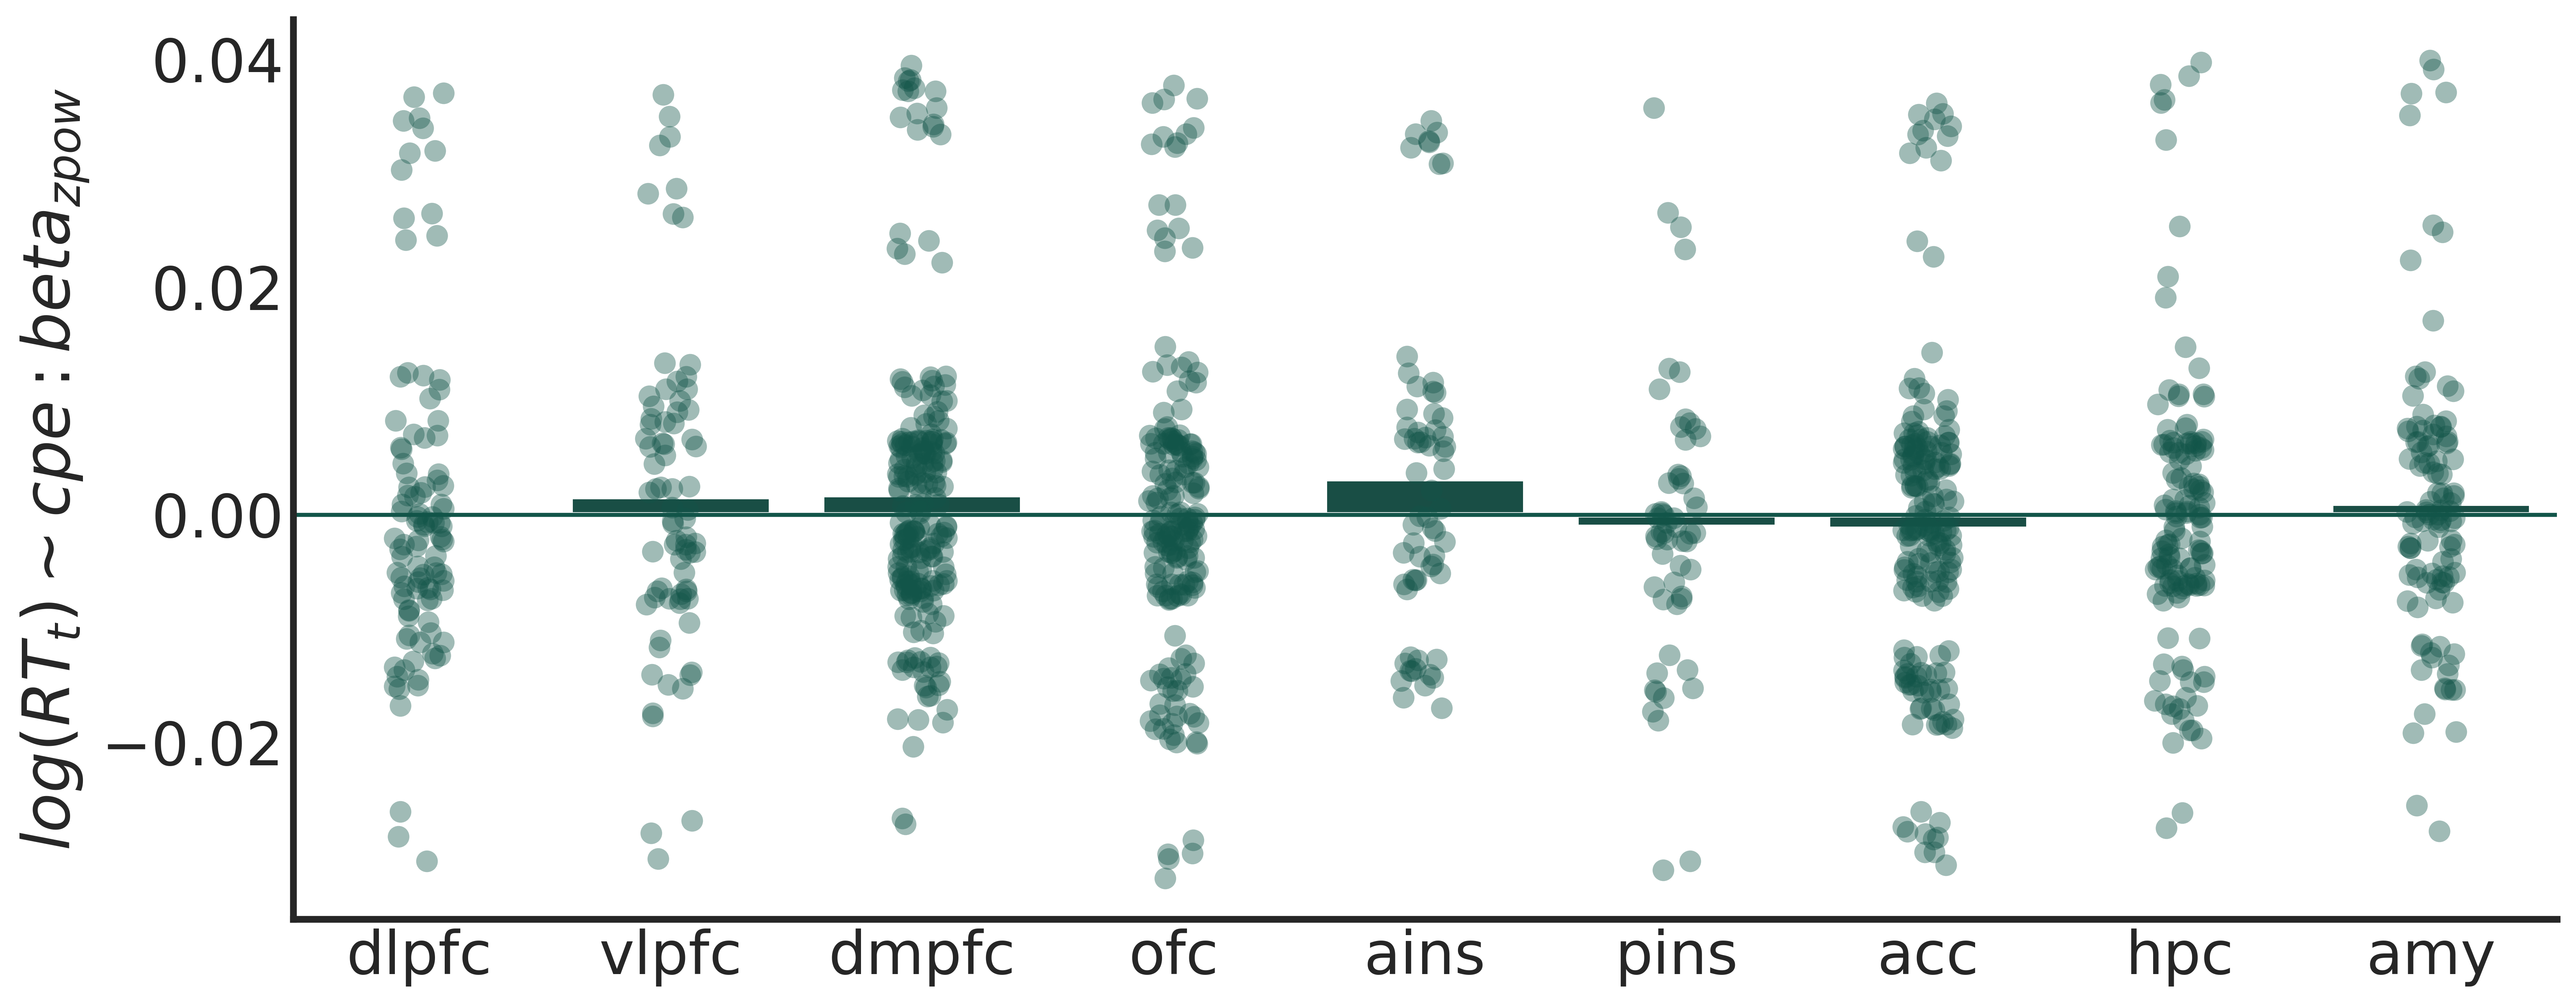

In [455]:
sns.set_context("poster")
fig,ax = plt.subplots(figsize=(15, 6),dpi=500)

fig_save_dir = f'{base_dir}ephys_analysis/figs/beta_regressions/'
os.makedirs(fig_save_dir,exist_ok=True)

sns.barplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:band_pow',
#             y='elec_bCPE',
            color = '#125549',
            saturation=0.8,
            order=roi_order,
            errorbar=None) 


sns.stripplot(data = roi_bdi_plot_data,
            x = 'roi',
            y = 'raw_decisionCPE:band_pow',                          
#               y='elec_bCPE',
              color = '#125549',
              alpha=.4,
              dodge=True,
              order=roi_order,
              size = 8)

ax.axhline(y=0,color='#125549',linewidth=1.5)
plt.tick_params(length=0 )#,grid_linewidth=1)

# plt.ylim([-0.02,0.017])
ax.set(xlabel=None)

# plt.ylabel(r'$beta_{{{zpow}}} \sim cpe:bdi$')
plt.ylabel(r'$log(RT_t) \sim cpe:beta_{{{zpow}}}$')

# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) 
plt.locator_params(axis='y', nbins=6,tight=True)



sns.despine()
    
plt.savefig(f'{fig_save_dir}/rt_interactionbetas{date}.pdf', format='pdf', metadata=None,
bbox_inches=None, pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [344]:
roi_bdi_plot_data


subj_id reref_ch_names      unique_reref_ch  raw_Group  raw_TrialEV  \
0      DA023      lac1-lac2      DA023_lac1-lac2  -0.122865     0.016991   
1      DA023    lac10-lac11    DA023_lac10-lac11  -0.122298     0.010300   
2      DA023      lac2-lac3      DA023_lac2-lac3  -0.122216     0.013408   
3      DA023      lac3-lac4      DA023_lac3-lac4  -0.122195     0.008440   
4      DA023      lac4-lac5      DA023_lac4-lac5  -0.122260     0.013602   
...      ...            ...                  ...        ...          ...   
1568   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.250736    -0.003551   
1569   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.250860    -0.003312   
1570   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.250836    -0.001055   
1571   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.250071    -0.001913   
1572   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.251108    -0.003842   

      raw_decisionCPE  raw_band_pow  raw_decisionCPE:band_pow    roi  bdi  \
0            0.009954      0.027410                  0.008661    acc   14   
1            0.012194      0.001426                  0.010463  dmpfc   14   
2            0.010237      0.015650                  0.008691    acc   14   
3            0.010127      0.000503                  0.008189    acc   14   
4            0.009143      0.018809                  0.007573  dmpfc   14   
...               ...           ...                       ...    ...  ...   
1568        -0.004946      0.003796                  0.000049    ofc    9   
1569        -0.006836      0.008972                 -0.001873    ofc    9   
1570        -0.007413      0.017325                 -0.002287    ofc    9   
1571        -0.008782      0.017860                 -0.003784    ofc    9   
1572        -0.005302      0.003735                 -0.000330  vlpfc    9   

       elec_b0  elec_bCPE  
0     0.899426   0.032667  
1     0.899993   0.034470  
2     0.900074   0.032697  
3     0.900096   0.032196  
4     0.900030   0.031579  
...        ...        ...  
1568  1.273027   0.024055  
1569  1.273151   0.022133  
1570  1.273126   0.021719  
1571  1.272361   0.020222  
1572  1.273399   0.023677  

[1144 rows x 12 columns]

In [ ]:
raw_decisionCPE:band_pow

In [347]:
roi_bdi_plot_data[roi_bdi_plot_data.roi==roi]

subj_id   reref_ch_names        unique_reref_ch  raw_Group  raw_TrialEV  \
125    MS002    laims1-laims2    MS002_laims1-laims2  -0.291547     0.022281   
130    MS002    laims2-laims3    MS002_laims2-laims3  -0.291407     0.021431   
131    MS002    laims3-laims4    MS002_laims3-laims4  -0.291575     0.022226   
132    MS002    laims4-laims5    MS002_laims4-laims5  -0.291987     0.024731   
133    MS002    laims5-laims6    MS002_laims5-laims6  -0.291807     0.029057   
...      ...              ...                    ...        ...          ...   
1509   MS050  lainss4-lainss5  MS050_lainss4-lainss5   0.252810    -0.010215   
1510   MS050  lainss5-lainss6  MS050_lainss5-lainss6   0.251481    -0.005214   
1544   MS050  rainss1-rainss2  MS050_rainss1-rainss2   0.251143    -0.007472   
1547   MS050  rainss2-rainss3  MS050_rainss2-rainss3   0.251206    -0.005107   
1548   MS050  rainss3-rainss4  MS050_rainss3-rainss4   0.251448    -0.003567   

      raw_decisionCPE  raw_band_pow  raw_decisionCPE:band_pow   roi  bdi  \
125          0.016104      0.027022                  0.011614  ains   14   
130          0.013880      0.029608                  0.009265  ains   14   
131          0.015254      0.028846                  0.010734  ains   14   
132          0.013268      0.041261                  0.008875  ains   14   
133          0.016404      0.047320                  0.012440  ains   14   
...               ...           ...                       ...   ...  ...   
1509        -0.004009     -0.019034                  0.000535  ains    9   
1510        -0.005732      0.000489                 -0.000877  ains    9   
1544        -0.006072     -0.005720                 -0.001413  ains    9   
1547        -0.008454      0.007201                 -0.003672  ains    9   
1548        -0.007401      0.009509                 -0.002464  ains    9   

       elec_b0  elec_bCPE  
125   0.730743   0.035620  
130   0.730884   0.033271  
131   0.730716   0.034741  
132   0.730303   0.032881  
133   0.730483   0.036447  
...        ...        ...  
1509  1.275101   0.024541  
1510  1.273771   0.023129  
1544  1.273434   0.022593  
1547  1.273497   0.020335  
1548  1.273739   0.021542  

[64 rows x 12 columns]

In [351]:
rho_data = []
for roi in roi_bdi_plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = roi_bdi_plot_data[roi_bdi_plot_data.roi==roi]
    rho,rho_p = pearsonr(roi_temp_data.bdi,roi_temp_data['raw_decisionCPE:band_pow'])
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
rho_data = pd.concat(rho_data).reset_index(drop=True)

In [355]:
rho_data

roi       rho         rho_p
0    acc  0.589044  2.053541e-19
1  dmpfc  0.617073  4.678973e-24
2    hpc  0.463864  1.459953e-08
3    amy  0.605989  2.911238e-12
4  dlpfc  0.642737  3.271566e-13
5   pins  0.464148  2.760949e-04
6    ofc  0.630225  1.193175e-22
7   ains  0.730184  7.564106e-12

In [357]:
rho_data[rho_data.roi=='pins']

roi       rho     rho_p
5  pins  0.464148  0.000276

In [358]:
rho_data['plot_p'] = [0.0001 if roi != 'pins' else 0.0003 for roi in rho_data.roi ]

In [360]:
rho_data['plot_rho'] = np.round(rho_data.rho,2)

In [361]:
rho_data

roi       rho         rho_p  plot_p  plot_rho
0    acc  0.589044  2.053541e-19  0.0001      0.59
1  dmpfc  0.617073  4.678973e-24  0.0001      0.62
2    hpc  0.463864  1.459953e-08  0.0001      0.46
3    amy  0.605989  2.911238e-12  0.0001      0.61
4  dlpfc  0.642737  3.271566e-13  0.0001      0.64
5   pins  0.464148  2.760949e-04  0.0003      0.46
6    ofc  0.630225  1.193175e-22  0.0001      0.63
7   ains  0.730184  7.564106e-12  0.0001      0.73

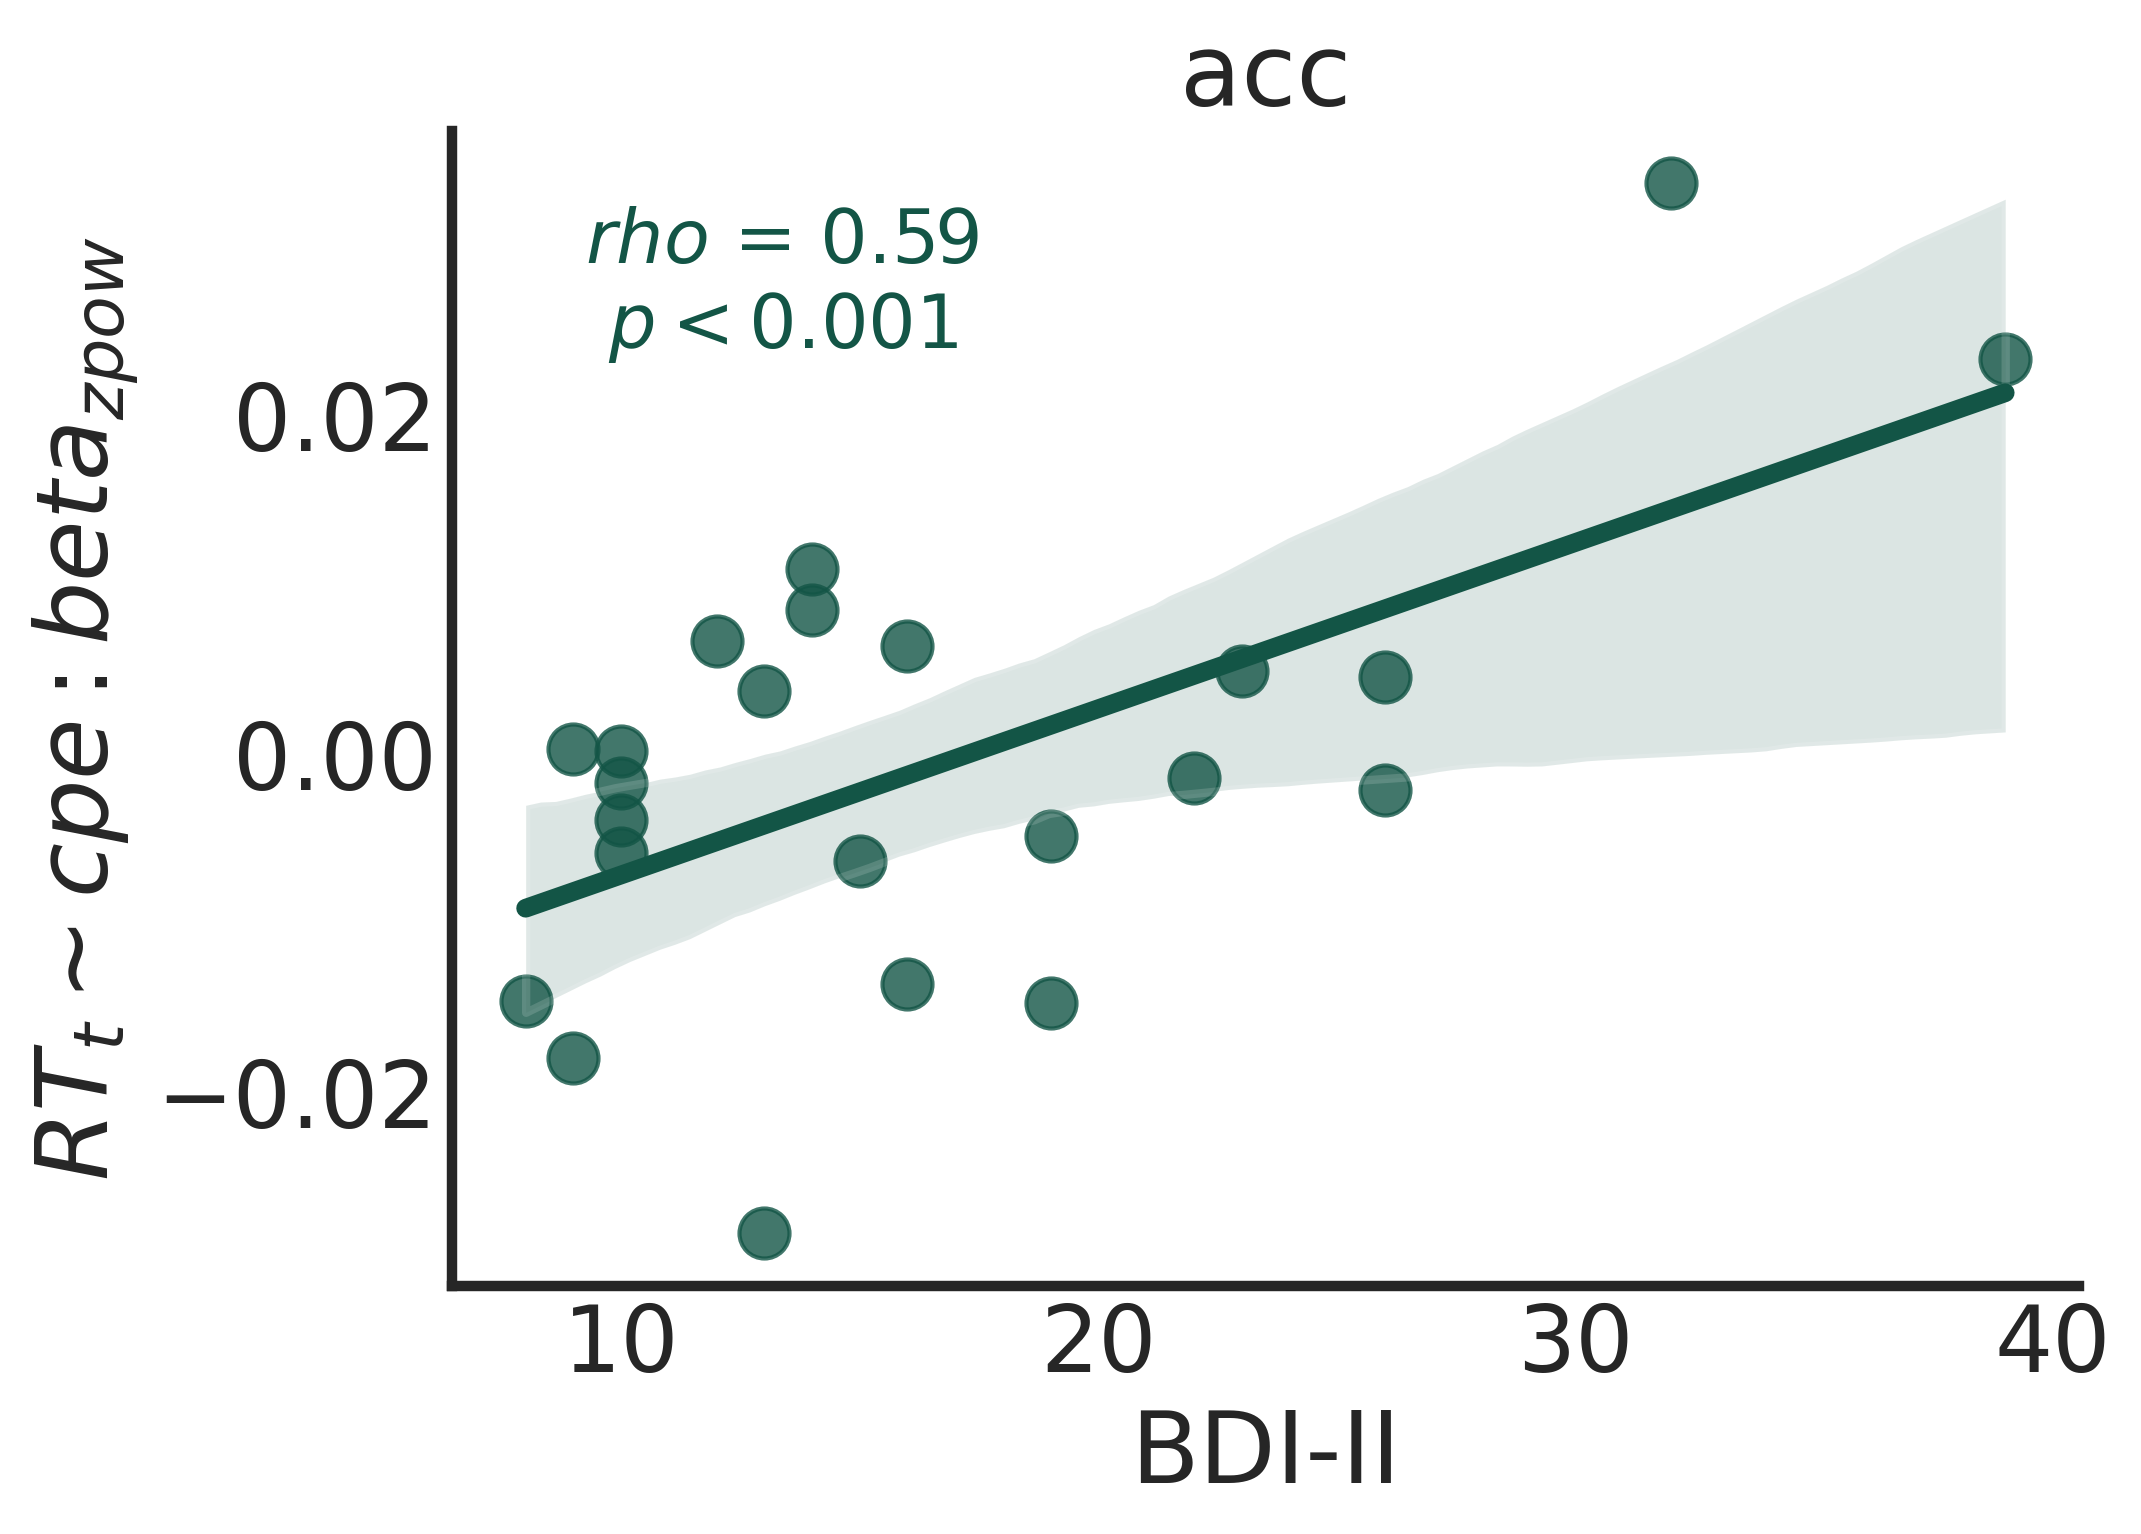

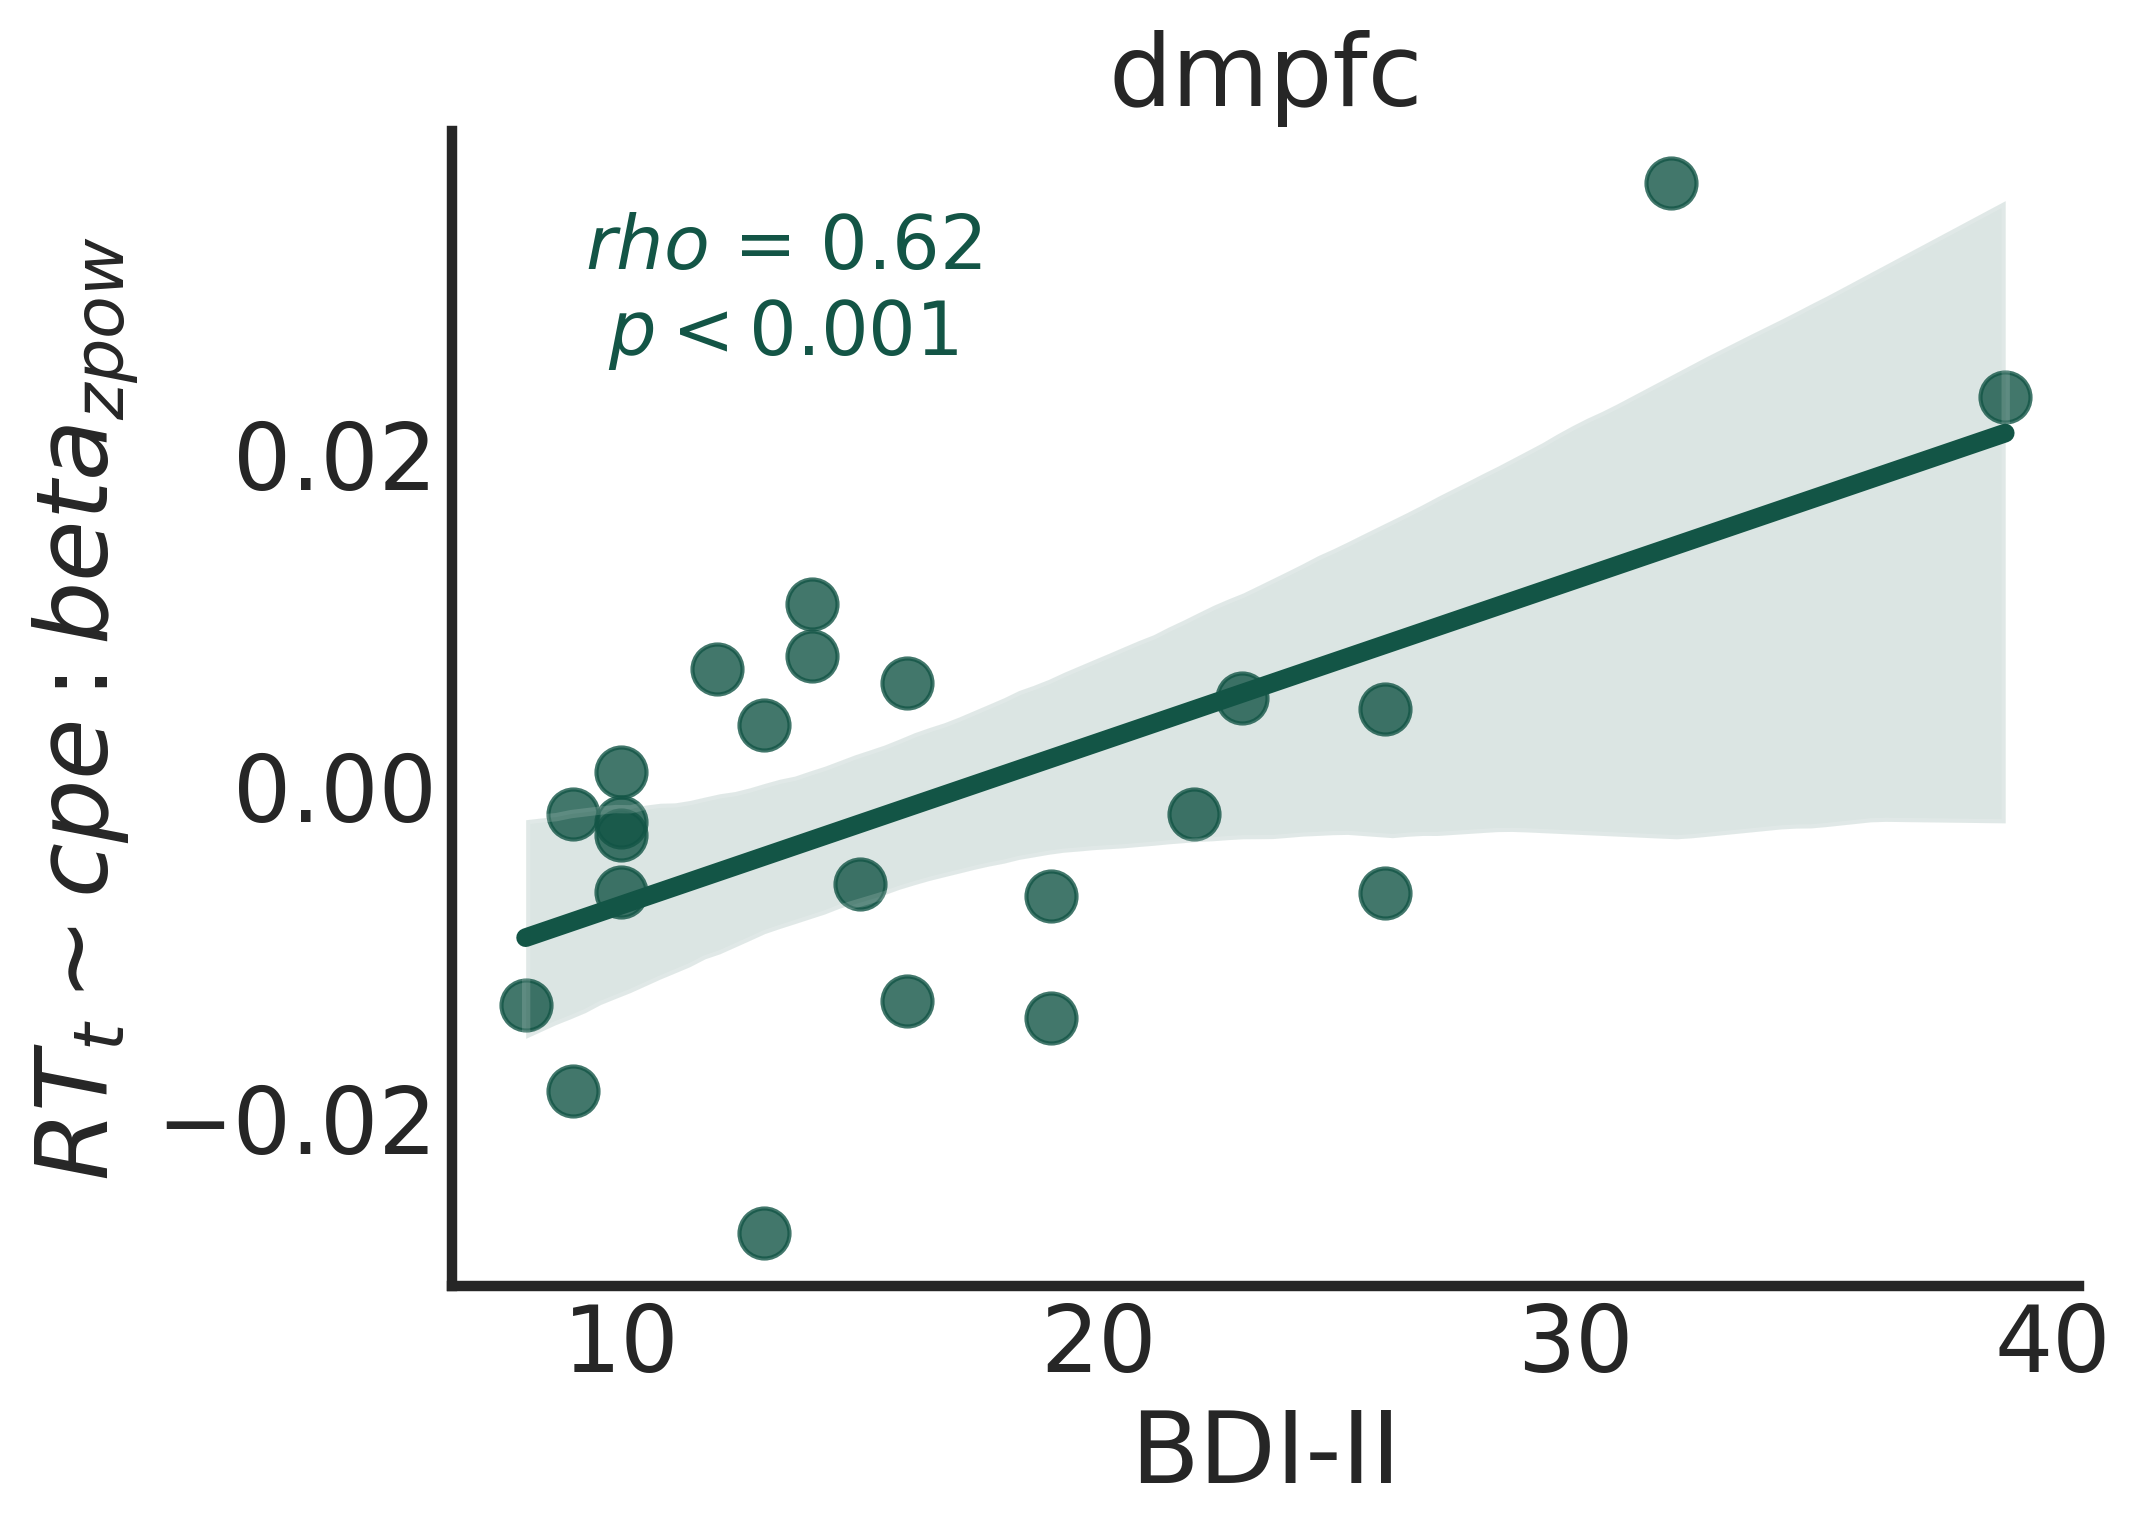

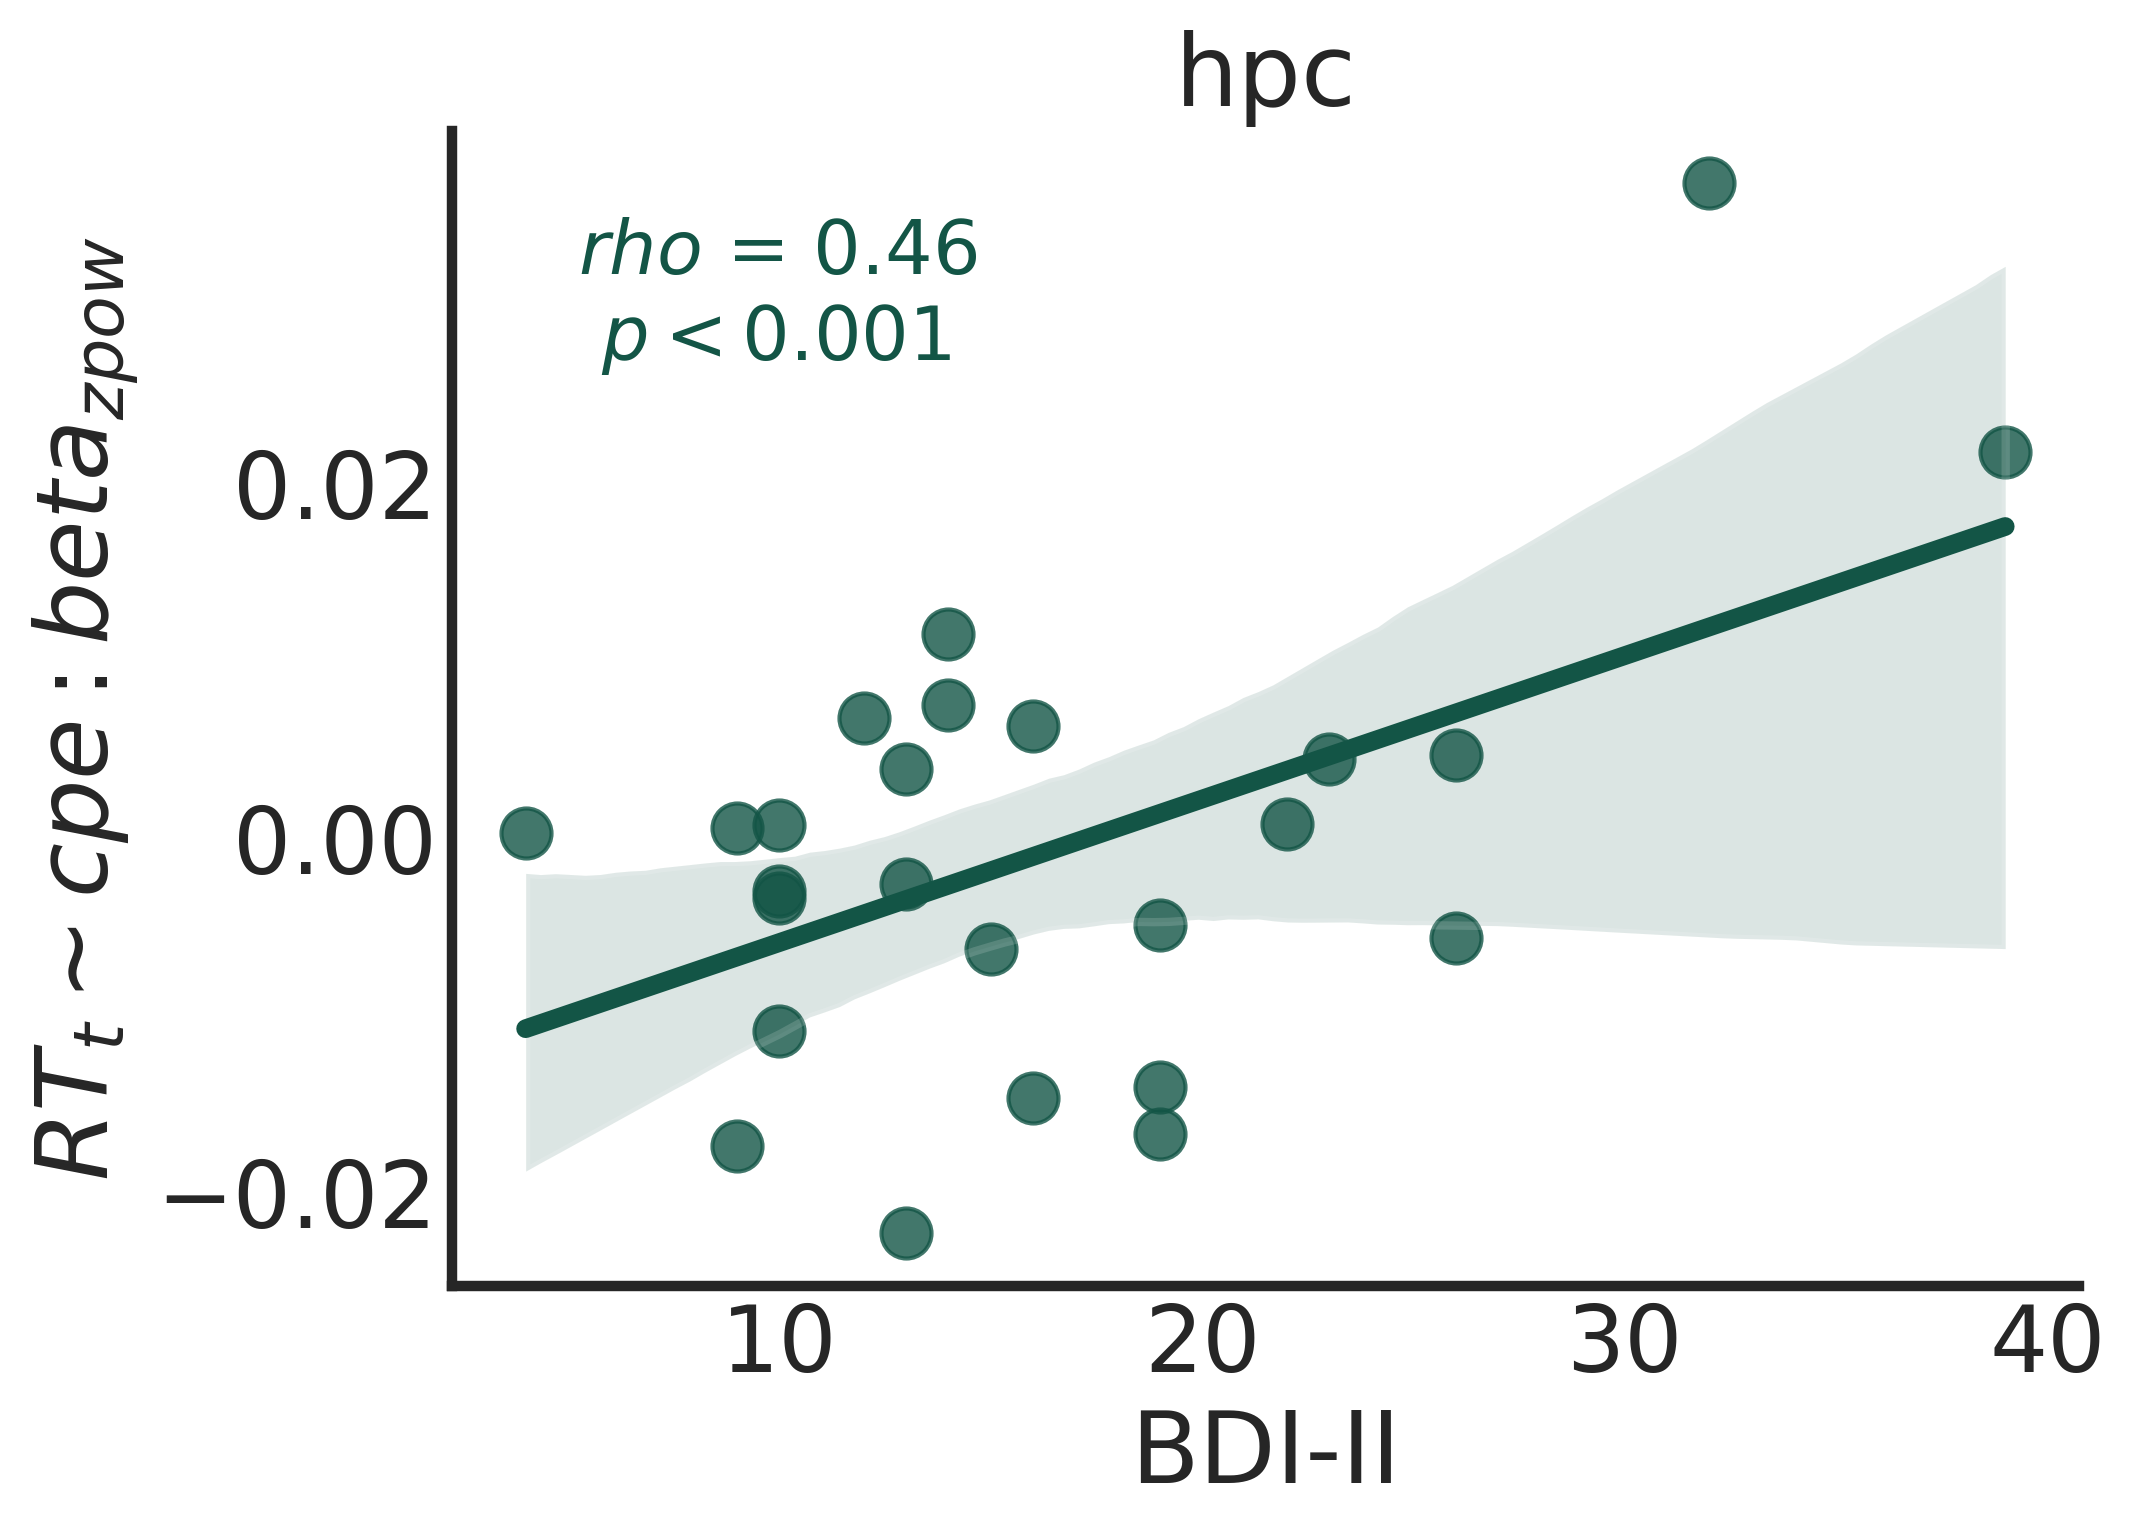

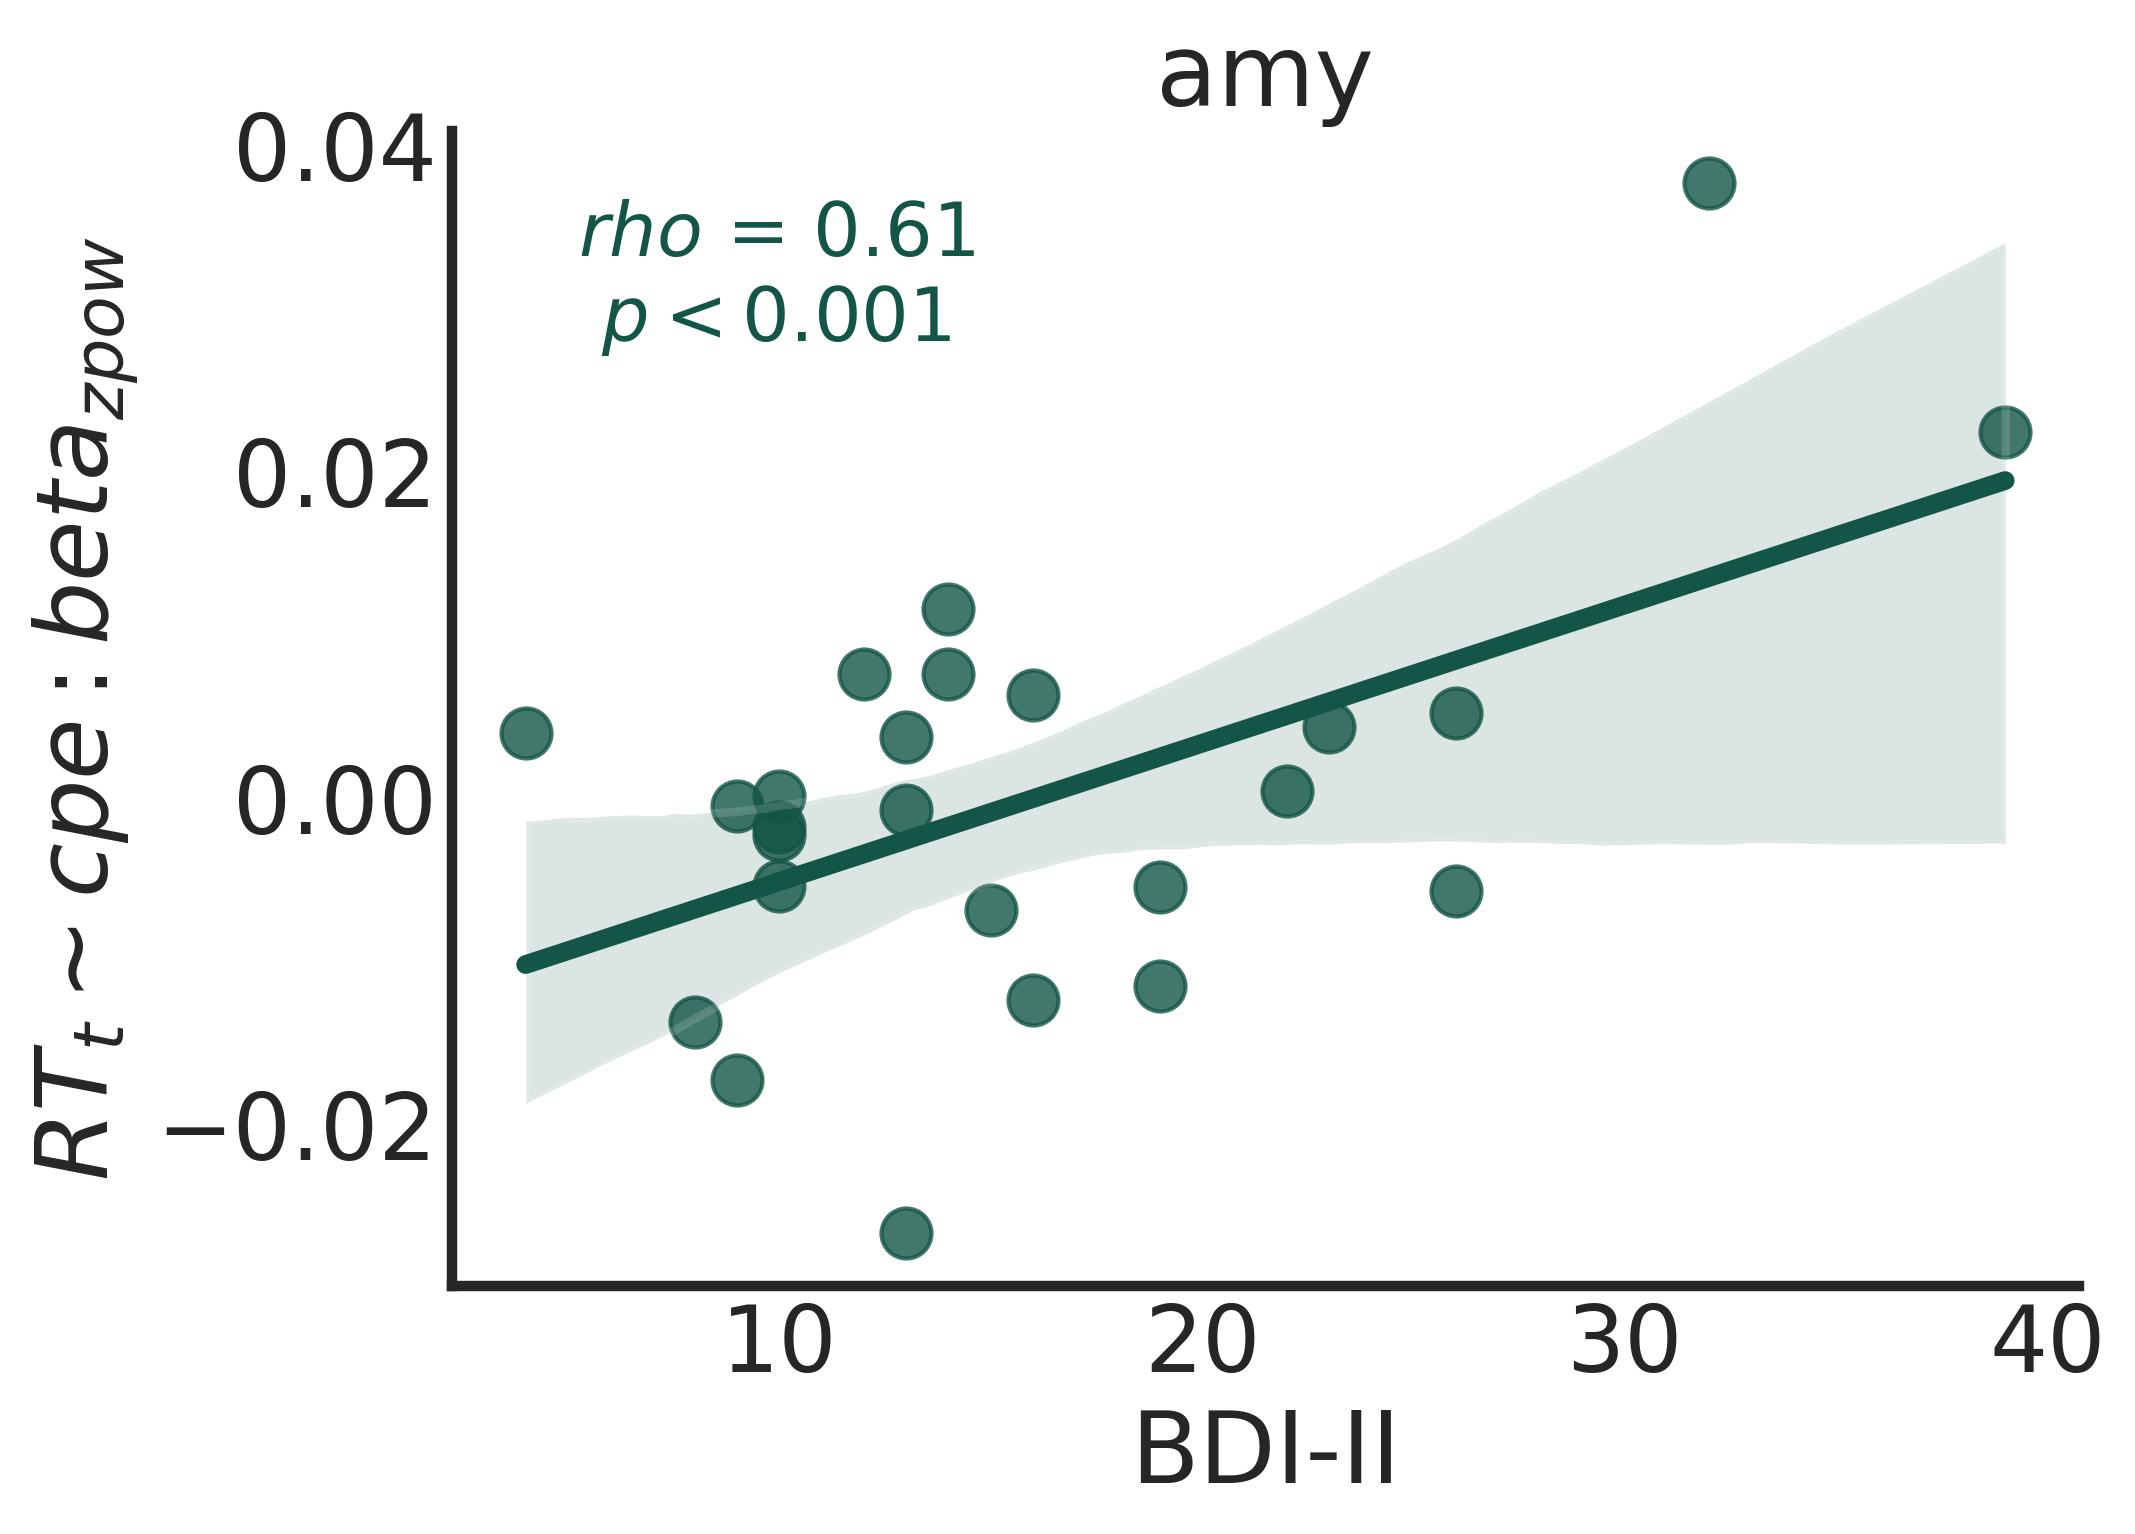

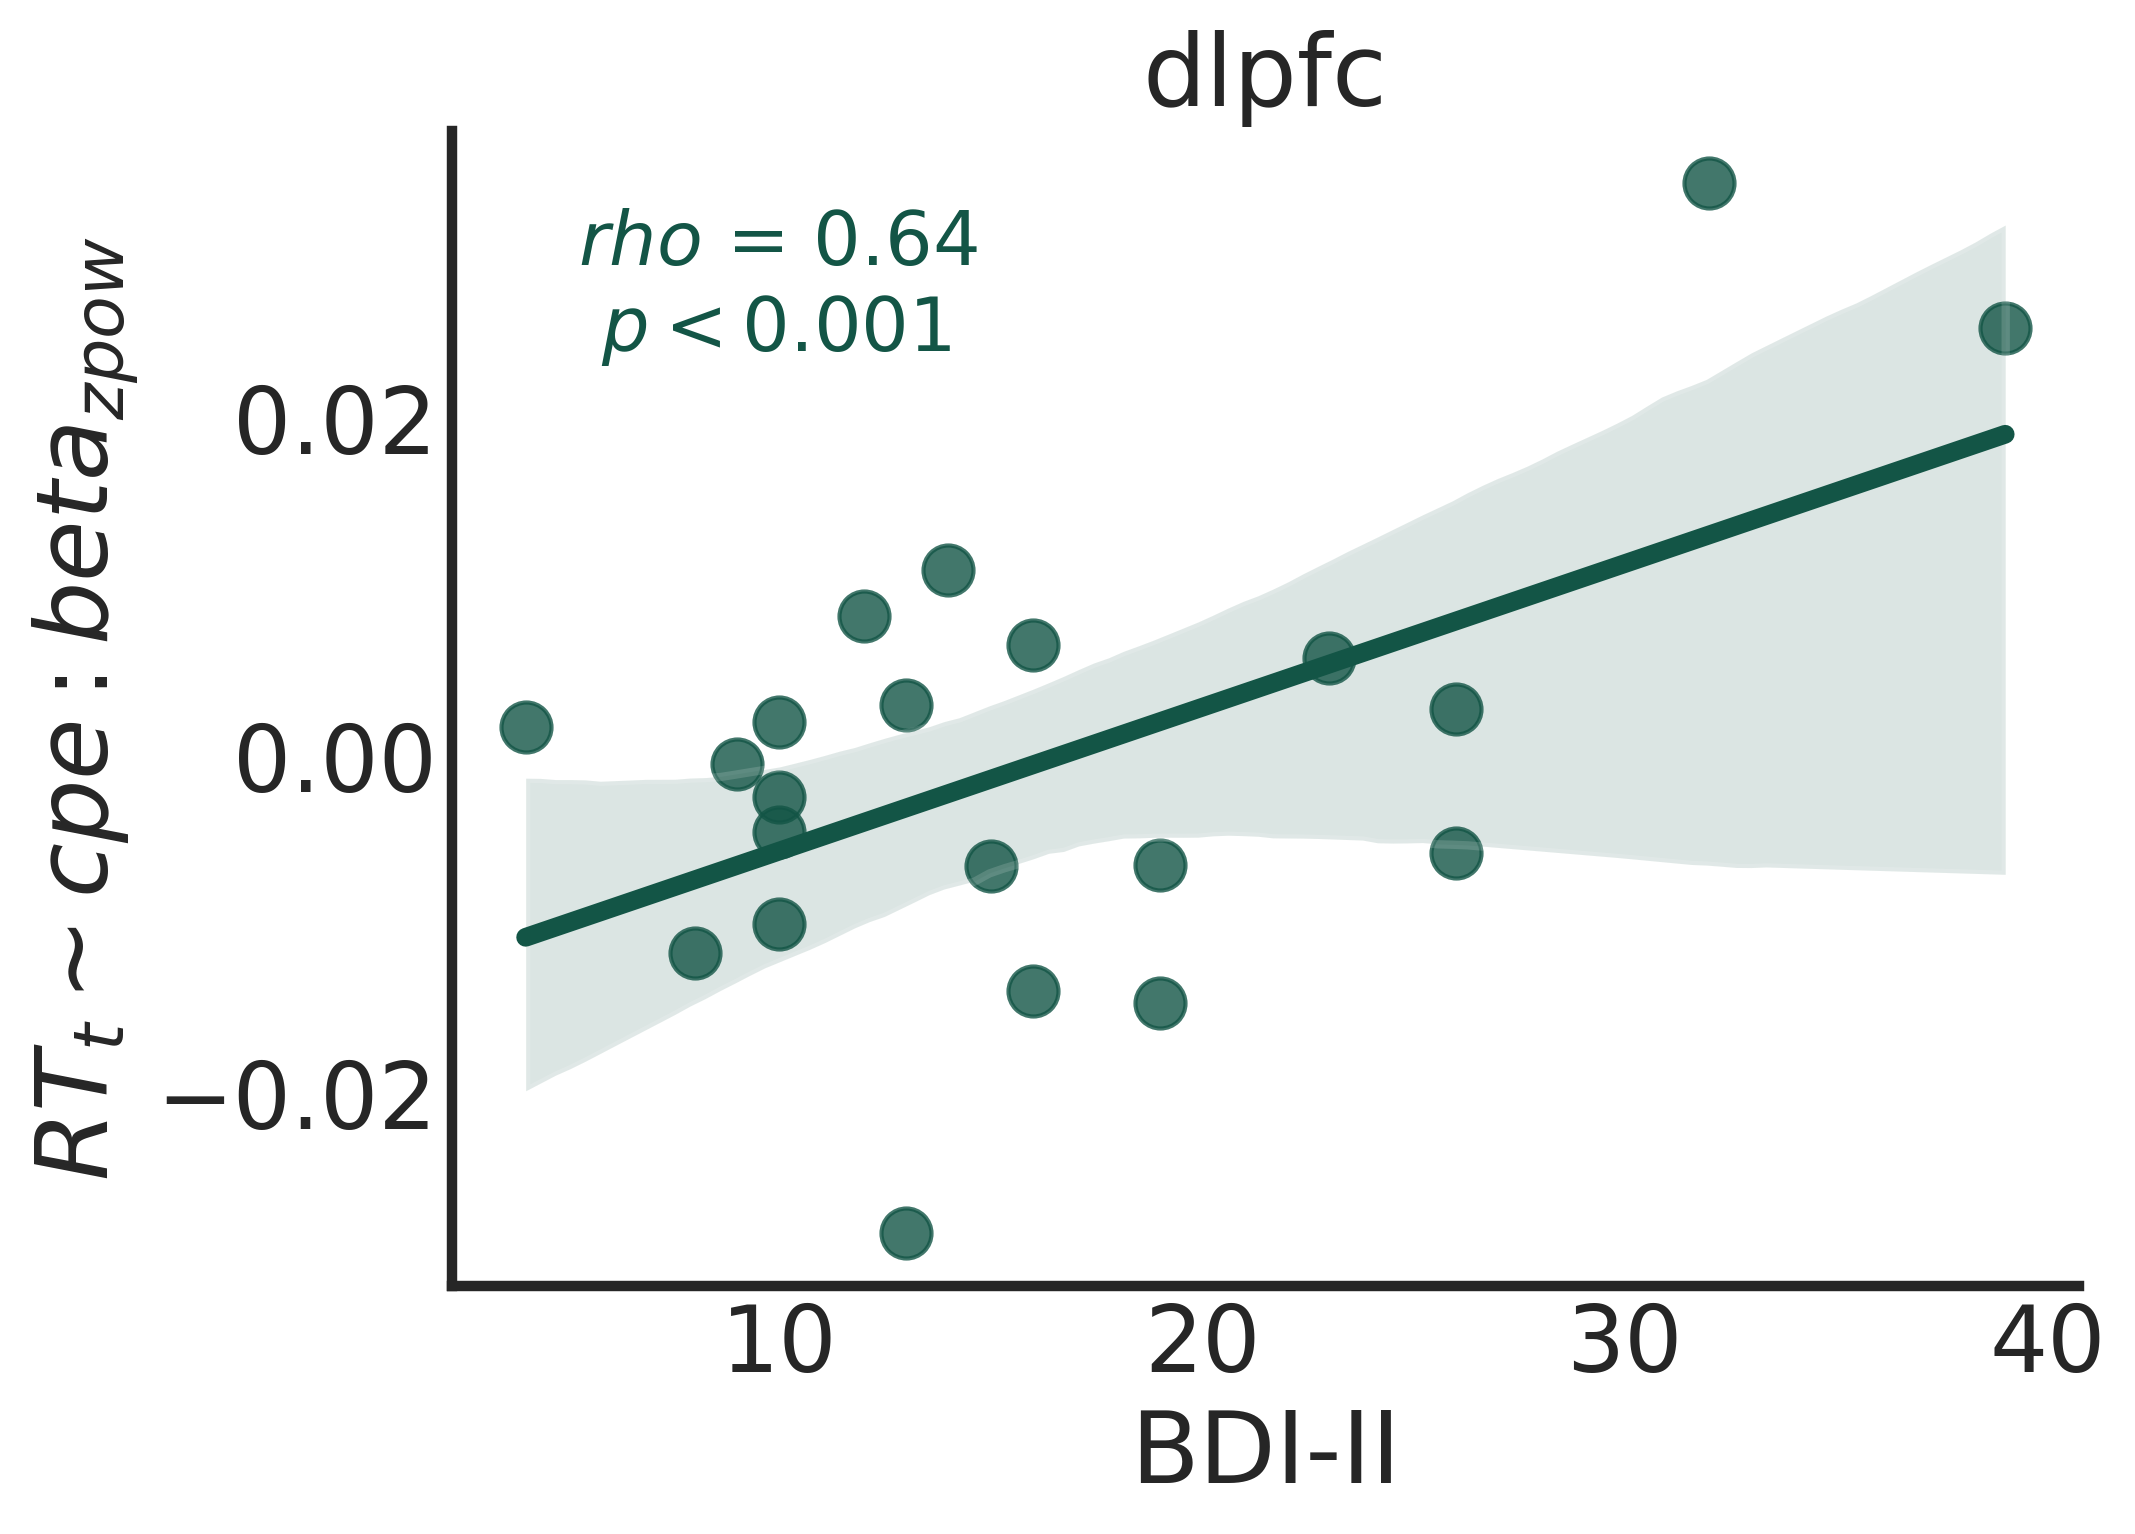

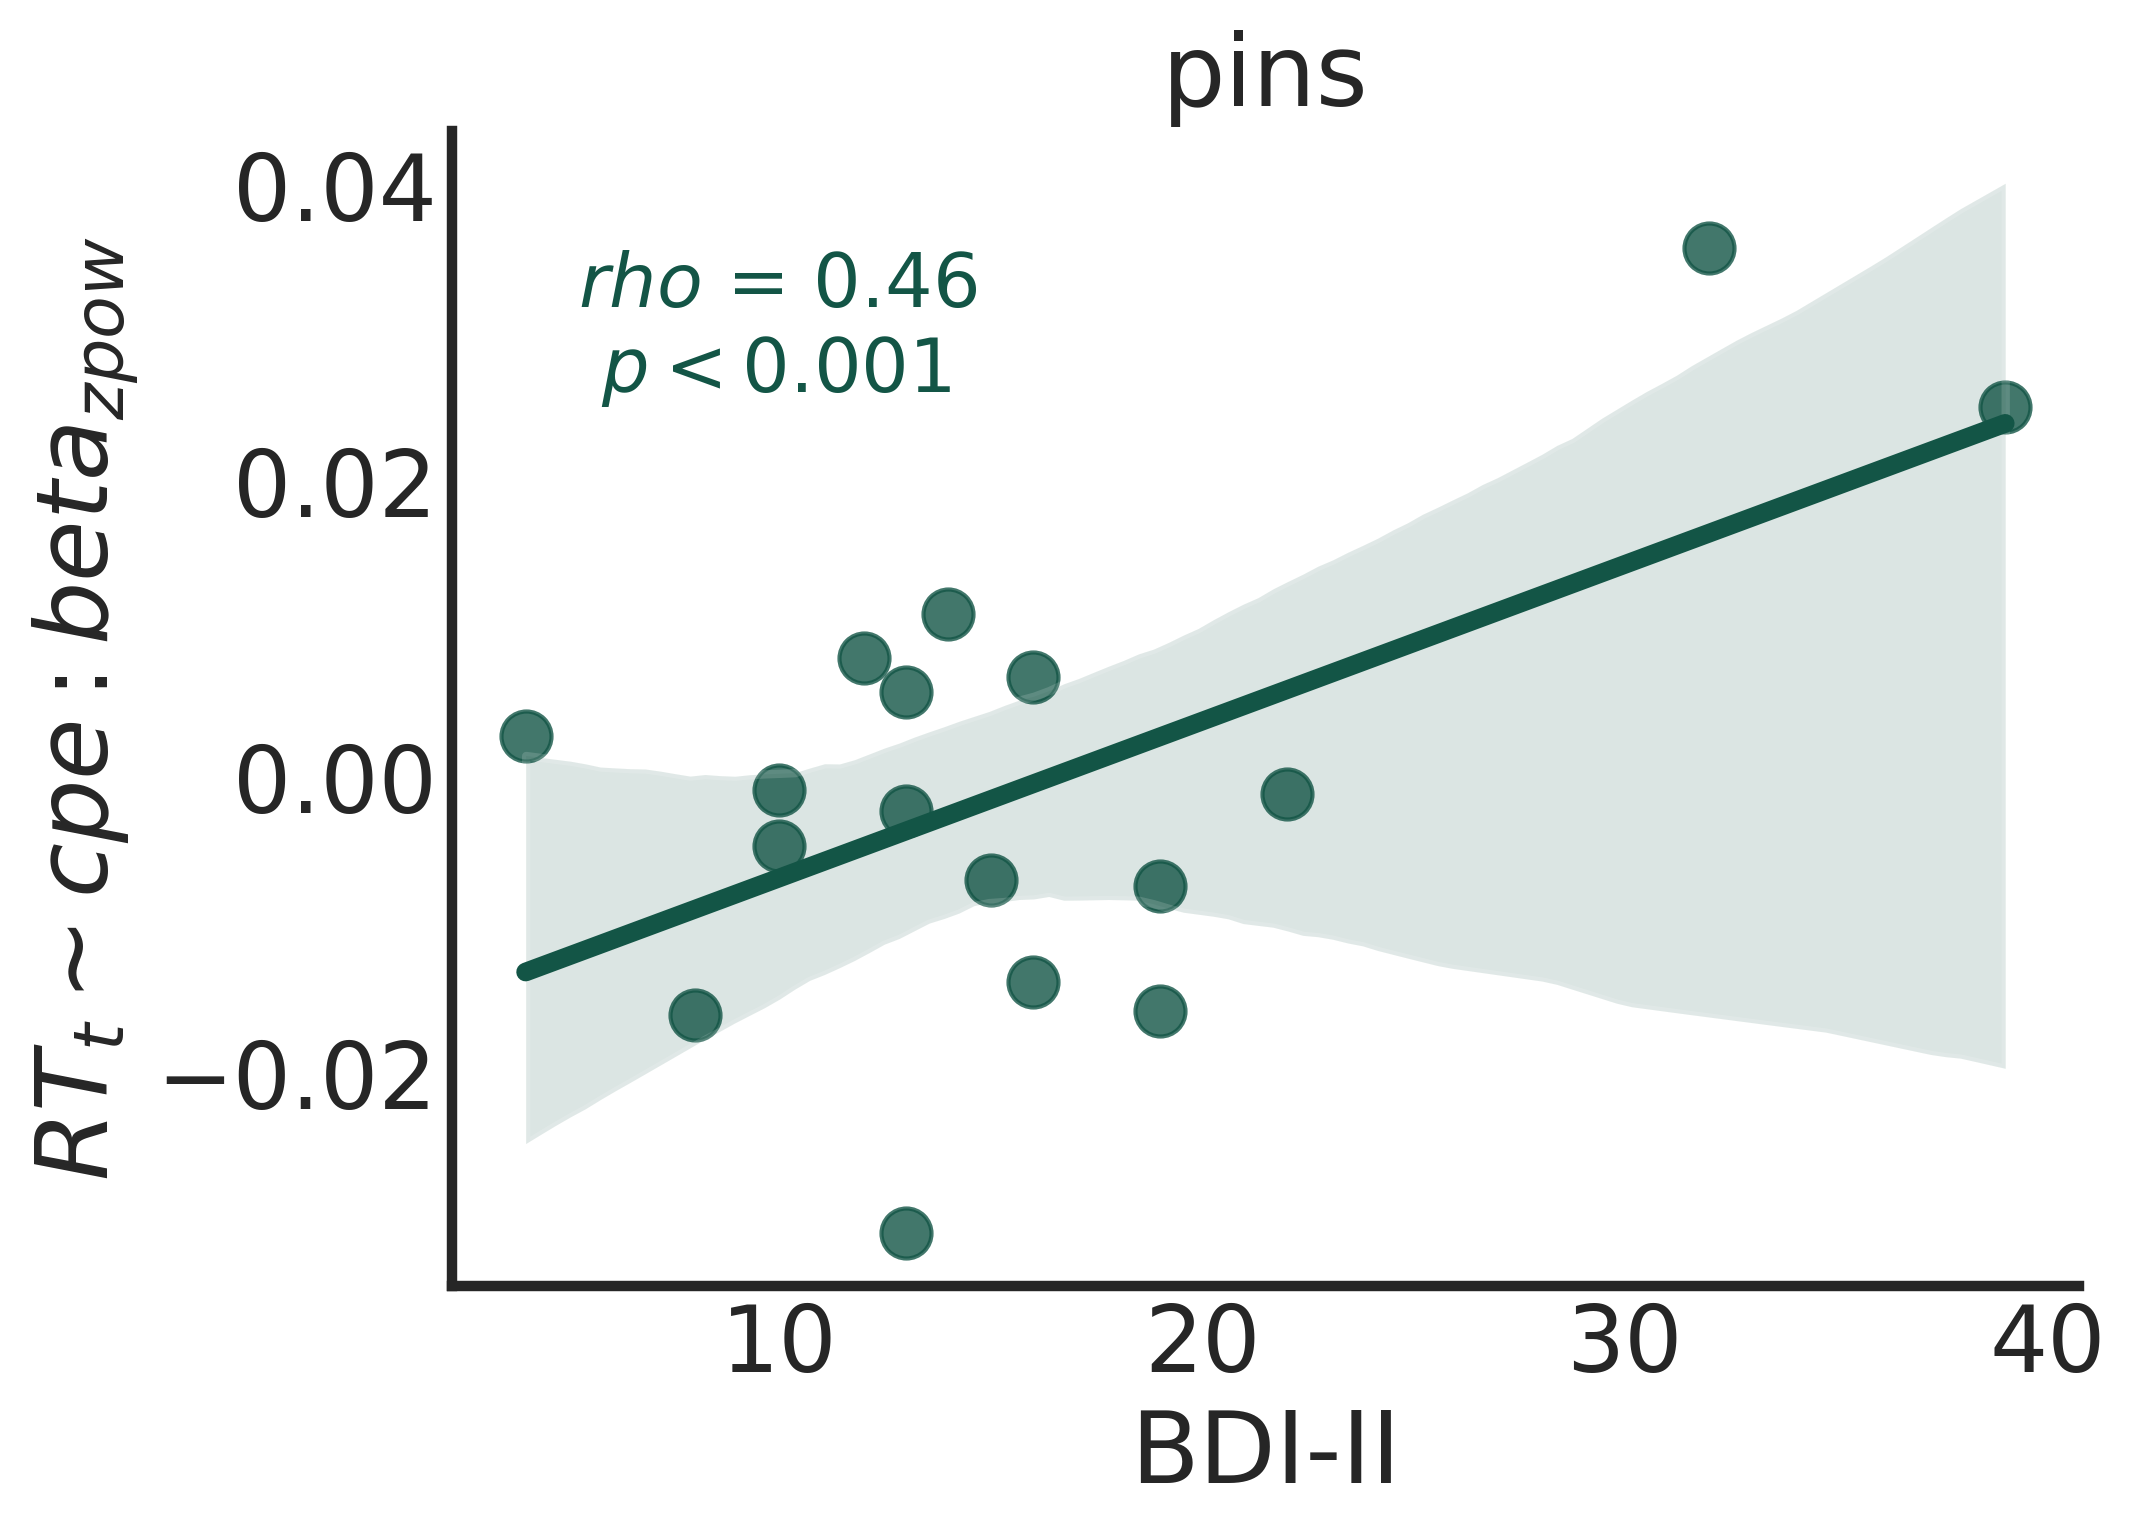

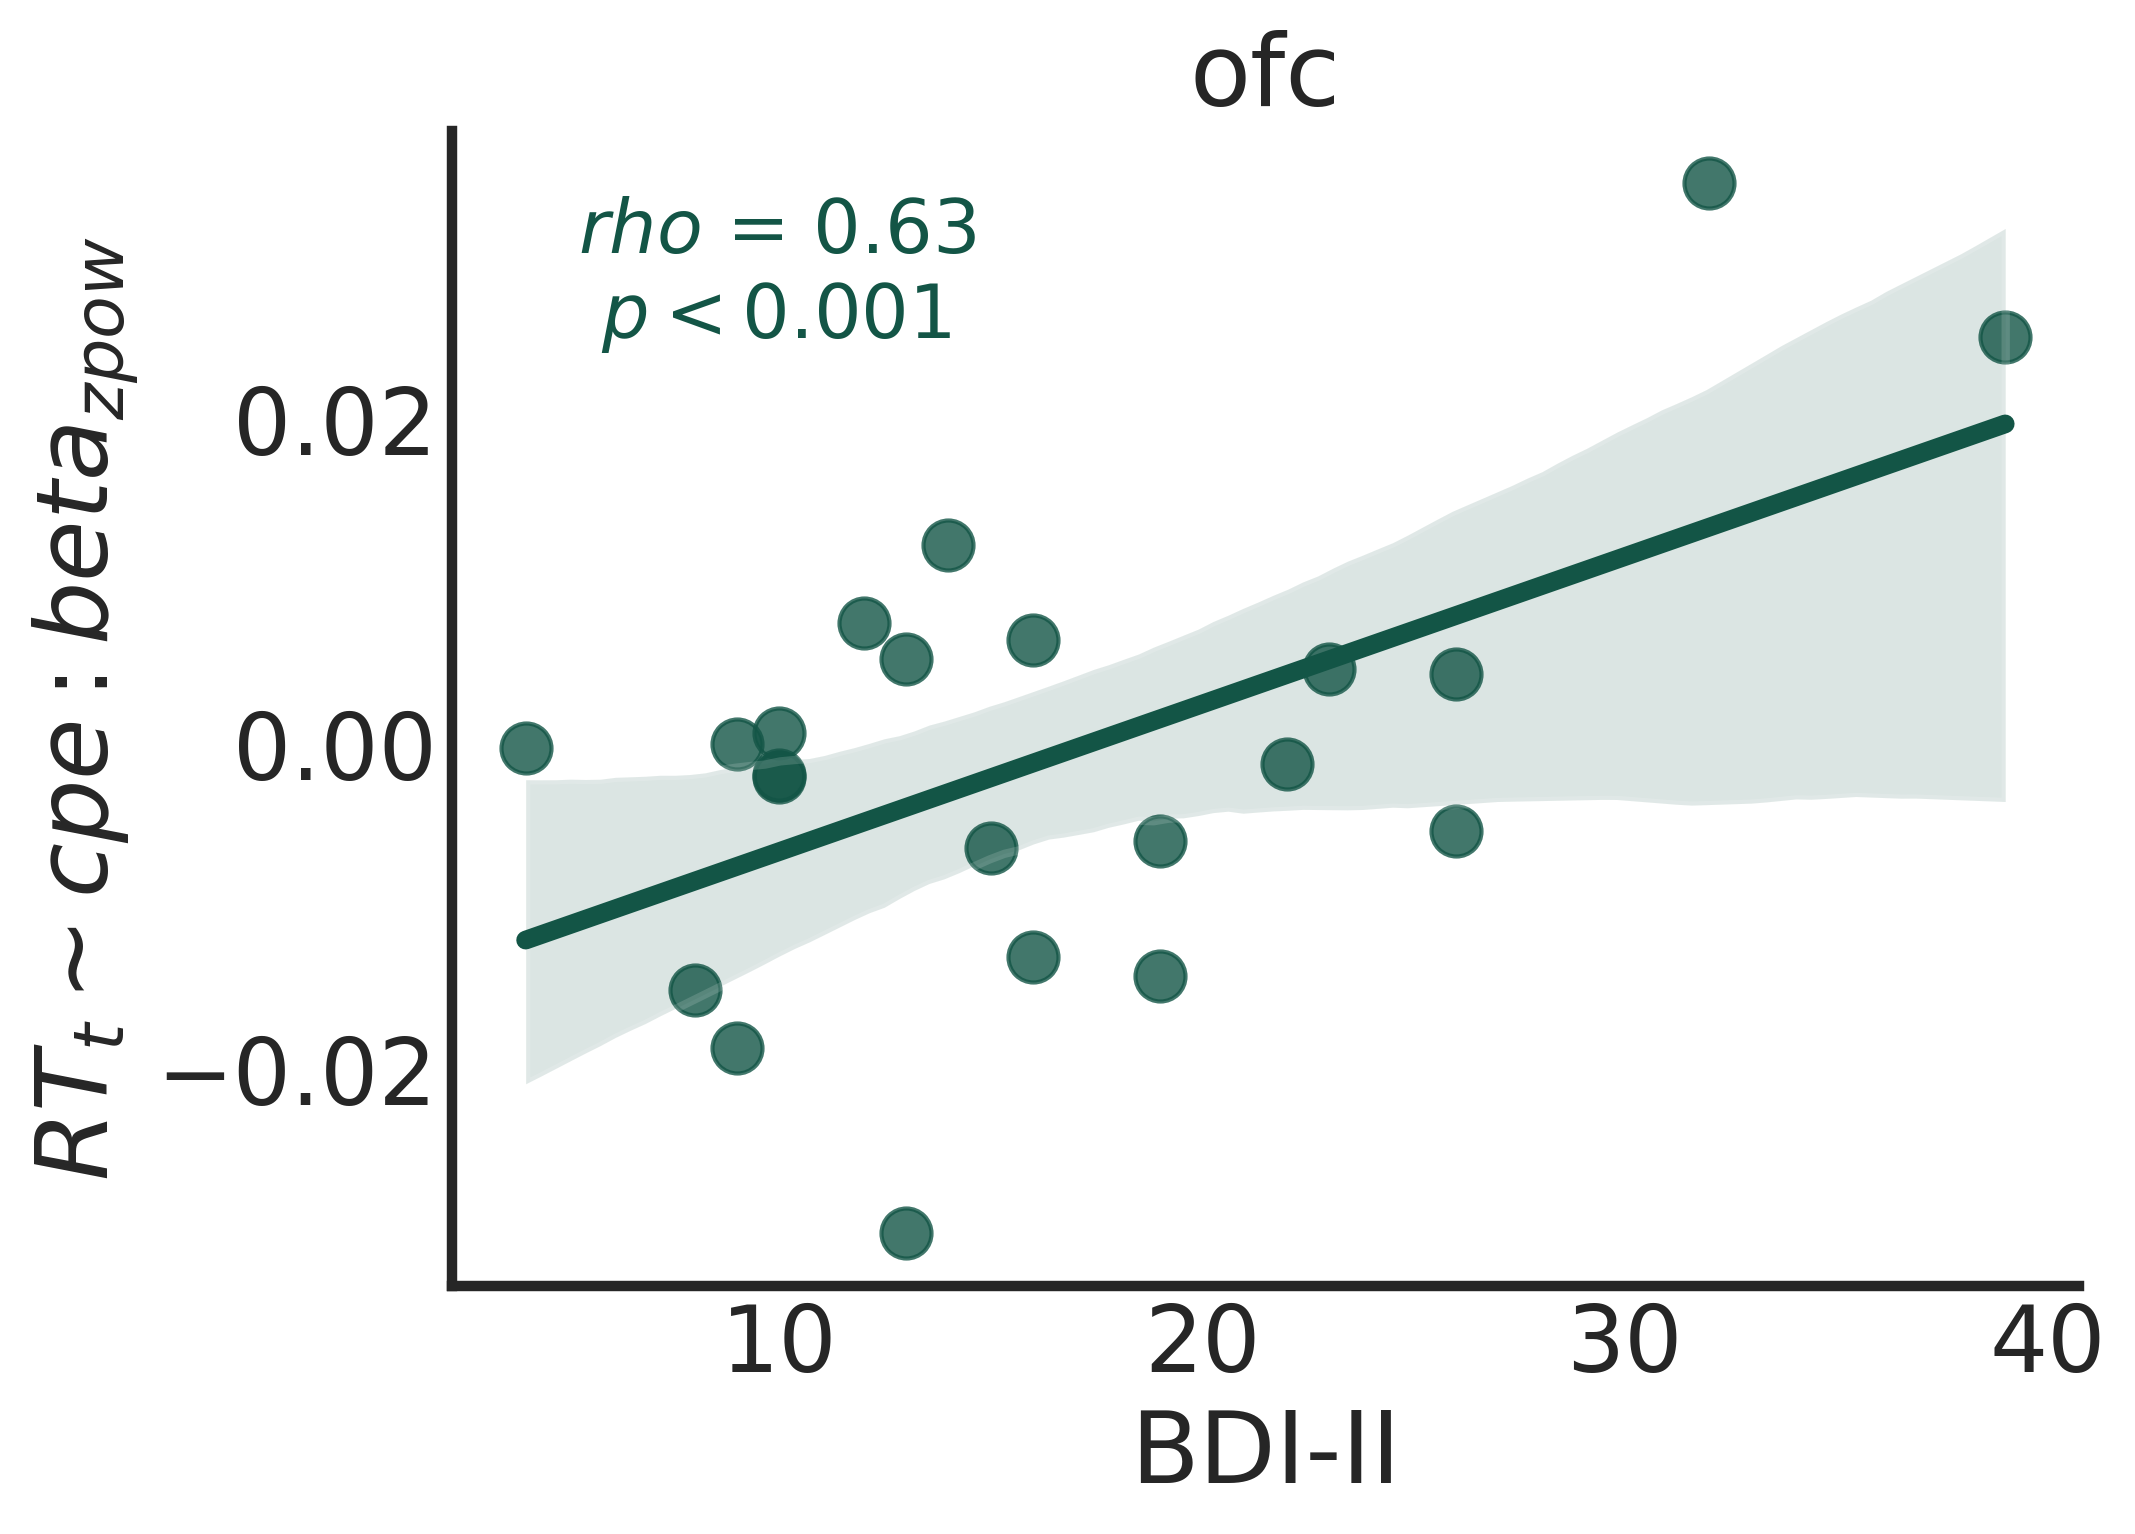

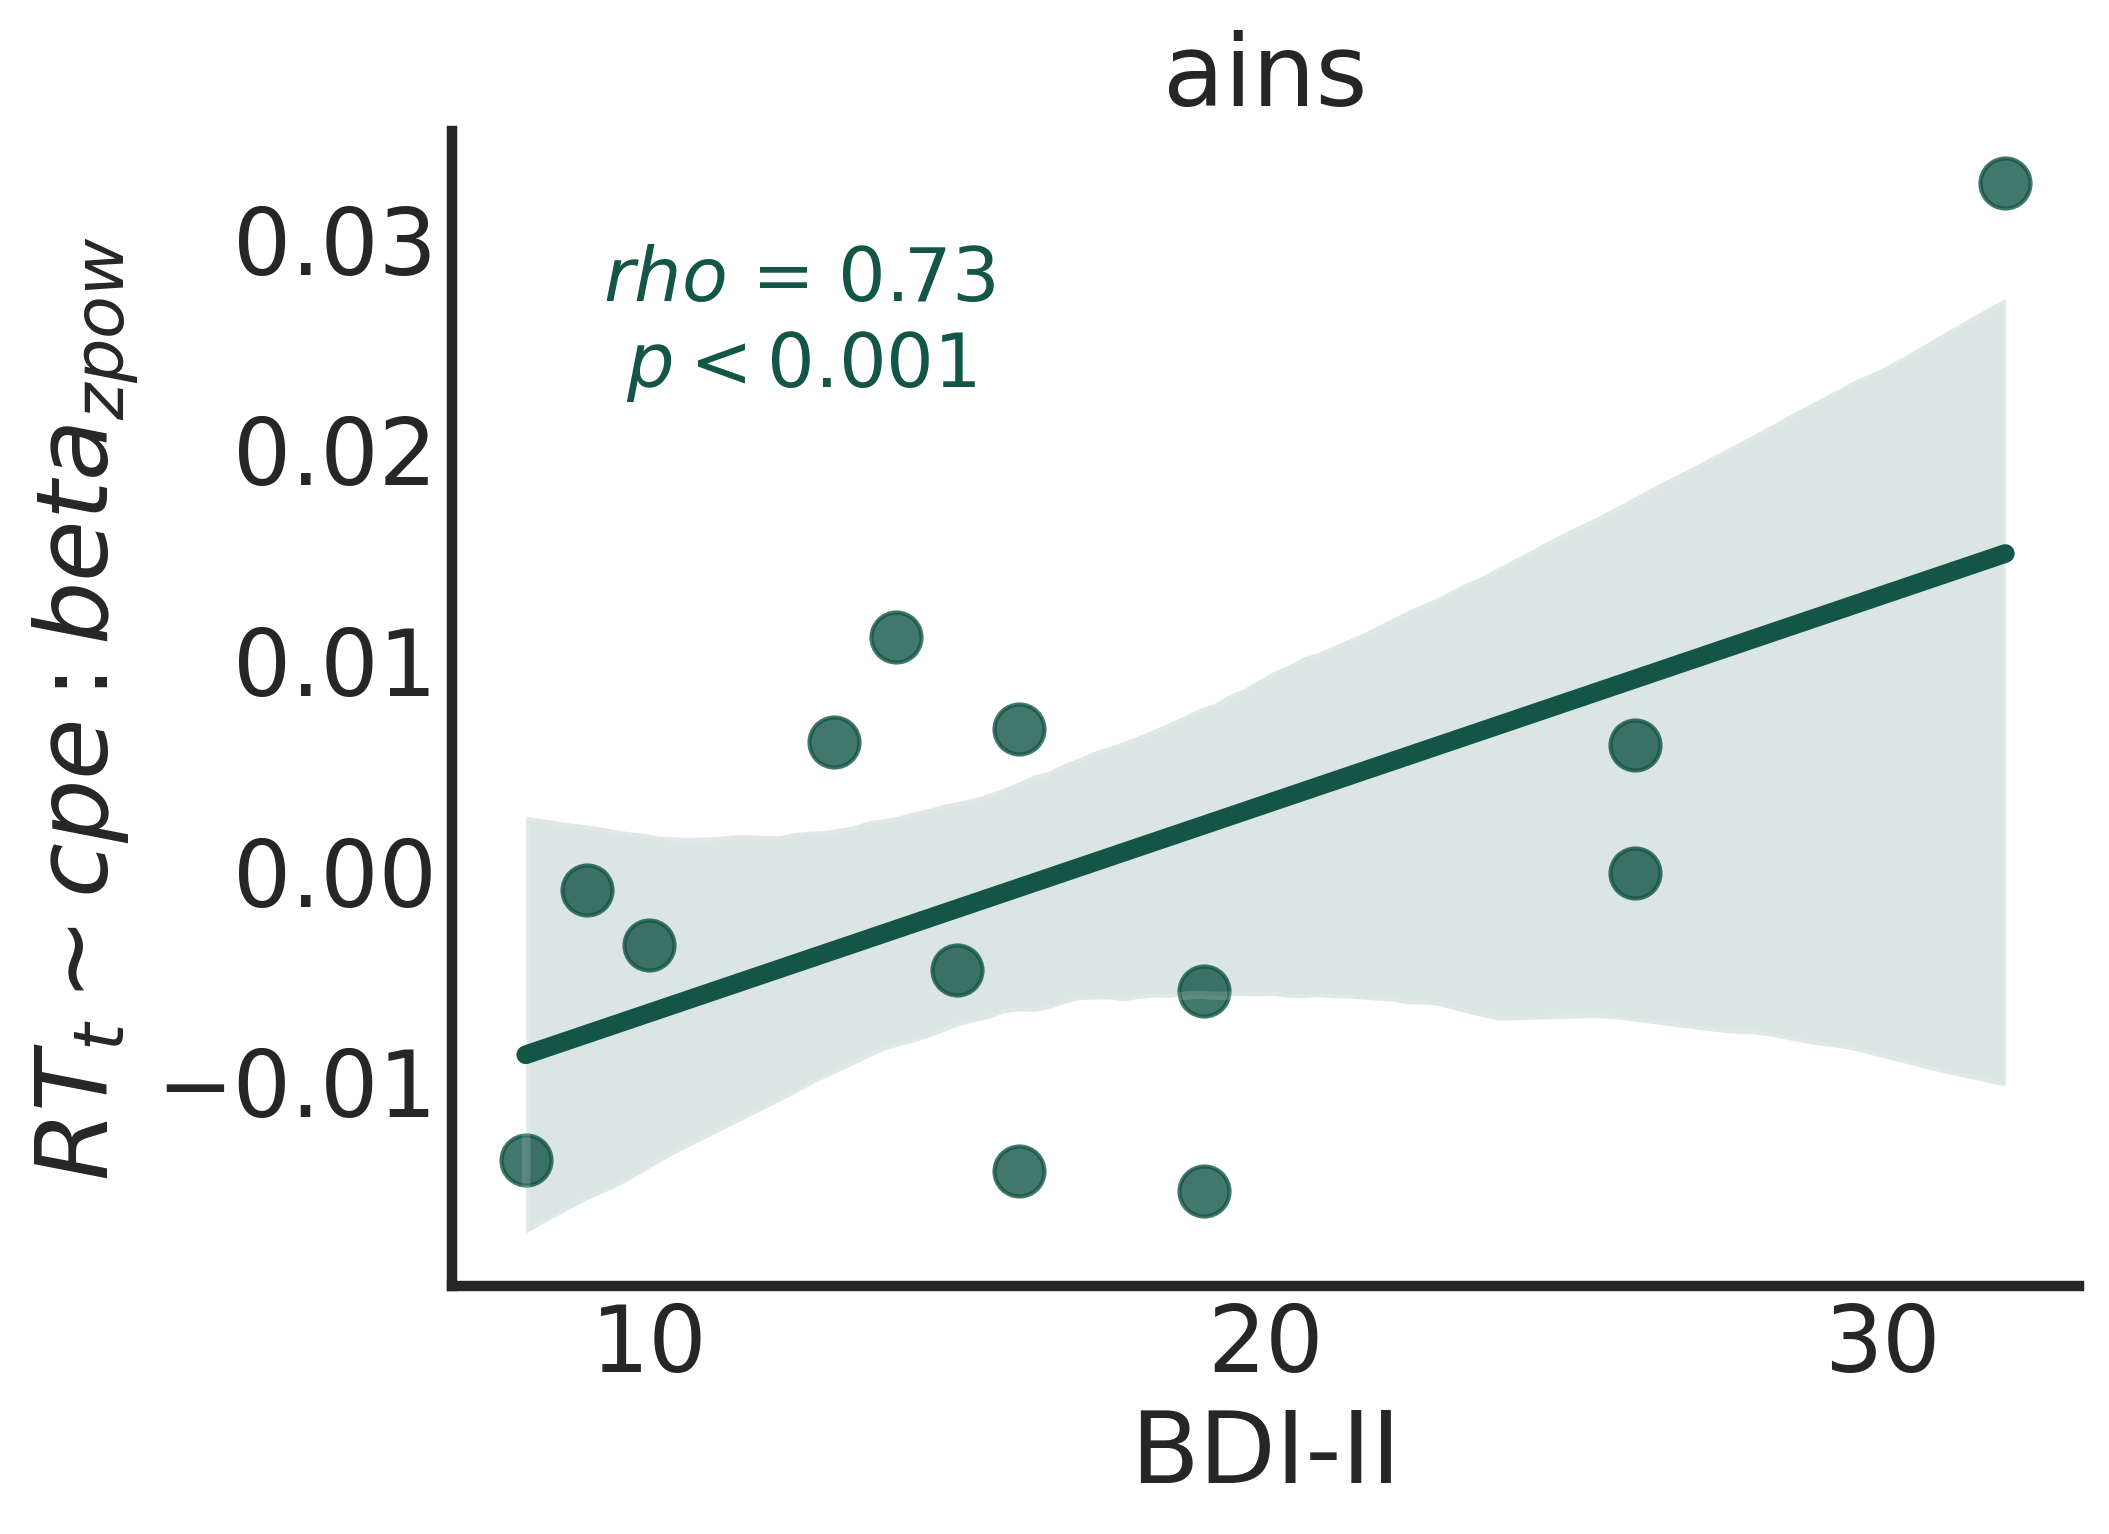

In [463]:

# sns.set_context("poster",rc={'axes.linewidth': 2})

for roi in roi_bdi_plot_data.roi.unique().tolist()[:-1]:
    roi_temp_data = roi_bdi_plot_data[roi_bdi_plot_data.roi==roi]
#     rho,rho_p = pearsonr(roi_temp_data.bdi,roi_temp_data['raw_decisionCPE:band_pow'])

    rho   = rho_data[rho_data.roi == roi].plot_rho.values[0]
    rho_p = rho_data[rho_data.roi == roi].plot_p.values[0]
    
        
    fig = plt.figure(figsize=(7,5),dpi=300)

#     sns.regplot(data=roi_temp_data,x='bdi',y='raw_decisionCPE:band_pow',scatter=False,ci=95,
#                 fit_reg=True,color = '#0b4e5f') #034975 0b4e5f 00467e 3f2755
    
    sns.regplot(data = roi_temp_data.groupby('subj_id').agg('mean'),x='bdi',y='raw_decisionCPE:band_pow'
                ,color='#135546') #0b4e5f #135546  0b4e5f

    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

    plt.xlabel('BDI-II')
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$_{{{zpow}}}$'+' cpe encoding')
    plt.ylabel(r'$RT_t \sim cpe:beta_{{{zpow}}}$')


    plt.text(np.min(roi_temp_data['bdi'])+1.25,
             np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean')[
        'raw_decisionCPE:band_pow']),3)-0.01,
             r'$rho$ = '+f'{rho} '+'\n '+r'$p < 0.001$',
             color='#135546',fontsize=18)
# +f'{np.round(rho_p,3)}',
#     plt.title(f'{roi}',fontsize=24)    

#     plt.text(5, np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean')[
#         'raw_decisionCPE:band_pow']),3)-0.003,
#              r'$rho$ = '+f'{np.round(rho,2)} '+'\n '+r'$p < 0.0001$'
#              color='#0b4e5f',fontsize=16)
# # +f'{np.round(rho_p,3)}',
    
    plt.title(f'{roi}',fontsize=24)


    
    sns.despine()
    
    plt.savefig(f'{fig_save_dir}/rt_cpebeta_bdi_2{roi}_{date}.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

In [373]:
roi_bdi_plot_data

subj_id reref_ch_names      unique_reref_ch  raw_Group  raw_TrialEV  \
0      DA023      lac1-lac2      DA023_lac1-lac2  -0.122865     0.016991   
1      DA023    lac10-lac11    DA023_lac10-lac11  -0.122298     0.010300   
2      DA023      lac2-lac3      DA023_lac2-lac3  -0.122216     0.013408   
3      DA023      lac3-lac4      DA023_lac3-lac4  -0.122195     0.008440   
4      DA023      lac4-lac5      DA023_lac4-lac5  -0.122260     0.013602   
...      ...            ...                  ...        ...          ...   
1568   MS050  rmoif4-rmoif5  MS050_rmoif4-rmoif5   0.250736    -0.003551   
1569   MS050  rmoif5-rmoif6  MS050_rmoif5-rmoif6   0.250860    -0.003312   
1570   MS050  rmoif6-rmoif7  MS050_rmoif6-rmoif7   0.250836    -0.001055   
1571   MS050  rmoif7-rmoif8  MS050_rmoif7-rmoif8   0.250071    -0.001913   
1572   MS050  rmoif8-rmoif9  MS050_rmoif8-rmoif9   0.251108    -0.003842   

      raw_decisionCPE  raw_band_pow  raw_decisionCPE:band_pow    roi  bdi  \
0            0.009954      0.027410                  0.008661    acc   14   
1            0.012194      0.001426                  0.010463  dmpfc   14   
2            0.010237      0.015650                  0.008691    acc   14   
3            0.010127      0.000503                  0.008189    acc   14   
4            0.009143      0.018809                  0.007573  dmpfc   14   
...               ...           ...                       ...    ...  ...   
1568        -0.004946      0.003796                  0.000049    ofc    9   
1569        -0.006836      0.008972                 -0.001873    ofc    9   
1570        -0.007413      0.017325                 -0.002287    ofc    9   
1571        -0.008782      0.017860                 -0.003784    ofc    9   
1572        -0.005302      0.003735                 -0.000330  vlpfc    9   

       elec_b0  elec_bCPE  
0     0.899426   0.032667  
1     0.899993   0.034470  
2     0.900074   0.032697  
3     0.900096   0.032196  
4     0.900030   0.031579  
...        ...        ...  
1568  1.273027   0.024055  
1569  1.273151   0.022133  
1570  1.273126   0.021719  
1571  1.272361   0.020222  
1572  1.273399   0.023677  

[1144 rows x 12 columns]

In [374]:
beta_reg_df['Depressed'] = ['Low BDI' if bdi<20 else 'High BDI' for bdi in beta_reg_df.bdi]
beta_reg_df

subj_id  bdi  epoch       freq reref_ch_names  band_pow  \
0      MS002   14      0  20.743342  lacas1-lacas2 -0.123971   
1      MS002   14      0  20.743342  lacas2-lacas3 -0.186139   
2      MS002   14      0  20.743342  lacas3-lacas4 -0.235353   
3      MS002   14      0  20.743342  lacas4-lacas5 -0.086471   
4      MS002   14      0  20.743342  lacas5-lacas6 -0.145393   
...      ...  ...    ...        ...            ...       ...   
3748   DA037    4    148  20.743342  rpins1-rpins2 -0.832139   
3749   DA037    4    148  20.743342  rpins2-rpins3 -0.831343   
3750   DA037    4    148  20.743342  rpins3-rpins4 -0.251848   
3751   DA037    4    148  20.743342  rpins4-rpins5  0.022261   
3752   DA037    4    148  20.743342      rmc7-rmc8 -0.044171   

          unique_reref_ch    roi hemi ch_label4roi  ...   SafeBet   TrialEV  \
0     MS002_lacas1-lacas2    acc    l       lacas1  ... -0.007878 -0.437011   
1     MS002_lacas2-lacas3    acc    l       lacas2  ... -0.007878 -0.437011   
2     MS002_lacas3-lacas4    acc    l       lacas3  ... -0.007878 -0.437011   
3     MS002_lacas4-lacas5    acc    l       lacas4  ... -0.007878 -0.437011   
4     MS002_lacas5-lacas6    acc    l       lacas5  ... -0.007878 -0.437011   
...                   ...    ...  ...          ...  ...       ...       ...   
3748  DA037_rpins1-rpins2   pins    r       rpins1  ...  0.863812  0.150135   
3749  DA037_rpins2-rpins3   pins    r       rpins2  ...  0.863812  0.150135   
3750  DA037_rpins3-rpins4   pins    r       rpins3  ...  0.863812  0.150135   
3751  DA037_rpins4-rpins5   pins    r       rpins4  ...  0.863812  0.150135   
3752      DA037_rmc7-rmc8  dlpfc    r         rmc8  ...  0.863812  0.150135   

      TrialEV_t1    Profit  TotalProfit       RPE  decisionCPE decisionRegret  \
0      -0.277154 -0.032900    -1.028523 -0.008746    -0.395746      -0.287638   
1      -0.277154 -0.032900    -1.028523 -0.008746    -0.395746      -0.287638   
2      -0.277154 -0.032900    -1.028523 -0.008746    -0.395746      -0.287638   
3      -0.277154 -0.032900    -1.028523 -0.008746    -0.395746      -0.287638   
4      -0.277154 -0.032900    -1.028523 -0.008746    -0.395746      -0.287638   
...          ...       ...          ...       ...          ...            ...   
3748    0.036023  0.012982    -0.523591 -0.481120    -0.353760      -0.291207   
3749    0.036023  0.012982    -0.523591 -0.481120    -0.353760      -0.291207   
3750    0.036023  0.012982    -0.523591 -0.481120    -0.353760      -0.291207   
3751    0.036023  0.012982    -0.523591 -0.481120    -0.353760      -0.291207   
3752    0.036023  0.012982    -0.523591 -0.481120    -0.353760      -0.291207   

     decisionRelief Depressed  
0         -0.392122   Low BDI  
1         -0.392122   Low BDI  
2         -0.392122   Low BDI  
3         -0.392122   Low BDI  
4         -0.392122   Low BDI  
...             ...       ...  
3748      -0.317739   Low BDI  
3749      -0.317739   Low BDI  
3750      -0.317739   Low BDI  
3751      -0.317739   Low BDI  
3752      -0.317739   Low BDI  

[216975 rows x 33 columns]

In [379]:
roi_bdi_plot_data.unique_reref_ch.unique().tolist()

['DA023_lac1-lac2',
 'DA023_lac10-lac11',
 'DA023_lac2-lac3',
 'DA023_lac3-lac4',
 'DA023_lac4-lac5',
 'DA023_lac5-lac6',
 'DA023_lac8-lac9',
 'DA023_lac9-lac10',
 'DA023_lah1-lah2',
 'DA023_lah2-lah3',
 'DA023_lah5-lah6',
 'DA023_lah6-lah7',
 'DA023_lam1-lam2',
 'DA023_lam2-lam3',
 'DA023_lam3-lam4',
 'DA023_lam4-lam5',
 'DA023_lam5-lam6',
 'DA026_lhh1-lhh2',
 'DA026_lhh2-lhh3',
 'DA026_lhh3-lhh4',
 'DA026_lhh4-lhh5',
 'DA026_lhh5-lhh6',
 'DA037_ram1-ram2',
 'DA037_ram2-ram3',
 'DA037_rhh1-rhh2',
 'DA037_rmc7-rmc8',
 'DA037_rmins1-rmins2',
 'DA037_rof1-rof2',
 'DA037_rof2-rof3',
 'DA037_rof3-rof4',
 'DA037_rpins1-rpins2',
 'DA037_rpins2-rpins3',
 'DA037_rpins3-rpins4',
 'DA037_rpins4-rpins5',
 'DA8_lam1-lam2',
 'DA8_lam2-lam3',
 'DA8_lhb2-lhb3',
 'DA8_lhb3-lhb4',
 'DA8_lhh1-lhh2',
 'DA8_lhh2-lhh3',
 'DA8_lhh3-lhh4',
 'DA8_lhh4-lhh5',
 'DA8_ltp4-ltp5',
 'MS002_lacas1-lacas2',
 'MS002_lacas2-lacas3',
 'MS002_lacas3-lacas4',
 'MS002_lacas4-lacas5',
 'MS002_lacas5-lacas6',
 'MS002_lacas6-

In [385]:
beta_lmplot = beta_reg_df.copy()
beta_lmplot = beta_lmplot.groupby('unique_reref_ch').agg('mean').reset_index()
beta_lmplot['Depressed'] = ['Low BDI' if bdi<20 else 'High BDI' for bdi in beta_lmplot.bdi]
beta_lmplot = beta_lmplot[beta_lmplot.unique_reref_ch.isin(roi_bdi_plot_data.unique_reref_ch.unique().tolist())]

beta_lmplot['raw_rt_coeff']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
    'raw_decisionCPE:band_pow'].values[0] for elec in beta_lmplot.unique_reref_ch]

beta_lmplot['elec_bCPE']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
    'elec_bCPE'].values[0] for elec in beta_lmplot.unique_reref_ch]

beta_lmplot['roi']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
    'roi'].values[0] for elec in beta_lmplot.unique_reref_ch]
beta_lmplot

unique_reref_ch   bdi      epoch       freq  band_pow      Round  \
0         DA023_lac1-lac2  14.0  73.205479  20.743342 -0.011737  74.205479   
1       DA023_lac10-lac11  14.0  73.205479  20.743342 -0.007978  74.205479   
2         DA023_lac2-lac3  14.0  73.205479  20.743342  0.001494  74.205479   
3         DA023_lac3-lac4  14.0  73.205479  20.743342 -0.000103  74.205479   
4         DA023_lac4-lac5  14.0  73.205479  20.743342  0.002259  74.205479   
...                   ...   ...        ...        ...       ...        ...   
1568  MS050_rmoif4-rmoif5   9.0  74.410959  20.743342 -0.003468  75.410959   
1569  MS050_rmoif5-rmoif6   9.0  74.410959  20.743342  0.012266  75.410959   
1570  MS050_rmoif6-rmoif7   9.0  74.410959  20.743342  0.019372  75.410959   
1571  MS050_rmoif7-rmoif8   9.0  74.410959  20.743342  0.009815  75.410959   
1572  MS050_rmoif8-rmoif9   9.0  74.410959  20.743342  0.019687  75.410959   

       Round_t1  logRT_t1     logRT        RT  ...        Profit  \
0     75.205479  0.898497  0.896727  2.732679  ... -4.515034e-18   
1     75.205479  0.898497  0.896727  2.732679  ... -4.515034e-18   
2     75.205479  0.898497  0.896727  2.732679  ... -4.515034e-18   
3     75.205479  0.898497  0.896727  2.732679  ... -4.515034e-18   
4     75.205479  0.898497  0.896727  2.732679  ... -4.515034e-18   
...         ...       ...       ...       ...  ...           ...   
1568  76.410959  1.277649  1.283255  3.877545  ... -1.710960e-17   
1569  76.410959  1.277649  1.283255  3.877545  ... -1.710960e-17   
1570  76.410959  1.277649  1.283255  3.877545  ... -1.710960e-17   
1571  76.410959  1.277649  1.283255  3.877545  ... -1.710960e-17   
1572  76.410959  1.277649  1.283255  3.877545  ... -1.710960e-17   

       TotalProfit           RPE   decisionCPE  decisionRegret  \
0    -1.383977e-16  1.520853e-18  8.744907e-18    4.372454e-17   
1    -1.383977e-16  1.520853e-18  8.744907e-18    4.372454e-17   
2    -1.383977e-16  1.520853e-18  8.744907e-18    4.372454e-17   
3    -1.383977e-16  1.520853e-18  8.744907e-18    4.372454e-17   
4    -1.383977e-16  1.520853e-18  8.744907e-18    4.372454e-17   
...            ...           ...           ...             ...   
1568 -1.224287e-16  1.123857e-17 -3.364888e-17    2.471387e-17   
1569 -1.224287e-16  1.123857e-17 -3.364888e-17    2.471387e-17   
1570 -1.224287e-16  1.123857e-17 -3.364888e-17    2.471387e-17   
1571 -1.224287e-16  1.123857e-17 -3.364888e-17    2.471387e-17   
1572 -1.224287e-16  1.123857e-17 -3.364888e-17    2.471387e-17   

      decisionRelief  Depressed  raw_rt_coeff  elec_bCPE    roi  
0       8.250630e-17    Low BDI      0.008661   0.032667    acc  
1       8.250630e-17    Low BDI      0.010463   0.034470  dmpfc  
2       8.250630e-17    Low BDI      0.008691   0.032697    acc  
3       8.250630e-17    Low BDI      0.008189   0.032196    acc  
4       8.250630e-17    Low BDI      0.007573   0.031579  dmpfc  
...              ...        ...           ...        ...    ...  
1568    6.653734e-18    Low BDI      0.000049   0.024055    ofc  
1569    6.653734e-18    Low BDI     -0.001873   0.022133    ofc  
1570    6.653734e-18    Low BDI     -0.002287   0.021719    ofc  
1571    6.653734e-18    Low BDI     -0.003784   0.020222    ofc  
1572    6.653734e-18    Low BDI     -0.000330   0.023677  vlpfc  

[1144 rows x 25 columns]

In [450]:
lm_beta_reg_df['band_pow']

0      -0.123971
1      -0.186139
2      -0.235353
3      -0.086471
4      -0.145393
          ...   
3748   -0.832139
3749   -0.831343
3750   -0.251848
3751    0.022261
3752   -0.044171
Name: band_pow, Length: 157569, dtype: float64

In [395]:
lm_beta_reg_df = beta_reg_df.copy()
lm_beta_reg_df = lm_beta_reg_df[lm_beta_reg_df.unique_reref_ch.isin(
    roi_bdi_plot_data.unique_reref_ch.unique().tolist())]


lm_beta_reg_df['raw_rt_coeff']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
    'raw_decisionCPE:band_pow'].values[0] for elec in lm_beta_reg_df.unique_reref_ch]

lm_beta_reg_df['elec_bCPE']  = [roi_bdi_plot_data[roi_bdi_plot_data.unique_reref_ch == elec][
    'elec_bCPE'].values[0] for elec in lm_beta_reg_df.unique_reref_ch]
lm_beta_reg_df
# beta_reg_df

subj_id  bdi  epoch       freq reref_ch_names  band_pow  \
0      MS002   14      0  20.743342  lacas1-lacas2 -0.123971   
1      MS002   14      0  20.743342  lacas2-lacas3 -0.186139   
2      MS002   14      0  20.743342  lacas3-lacas4 -0.235353   
3      MS002   14      0  20.743342  lacas4-lacas5 -0.086471   
4      MS002   14      0  20.743342  lacas5-lacas6 -0.145393   
...      ...  ...    ...        ...            ...       ...   
3748   DA037    4    148  20.743342  rpins1-rpins2 -0.832139   
3749   DA037    4    148  20.743342  rpins2-rpins3 -0.831343   
3750   DA037    4    148  20.743342  rpins3-rpins4 -0.251848   
3751   DA037    4    148  20.743342  rpins4-rpins5  0.022261   
3752   DA037    4    148  20.743342      rmc7-rmc8 -0.044171   

          unique_reref_ch    roi hemi ch_label4roi  ... TrialEV_t1    Profit  \
0     MS002_lacas1-lacas2    acc    l       lacas1  ...  -0.277154 -0.032900   
1     MS002_lacas2-lacas3    acc    l       lacas2  ...  -0.277154 -0.032900   
2     MS002_lacas3-lacas4    acc    l       lacas3  ...  -0.277154 -0.032900   
3     MS002_lacas4-lacas5    acc    l       lacas4  ...  -0.277154 -0.032900   
4     MS002_lacas5-lacas6    acc    l       lacas5  ...  -0.277154 -0.032900   
...                   ...    ...  ...          ...  ...        ...       ...   
3748  DA037_rpins1-rpins2   pins    r       rpins1  ...   0.036023  0.012982   
3749  DA037_rpins2-rpins3   pins    r       rpins2  ...   0.036023  0.012982   
3750  DA037_rpins3-rpins4   pins    r       rpins3  ...   0.036023  0.012982   
3751  DA037_rpins4-rpins5   pins    r       rpins4  ...   0.036023  0.012982   
3752      DA037_rmc7-rmc8  dlpfc    r         rmc8  ...   0.036023  0.012982   

      TotalProfit       RPE  decisionCPE  decisionRegret  decisionRelief  \
0       -1.028523 -0.008746    -0.395746       -0.287638       -0.392122   
1       -1.028523 -0.008746    -0.395746       -0.287638       -0.392122   
2       -1.028523 -0.008746    -0.395746       -0.287638       -0.392122   
3       -1.028523 -0.008746    -0.395746       -0.287638       -0.392122   
4       -1.028523 -0.008746    -0.395746       -0.287638       -0.392122   
...           ...       ...          ...             ...             ...   
3748    -0.523591 -0.481120    -0.353760       -0.291207       -0.317739   
3749    -0.523591 -0.481120    -0.353760       -0.291207       -0.317739   
3750    -0.523591 -0.481120    -0.353760       -0.291207       -0.317739   
3751    -0.523591 -0.481120    -0.353760       -0.291207       -0.317739   
3752    -0.523591 -0.481120    -0.353760       -0.291207       -0.317739   

     Depressed raw_rt_coeff elec_bCPE  
0      Low BDI     0.010130  0.034137  
1      Low BDI     0.009107  0.033114  
2      Low BDI     0.009258  0.033264  
3      Low BDI     0.011091  0.035097  
4      Low BDI     0.014251  0.038257  
...        ...          ...       ...  
3748   Low BDI     0.003152  0.027159  
3749   Low BDI     0.002767  0.026773  
3750   Low BDI     0.003549  0.027555  
3751   Low BDI     0.001469  0.025475  
3752   Low BDI     0.001684  0.025690  

[157569 rows x 35 columns]

In [409]:
lm_beta_reg_df['Beta_Power_Thresh'] = ['High' if beta_pow > np.mean(lm_beta_reg_df['band_pow']) 
                                       else 'Low' for beta_pow in lm_beta_reg_df['band_pow']]

lm_beta_reg_df['BDI-II'] = ['Low' if bdi<20 else 'High' for bdi in lm_beta_reg_df.bdi]
lm_beta_reg_df

subj_id  bdi  epoch       freq reref_ch_names  band_pow  \
0      MS002   14      0  20.743342  lacas1-lacas2 -0.123971   
1      MS002   14      0  20.743342  lacas2-lacas3 -0.186139   
2      MS002   14      0  20.743342  lacas3-lacas4 -0.235353   
3      MS002   14      0  20.743342  lacas4-lacas5 -0.086471   
4      MS002   14      0  20.743342  lacas5-lacas6 -0.145393   
...      ...  ...    ...        ...            ...       ...   
3748   DA037    4    148  20.743342  rpins1-rpins2 -0.832139   
3749   DA037    4    148  20.743342  rpins2-rpins3 -0.831343   
3750   DA037    4    148  20.743342  rpins3-rpins4 -0.251848   
3751   DA037    4    148  20.743342  rpins4-rpins5  0.022261   
3752   DA037    4    148  20.743342      rmc7-rmc8 -0.044171   

          unique_reref_ch    roi hemi ch_label4roi  ... TotalProfit       RPE  \
0     MS002_lacas1-lacas2    acc    l       lacas1  ...   -1.028523 -0.008746   
1     MS002_lacas2-lacas3    acc    l       lacas2  ...   -1.028523 -0.008746   
2     MS002_lacas3-lacas4    acc    l       lacas3  ...   -1.028523 -0.008746   
3     MS002_lacas4-lacas5    acc    l       lacas4  ...   -1.028523 -0.008746   
4     MS002_lacas5-lacas6    acc    l       lacas5  ...   -1.028523 -0.008746   
...                   ...    ...  ...          ...  ...         ...       ...   
3748  DA037_rpins1-rpins2   pins    r       rpins1  ...   -0.523591 -0.481120   
3749  DA037_rpins2-rpins3   pins    r       rpins2  ...   -0.523591 -0.481120   
3750  DA037_rpins3-rpins4   pins    r       rpins3  ...   -0.523591 -0.481120   
3751  DA037_rpins4-rpins5   pins    r       rpins4  ...   -0.523591 -0.481120   
3752      DA037_rmc7-rmc8  dlpfc    r         rmc8  ...   -0.523591 -0.481120   

      decisionCPE  decisionRegret  decisionRelief  Depressed  raw_rt_coeff  \
0       -0.395746       -0.287638       -0.392122    Low BDI      0.010130   
1       -0.395746       -0.287638       -0.392122    Low BDI      0.009107   
2       -0.395746       -0.287638       -0.392122    Low BDI      0.009258   
3       -0.395746       -0.287638       -0.392122    Low BDI      0.011091   
4       -0.395746       -0.287638       -0.392122    Low BDI      0.014251   
...           ...             ...             ...        ...           ...   
3748    -0.353760       -0.291207       -0.317739    Low BDI      0.003152   
3749    -0.353760       -0.291207       -0.317739    Low BDI      0.002767   
3750    -0.353760       -0.291207       -0.317739    Low BDI      0.003549   
3751    -0.353760       -0.291207       -0.317739    Low BDI      0.001469   
3752    -0.353760       -0.291207       -0.317739    Low BDI      0.001684   

     elec_bCPE Beta_Power_Thresh BDI-II  
0     0.034137               Low    Low  
1     0.033114               Low    Low  
2     0.033264               Low    Low  
3     0.035097               Low    Low  
4     0.038257               Low    Low  
...        ...               ...    ...  
3748  0.027159               Low    Low  
3749  0.026773               Low    Low  
3750  0.027555               Low    Low  
3751  0.025475              High    Low  
3752  0.025690               Low    Low  

[157569 rows x 37 columns]

In [ ]:
lm_beta_reg_df['Beta_Power_Thresh'] = ['High' if beta_pow > np.mean(lm_beta_reg_df['band_pow']) 
                                       else 'Low' for beta_pow in lm_beta_reg_df['band_pow']]

In [410]:

palette=dict(Low="#591a48", High="#125549")
824973
sns.regplot(ax=ax,data = all_behav.groupby('subj_id').agg('mean'),x='bdi',y='logRT_t1',color='#0b4e5f') #,color='#0b4e5f')


In [419]:

lm_beta_reg_df['interaction_thresh'] = ['High' if elec_bCPE > np.mean(lm_beta_reg_df['elec_bCPE']) 
                                       else 'Low' for elec_bCPE in lm_beta_reg_df['elec_bCPE']]

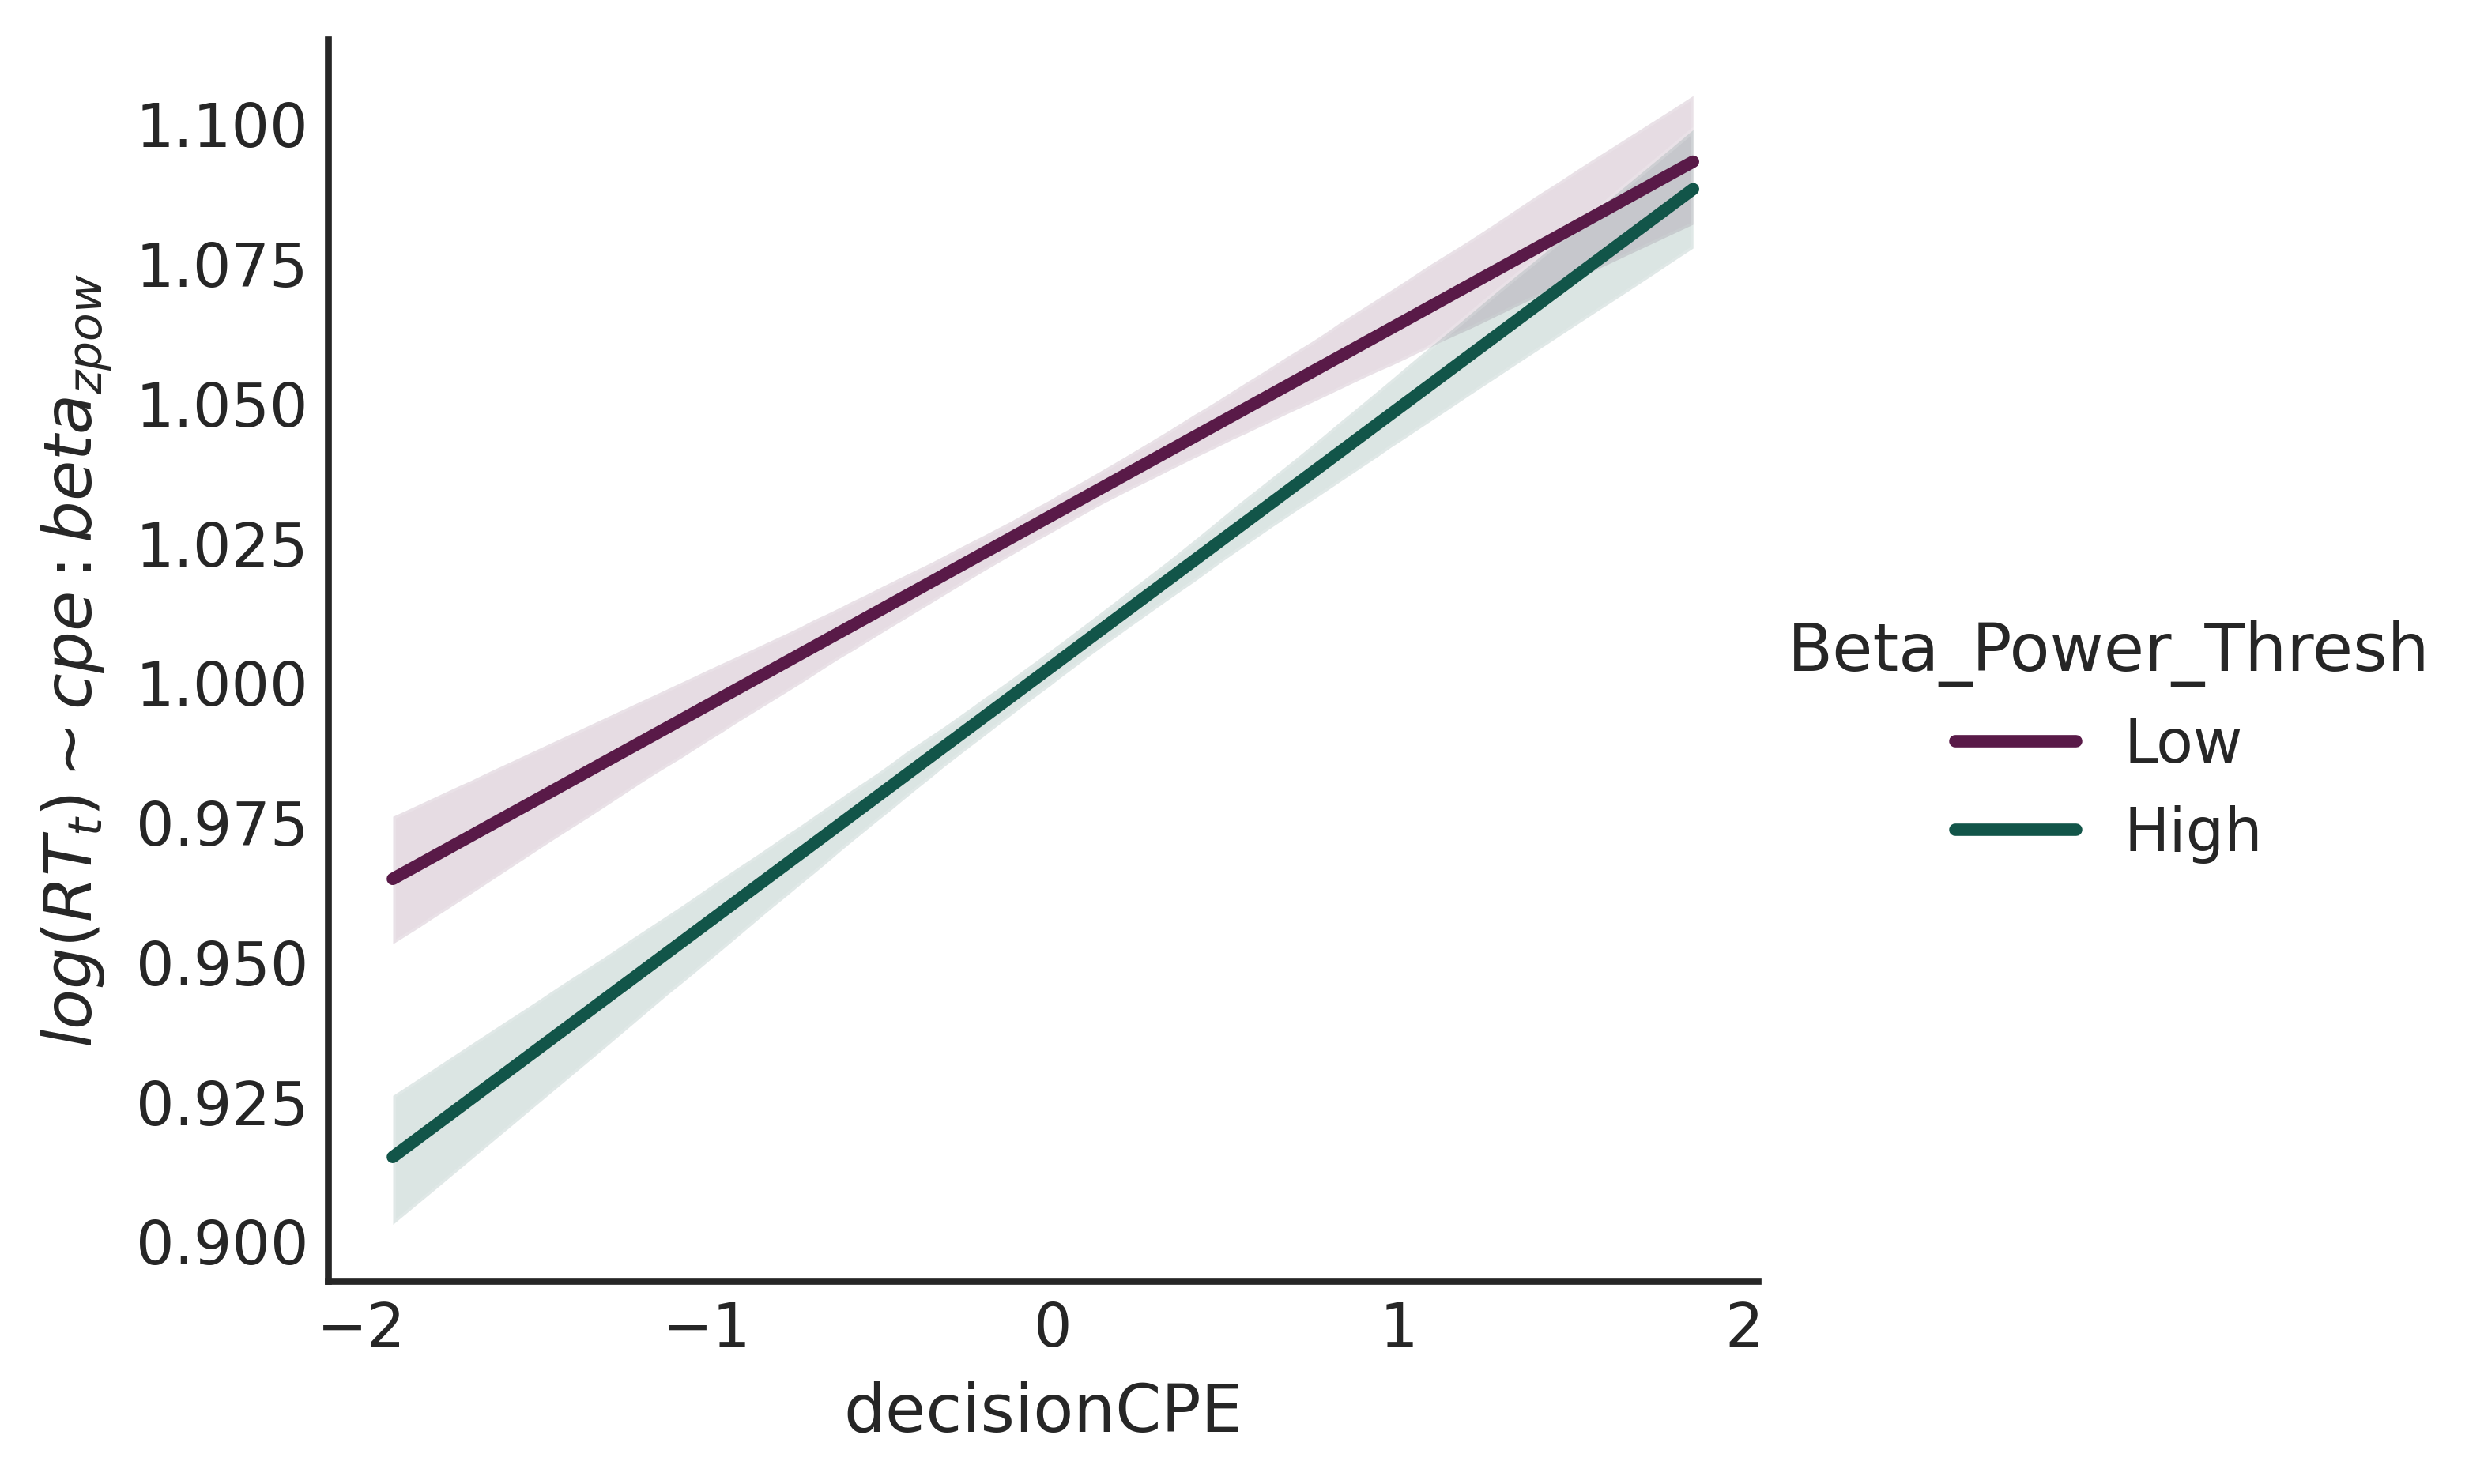

In [431]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 1.5})
sns.set_theme(style='ticks',rc={"figure.dpi": 500}) 


ax = sns.lmplot(data=lm_beta_reg_df,x='decisionCPE',y='logRT_t1',hue='Beta_Power_Thresh',scatter=False,height=4, 
           aspect=1.25,ci=95,palette=palette)
sns.move_legend(ax, "center right")

#     sns.regplot(data = roi_temp_data.groupby('subj_id').agg('mean'),x='bdi',y='raw_decisionCPE:band_pow'
#                 ,color='#3f2755') 
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#173b6f')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#0b4e5f')


plt.ylabel(r'$log(RT_t) \sim cpe:beta_{{{zpow}}}$')
# plt.xlabel(r'$cpe (z) $')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)




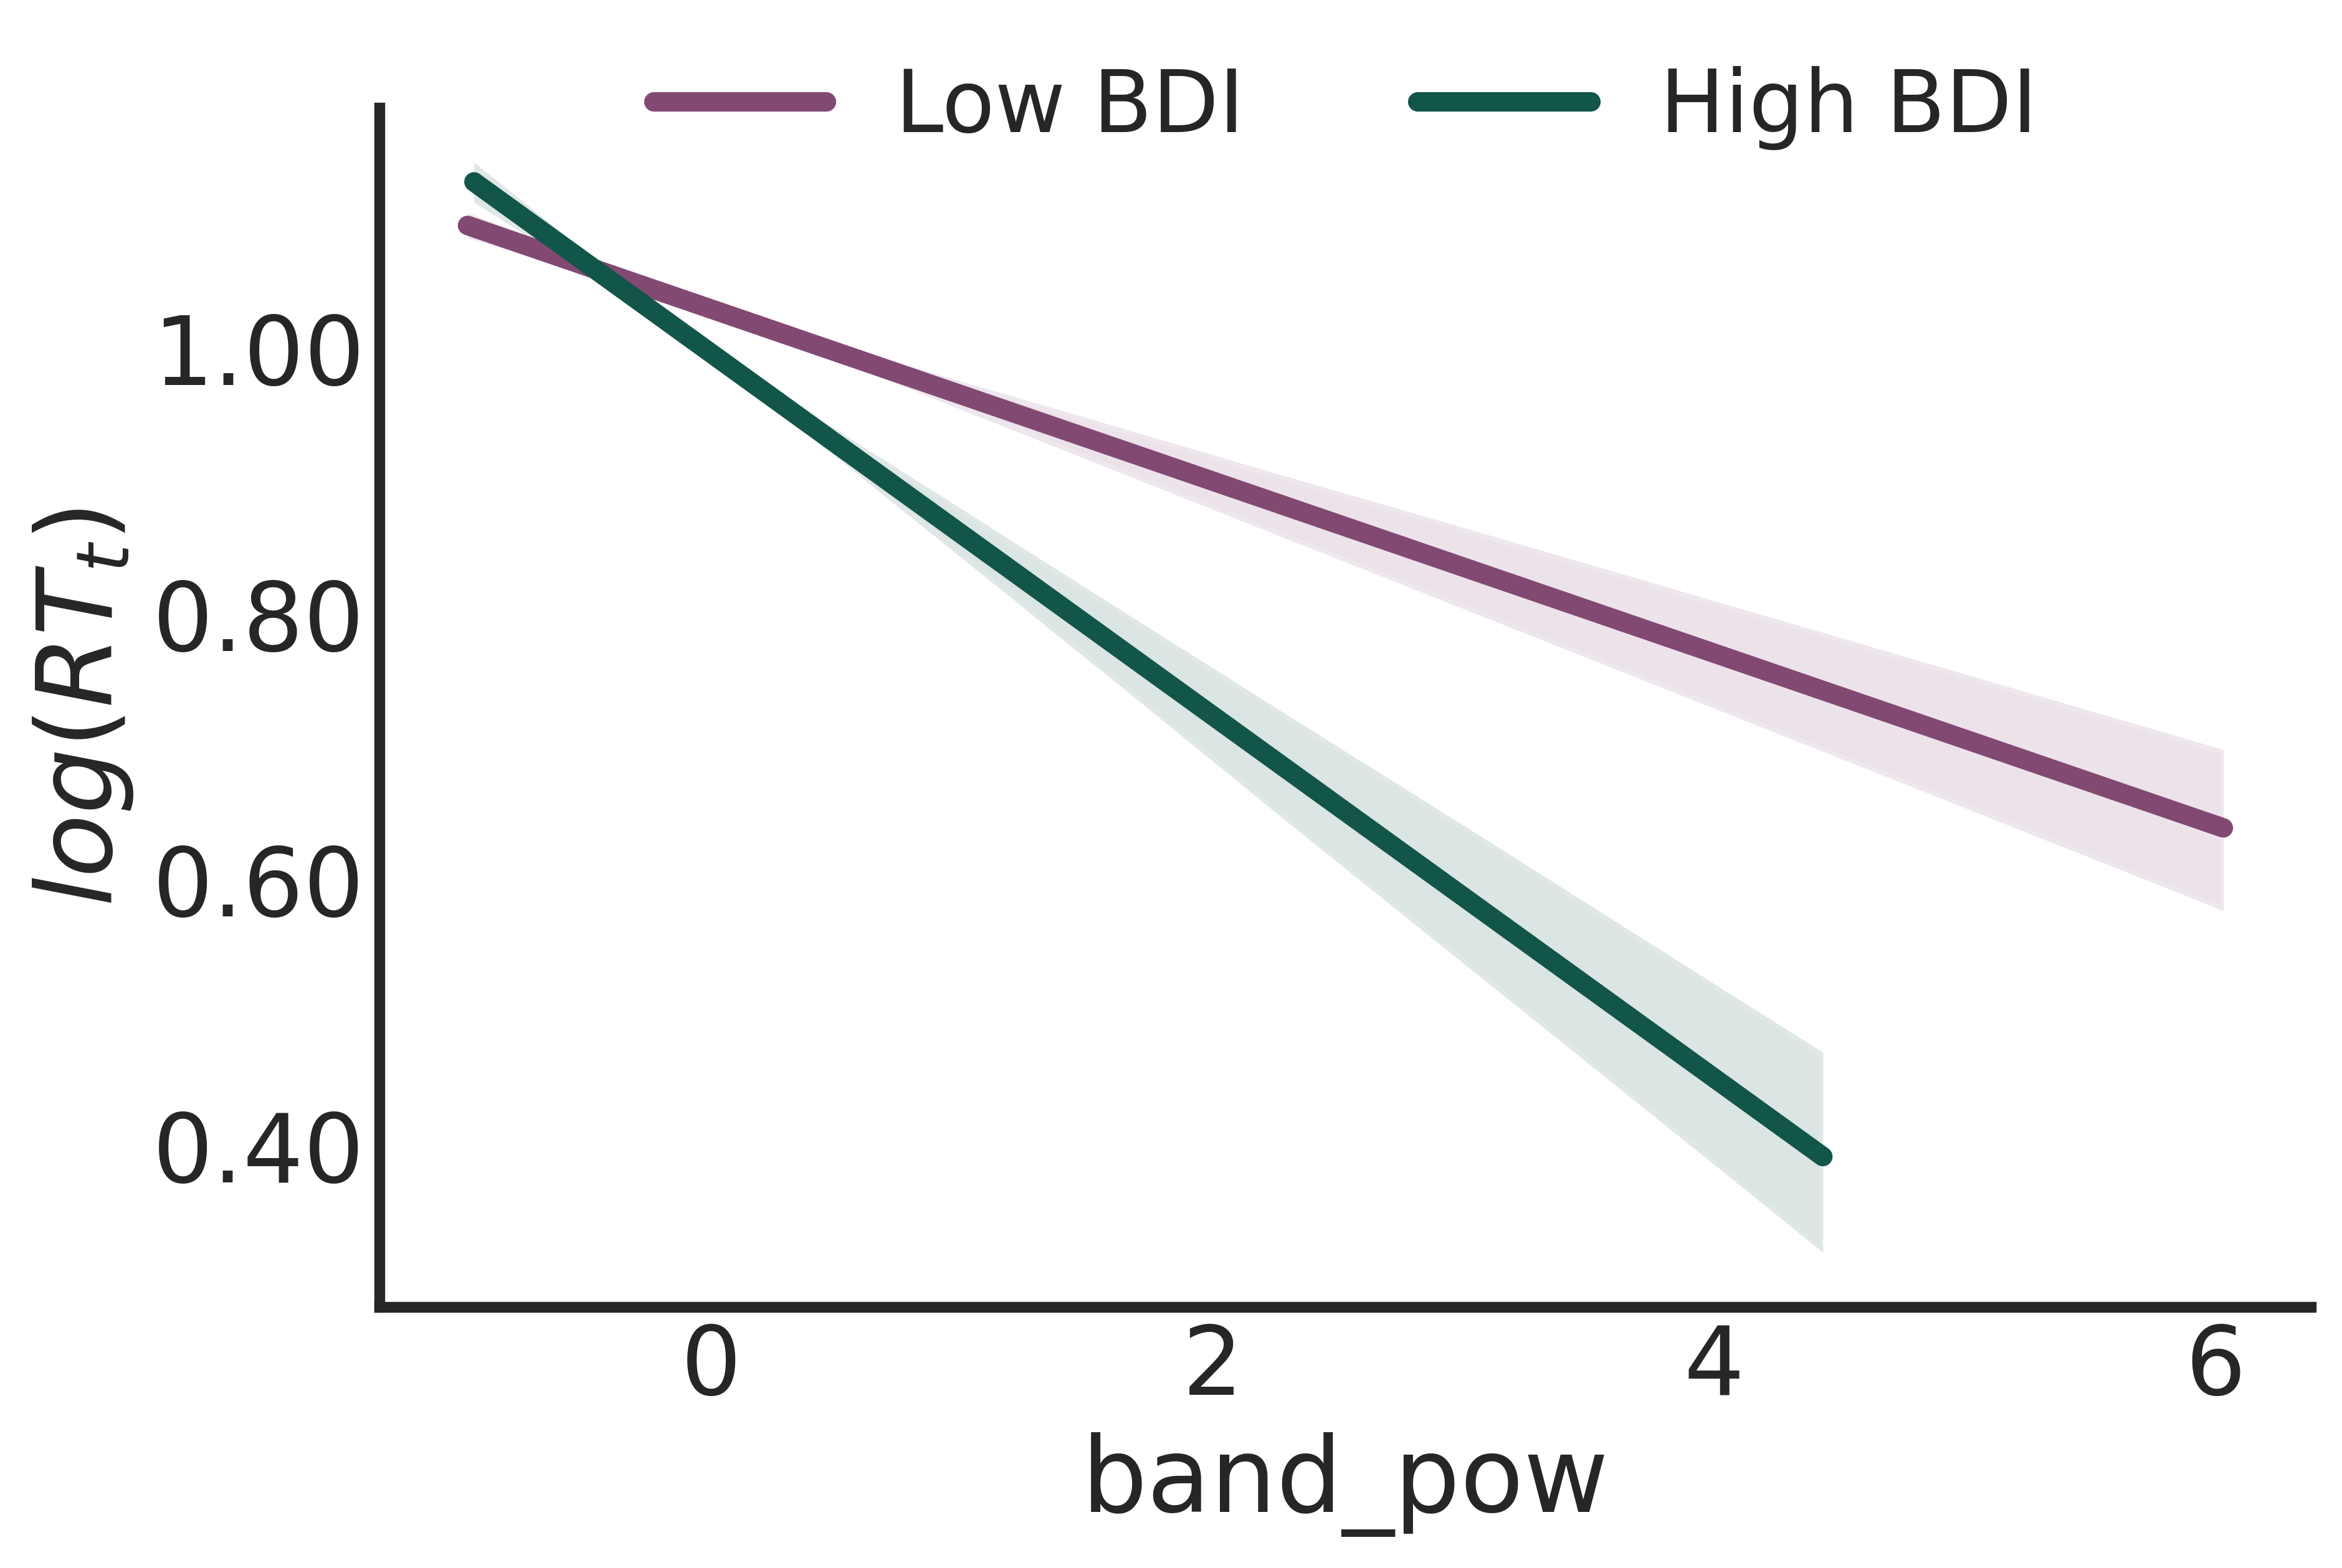

In [460]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#125549",'low BDI':"#824973"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='band_pow',y='logRT_t1',scatter=False,
           ci=95,color = '#824973',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='band_pow',y='logRT_t1',scatter=False,
           ci=95,color='#125549',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

# plt.ylabel(r'$beta_{{{zpow}}}$')
plt.ylabel(r'$log(RT_t)$')
# plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/rt_CPE_bdibandpow{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

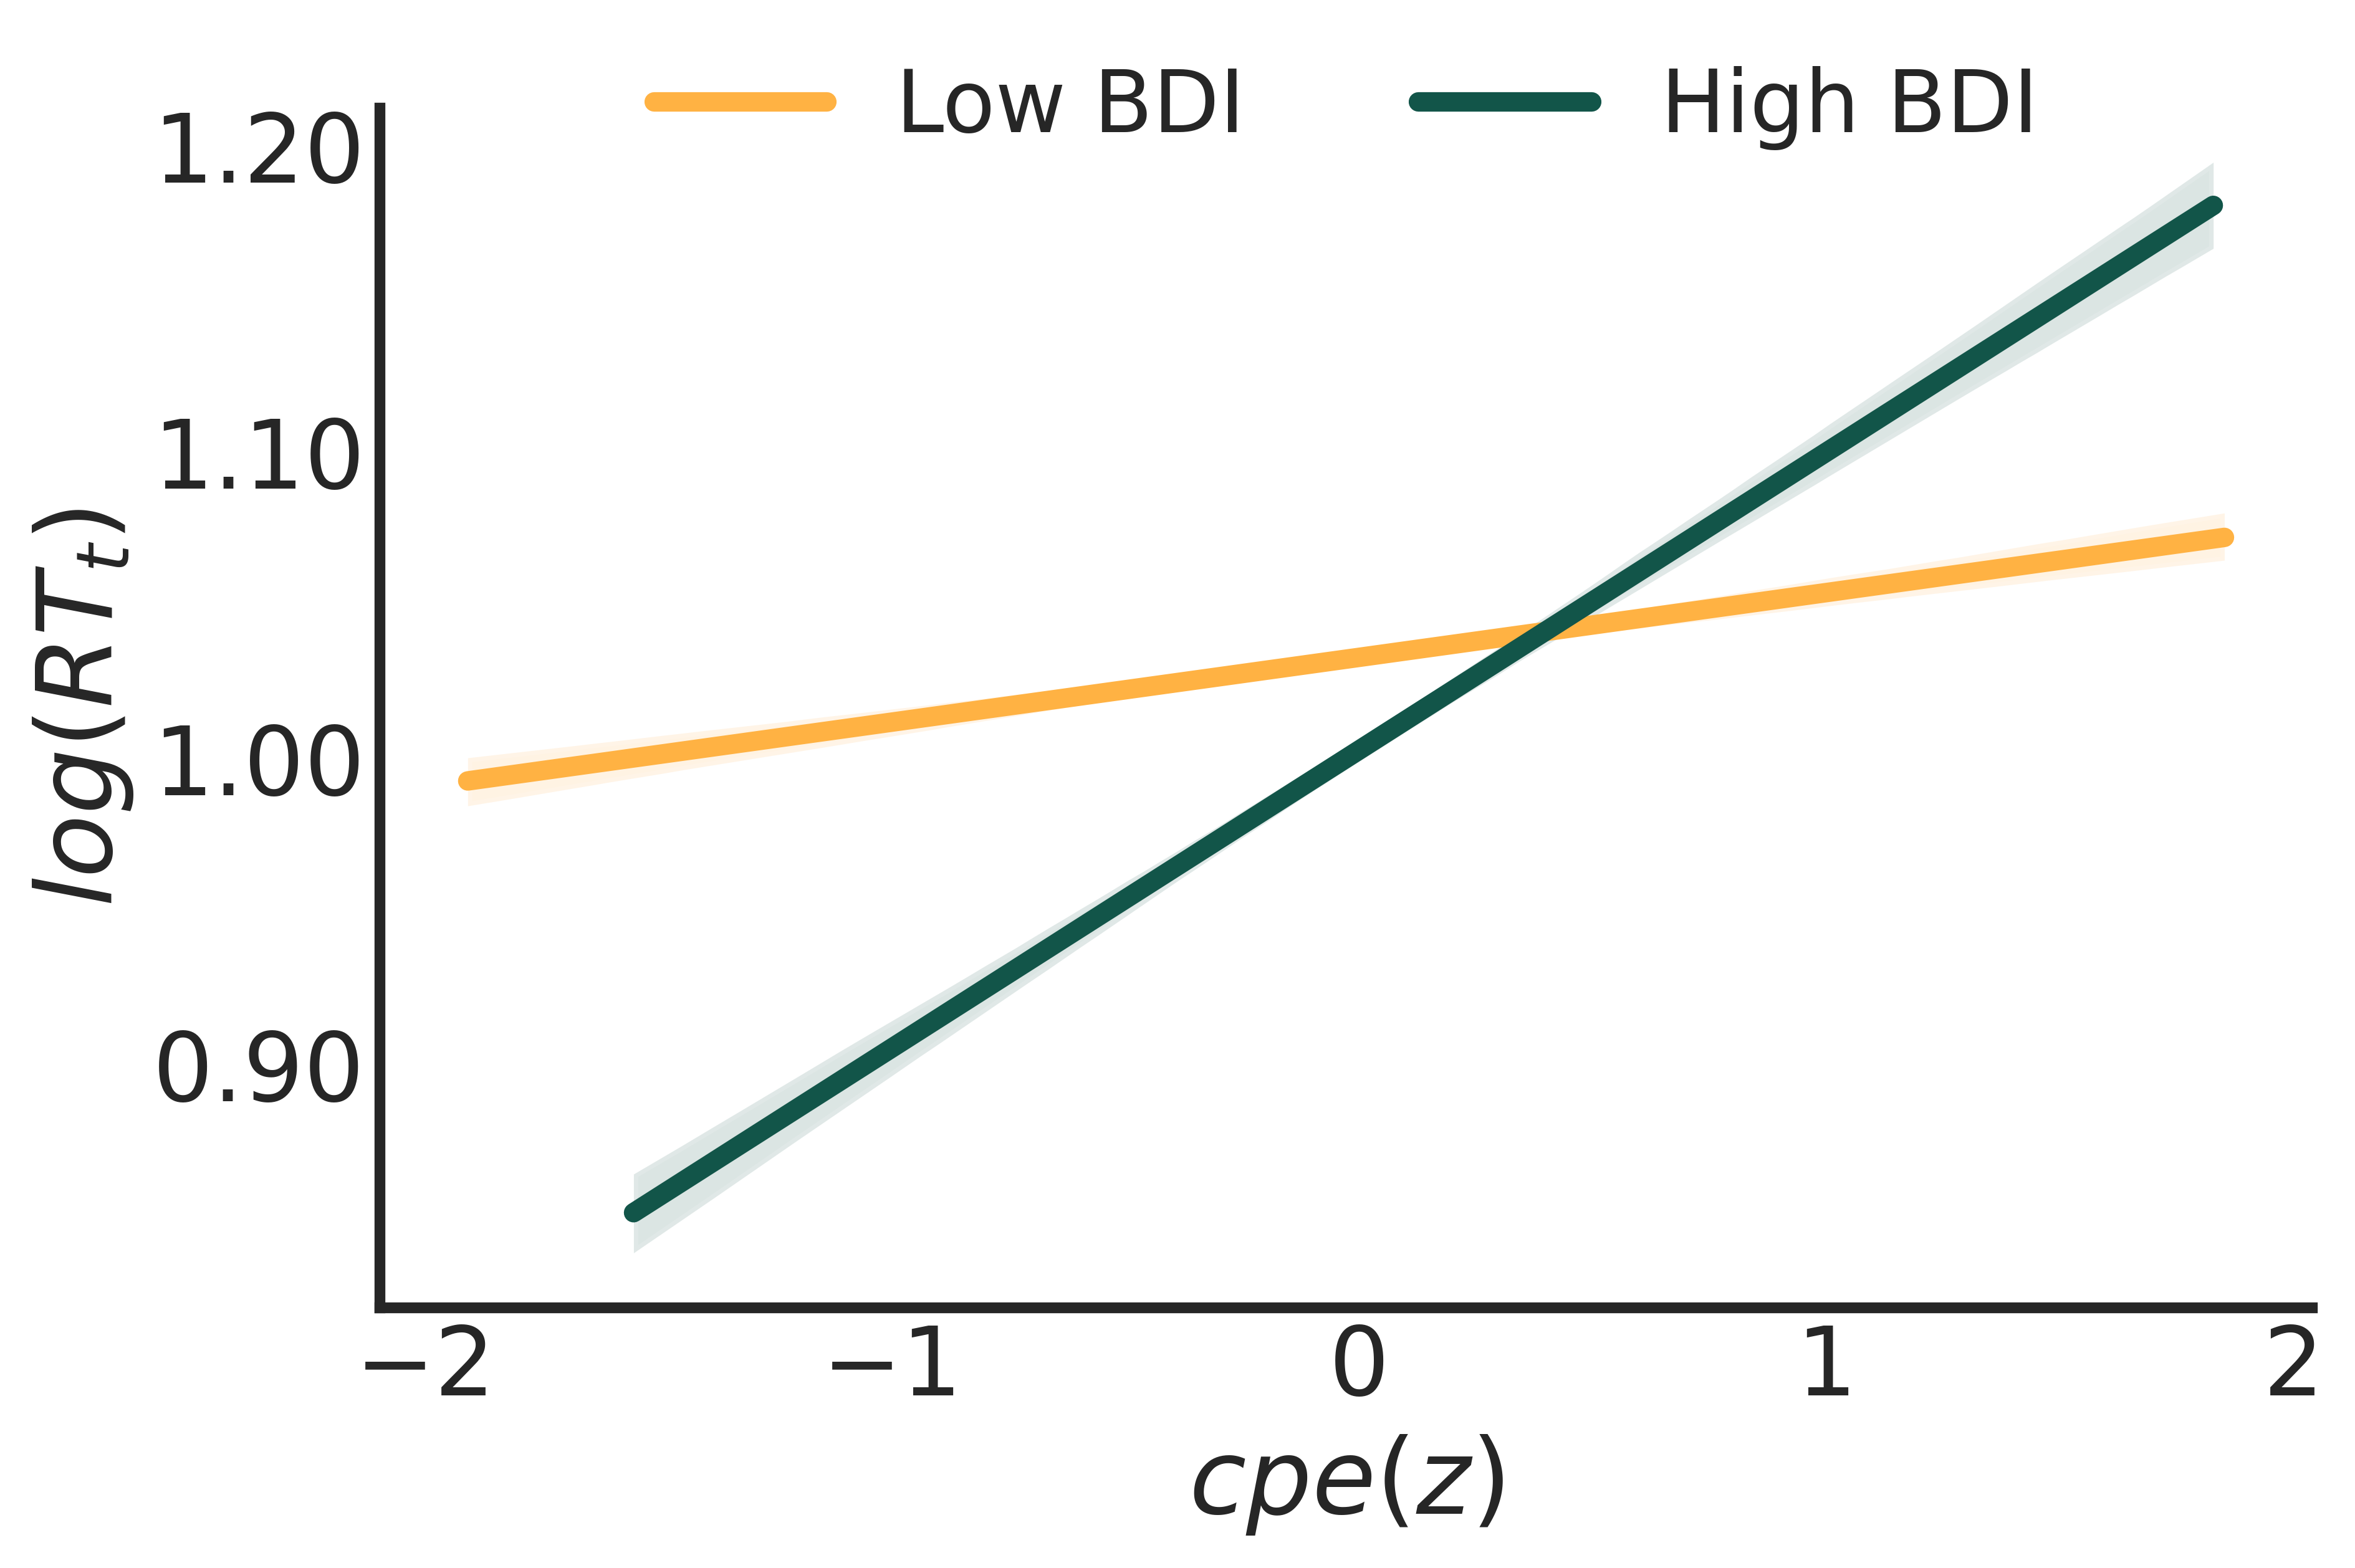

In [462]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#125549",'low BDI':"#ffb243"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='logRT_t1',scatter=False,
           ci=95,color = '#ffb243',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='logRT_t1',scatter=False,
           ci=95,color='#125549',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

# plt.ylabel(r'$beta_{{{zpow}}}$')
plt.ylabel(r'$log(RT_t)$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/rt_CPE_bdi{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [398]:
lm_beta_reg_df

subj_id  bdi  epoch       freq reref_ch_names  band_pow  \
0      MS002   14      0  20.743342  lacas1-lacas2 -0.123971   
1      MS002   14      0  20.743342  lacas2-lacas3 -0.186139   
2      MS002   14      0  20.743342  lacas3-lacas4 -0.235353   
3      MS002   14      0  20.743342  lacas4-lacas5 -0.086471   
4      MS002   14      0  20.743342  lacas5-lacas6 -0.145393   
...      ...  ...    ...        ...            ...       ...   
3748   DA037    4    148  20.743342  rpins1-rpins2 -0.832139   
3749   DA037    4    148  20.743342  rpins2-rpins3 -0.831343   
3750   DA037    4    148  20.743342  rpins3-rpins4 -0.251848   
3751   DA037    4    148  20.743342  rpins4-rpins5  0.022261   
3752   DA037    4    148  20.743342      rmc7-rmc8 -0.044171   

          unique_reref_ch    roi hemi ch_label4roi  ...    Profit TotalProfit  \
0     MS002_lacas1-lacas2    acc    l       lacas1  ... -0.032900   -1.028523   
1     MS002_lacas2-lacas3    acc    l       lacas2  ... -0.032900   -1.028523   
2     MS002_lacas3-lacas4    acc    l       lacas3  ... -0.032900   -1.028523   
3     MS002_lacas4-lacas5    acc    l       lacas4  ... -0.032900   -1.028523   
4     MS002_lacas5-lacas6    acc    l       lacas5  ... -0.032900   -1.028523   
...                   ...    ...  ...          ...  ...       ...         ...   
3748  DA037_rpins1-rpins2   pins    r       rpins1  ...  0.012982   -0.523591   
3749  DA037_rpins2-rpins3   pins    r       rpins2  ...  0.012982   -0.523591   
3750  DA037_rpins3-rpins4   pins    r       rpins3  ...  0.012982   -0.523591   
3751  DA037_rpins4-rpins5   pins    r       rpins4  ...  0.012982   -0.523591   
3752      DA037_rmc7-rmc8  dlpfc    r         rmc8  ...  0.012982   -0.523591   

           RPE  decisionCPE  decisionRegret  decisionRelief  Depressed  \
0    -0.008746    -0.395746       -0.287638       -0.392122    Low BDI   
1    -0.008746    -0.395746       -0.287638       -0.392122    Low BDI   
2    -0.008746    -0.395746       -0.287638       -0.392122    Low BDI   
3    -0.008746    -0.395746       -0.287638       -0.392122    Low BDI   
4    -0.008746    -0.395746       -0.287638       -0.392122    Low BDI   
...        ...          ...             ...             ...        ...   
3748 -0.481120    -0.353760       -0.291207       -0.317739    Low BDI   
3749 -0.481120    -0.353760       -0.291207       -0.317739    Low BDI   
3750 -0.481120    -0.353760       -0.291207       -0.317739    Low BDI   
3751 -0.481120    -0.353760       -0.291207       -0.317739    Low BDI   
3752 -0.481120    -0.353760       -0.291207       -0.317739    Low BDI   

     raw_rt_coeff elec_bCPE Beta_Power_Thresh  
0        0.010130  0.034137               Low  
1        0.009107  0.033114               Low  
2        0.009258  0.033264               Low  
3        0.011091  0.035097               Low  
4        0.014251  0.038257               Low  
...           ...       ...               ...  
3748     0.003152  0.027159               Low  
3749     0.002767  0.026773               Low  
3750     0.003549  0.027555               Low  
3751     0.001469  0.025475              High  
3752     0.001684  0.025690               Low  

[157569 rows x 36 columns]

In [ ]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

# from matplotlib import rc
# rc('text', usetex=False)


fig,ax = plt.subplots(figsize=(8,5),dpi=500)
# sns.set_context("poster",rc={'axes.linewidth': 2})
# sns.set_theme(style='ticks') 

# palette={'depression':"#3f2755",'no depression':"#054a6f"}

palette={'high BDI':"#125549",'low BDI':"#824973"}


# ax = sns.lmplot(data=beta_reg_df,x='decisionCPE',y='band_pow',hue='Depression',scatter=False,ci=95,palette=palette)
# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(0.1, 1),bbox_to_anchor=(-1, 0), ncol=2)

# sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)


sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='logRT_t1',scatter=False,
           ci=95,color = '#824973',label='Low BDI')
sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='logRT_t1',scatter=False,
           ci=95,color='#125549',label='High BDI')

plt.legend(fontsize=10)
# borderaxespad=0,frameon=False,framealpha=0,
sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1.1), frameon=False,framealpha=0,
                fontsize='small',shadow=None,
                columnspacing=2,ncol=2)


plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

# plt.ylabel(r'$beta_{{{zpow}}}$')
plt.ylabel(r'$log(RT_t)$')
plt.xlabel(r'$cpe(z)$')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)


plt.savefig(f'{fig_save_dir}/rt_CPE_bdi{date}.pdf', format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.1,dpi=500,
facecolor='auto', edgecolor='auto',
backend=None)

In [ ]:
raw_rt_coeff
054a6f
824973

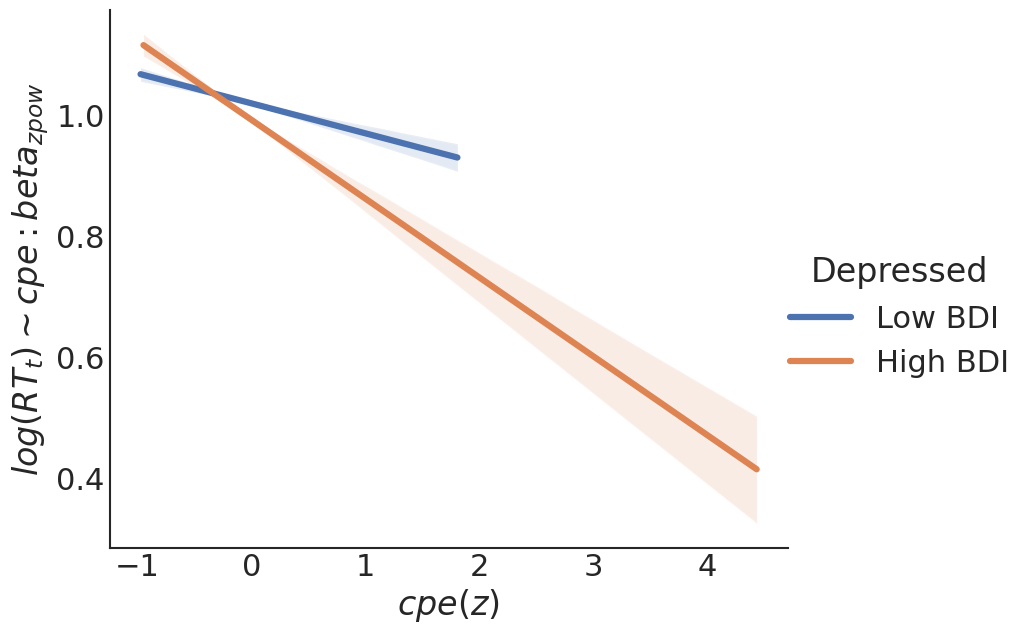

In [408]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 1.5})

sns.lmplot(data=lm_beta_reg_df,x='band_pow',y='logRT_t1',hue='Depressed',scatter=False,height=7, 
           aspect=1.25,ci=95)

#     sns.regplot(data = roi_temp_data.groupby('subj_id').agg('mean'),x='bdi',y='raw_decisionCPE:band_pow'
#                 ,color='#3f2755') 
# sns.regplot(data=lm_beta_reg_df[lm_beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='raw_rt_coeff',
#             scatter=False,
#            ci=95,color = '#173b6f')
# sns.regplot(data=lm_beta_reg_df[lm_beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='raw_rt_coeff',
#             scatter=False,
#            ci=95,color='#0b4e5f')


plt.ylabel(r'$log(RT_t) \sim cpe:beta_{{{zpow}}}$')
plt.xlabel(r'$cpe (z) $')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)




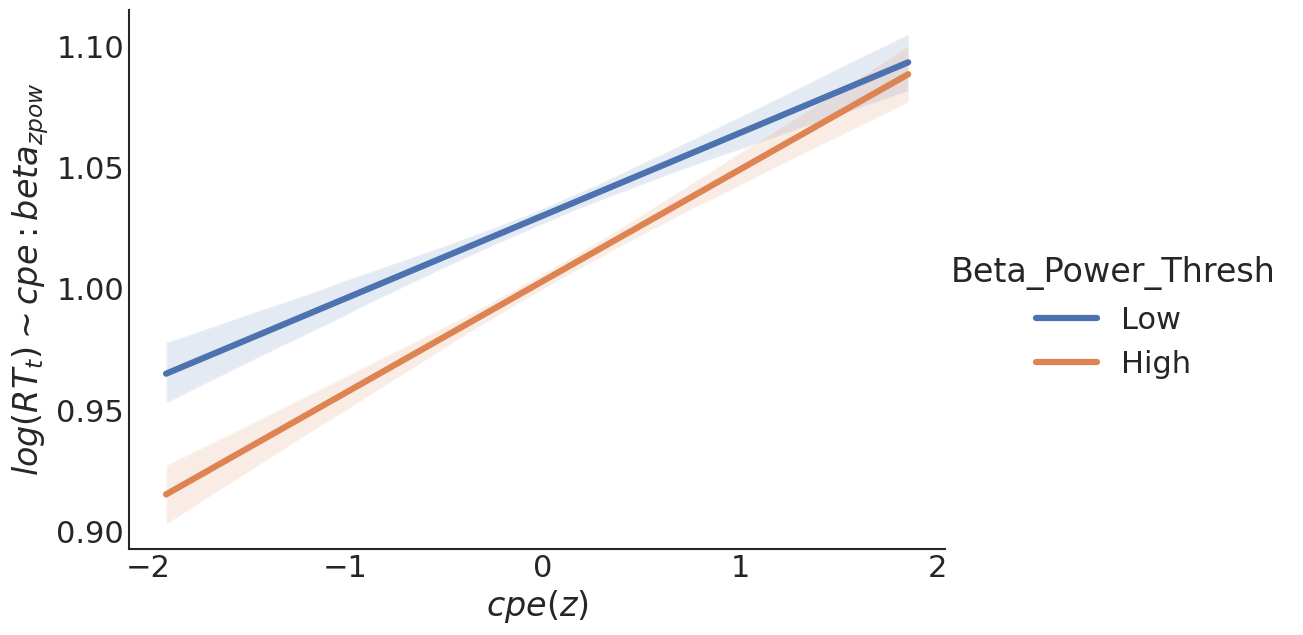

In [400]:
# fig,ax = plt.subplots(figsize=(7,5),dpi=500)
sns.set_context("poster",rc={'axes.linewidth': 1.5})

sns.lmplot(data=lm_beta_reg_df,x='decisionCPE',y='logRT_t1',hue='Beta_Power_Thresh',scatter=False,height=7, 
           aspect=1.5,ci=95)

#     sns.regplot(data = roi_temp_data.groupby('subj_id').agg('mean'),x='bdi',y='raw_decisionCPE:band_pow'
#                 ,color='#3f2755') 
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='Low BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color = '#173b6f')
# sns.regplot(data=beta_reg_df[beta_reg_df.Depressed=='High BDI'],x='decisionCPE',y='band_pow',scatter=False,
#            ci=95,color='#0b4e5f')


plt.ylabel(r'$log(RT_t) \sim cpe:beta_{{{zpow}}}$')
plt.xlabel(r'$cpe (z) $')
sns.despine()
plt.tick_params(length=0)
# plt.text(7.25,0.07,f'rho: {np.round(r,3)} \n p: {np.round(p_r,6)}',fontsize=16)

